# Pitchfork Analysis - Song Data Analysis
## Load Libraries & Data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

from scipy.stats import mannwhitneyu
from scipy.stats import zscore

import re

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 3000)

In [2]:
top_album_songs = pd.read_csv('top_album_songs.csv', index_col=False)
bottom_album_songs = pd.read_csv('bottom_album_songs.csv', index_col=False)

In [3]:
genre_cols = ['electronic', 'experimental', 'folk/country', 'global', 'jazz', 'metal', 
              'pop/r&b', 'rap', 'rock', 'unknown']

numeric_cols = ['song_duration', 'acousticness', 'danceability', 'energy', 'instrumentalness',
                'liveness', 'speechiness', 'tempo', 'valence', 'popularity']

cat_cols = ['key', 'time_signature', 'song_explicit', 'mode']

In [4]:
top_album_songs['number_of_genres'] = top_album_songs['electronic'] + top_album_songs['experimental'] + top_album_songs['folk/country'] + top_album_songs['global'] + top_album_songs['jazz'] + top_album_songs['metal'] + top_album_songs['pop/r&b'] + top_album_songs['rap'] + top_album_songs['rock'] + top_album_songs['unknown']
bottom_album_songs['number_of_genres'] = bottom_album_songs['electronic'] + bottom_album_songs['experimental'] + bottom_album_songs['folk/country'] + bottom_album_songs['global'] + bottom_album_songs['jazz'] + bottom_album_songs['metal'] + bottom_album_songs['pop/r&b'] + bottom_album_songs['rap'] + bottom_album_songs['rock'] + bottom_album_songs['unknown']

In [9]:
top_album_songs = top_album_songs.fillna(0)
bottom_album_songs = bottom_album_songs.fillna(0)

In [10]:
top_album_mean = top_album_songs.groupby(['reviewid', 'artist_name', 'album_title']).mean()
top_album_df = top_album_mean[genre_cols]
top_album_mean_cols = [x + '_mean' for x in top_album_mean.columns]
top_album_mean.columns = top_album_mean_cols

bottom_album_mean = bottom_album_songs.groupby(['reviewid', 'artist_name', 'album_title']).mean()
bottom_album_df = bottom_album_mean[genre_cols]
bottom_album_mean_cols = [x + '_mean' for x in bottom_album_mean.columns]
bottom_album_mean.columns = bottom_album_mean_cols

mean_cols = ['score_mean', 'song_duration_mean', 'song_explicit_mean', 'acousticness_mean', 'danceability_mean',  
             'energy_mean', 'mode_mean', 'instrumentalness_mean', 'liveness_mean', 'speechiness_mean', 
             'tempo_mean', 'valence_mean', 'popularity_mean']

top_album_df = pd.concat([top_album_df, top_album_mean[mean_cols]], axis=1)
bottom_album_df = pd.concat([bottom_album_df, bottom_album_mean[mean_cols]], axis=1)

In [11]:
def clean_text(text_input, remove_lines=True):
    text_input = text_input.lower()
    if remove_lines:
        text_input = re.sub('\n', ' ', text_input)
    else:
        text_input = re.sub('\n', 'QZQ', text_input)
    text_input = re.sub(r'\([^)]*\)', '', text_input).strip()
    text_input = re.sub("[\(\[].*?[\)\]]", "", text_input).strip()
    text_input = re.sub(' & ', ' and ', text_input)
    text_input = re.sub('-', ' ', text_input)
    text_input = re.sub("[,.']", '', text_input)
    text_input = re.sub(' +', ' ', text_input)
    text_input = re.sub('"', '', text_input)
    text_input = re.sub('!', '', text_input)
    text_input = re.sub(':', '', text_input)
    text_input = re.sub('/', ' ', text_input)
    text_input = re.sub(r'[^0-9A-Za-z ]', '', text_input)
    if not remove_lines:
        text_input = re.sub('QZQ', '\n', text_input)
    text_input = text_input.strip()

    return text_input

In [12]:
def count_lines(lyric_text):
    if lyric_text == 'lyrics not found':
        return 0
    else:
        lyric_text = clean_text(lyric_text, remove_lines=False)
        return len(lyric_text.split('\n'))

In [13]:
def count_words(lyric_text):
    if lyric_text == 'lyrics not found':
        return 0
    else:
        lyric_text = clean_text(lyric_text)
        return len(lyric_text.split(' '))

In [14]:
def count_unique_words(lyric_text):
    if lyric_text == 'lyrics not found':
        return 0
    else:
        lyric_text = clean_text(lyric_text)
        return len(set(lyric_text.split(' ')))

In [15]:
top_album_songs['lyric_lines'] = top_album_songs['song_lyrics'].apply(count_lines)
bottom_album_songs['lyric_lines'] = bottom_album_songs['song_lyrics'].apply(count_lines)

top_album_songs['lyric_words'] = top_album_songs['song_lyrics'].apply(count_words)
bottom_album_songs['lyric_words'] = bottom_album_songs['song_lyrics'].apply(count_words)

top_album_songs['lyric_unique_words'] = top_album_songs['song_lyrics'].apply(count_unique_words)
bottom_album_songs['lyric_unique_words'] = bottom_album_songs['song_lyrics'].apply(count_unique_words)

top_album_songs['words_per_line'] = top_album_songs['lyric_words'] / top_album_songs['lyric_lines']
bottom_album_songs['words_per_line'] = bottom_album_songs['lyric_words'] / bottom_album_songs['lyric_lines']

In [16]:
top_lyrics = top_album_songs.loc[top_album_songs['song_lyrics'] != 'lyrics not found']
bottom_lyrics = bottom_album_songs.loc[bottom_album_songs['song_lyrics'] != 'lyrics not found']

## Data Summary

In [17]:
data_summary = pd.DataFrame(columns=['Genre', 'Total Albums', 'Top 10% Albums', 'Bottom 10% Albums', 
                                     'Total Songs', 'Top 10% Songs', 'Bottom 10% Songs', 'Total Songs w/ Lyrics',
                                     'Top 10% Songs w/ Lyrics', 'Bottom 10% Songs w/ Lyrics'])

for genre in genre_cols:
    top_genre_songs_df = top_album_songs.loc[top_album_songs[genre] == 1]
    bottom_genre_songs_df = bottom_album_songs.loc[bottom_album_songs[genre] == 1]
    
    top_genre_songs = len(top_genre_songs_df)
    bottom_genre_songs = len(bottom_genre_songs_df)
    
    top_genre_albums_df = top_album_df.loc[top_album_df[genre] == 1]
    bottom_genre_albums_df = bottom_album_df.loc[bottom_album_df[genre] == 1]
    
    top_genre_albums = len(top_genre_albums_df)
    bottom_genre_albums = len(bottom_genre_albums_df)
    
    top_lyrics_genre_df = top_lyrics.loc[top_lyrics[genre] == 1]
    bottom_lyrics_genre_df = bottom_lyrics.loc[bottom_lyrics[genre] == 1]
    
    top_lyrics_val = len(top_lyrics_genre_df)
    bottom_lyrics_val = len(bottom_lyrics_genre_df)
    
    total_genre_albums = top_genre_albums + bottom_genre_albums
    total_genre_songs = top_genre_songs + bottom_genre_songs
    total_lyrics = top_lyrics_val + bottom_lyrics_val
    
    
    data_summary.loc[len(data_summary)] = [genre, total_genre_albums, top_genre_albums, bottom_genre_albums,
                                           total_genre_songs, top_genre_songs, bottom_genre_songs,
                                           total_lyrics, top_lyrics_val, bottom_lyrics_val]
    
total_albums_val = len(top_album_df) + len(bottom_album_df)
total_songs_val = len(top_album_songs) + len(bottom_album_songs)
total_songs_lyrics_val = len(top_lyrics) + len(bottom_lyrics)
    
data_summary.loc[len(data_summary)] = ['TOTAL', total_albums_val, len(top_album_df), len(bottom_album_df),
                                       total_songs_val, len(top_album_songs), len(bottom_album_songs),
                                       total_songs_lyrics_val, len(top_lyrics), len(bottom_lyrics)]
    
data_summary

Genre Total Albums Top 10% Albums Bottom 10% Albums Total Songs  \
0     electronic          690            298               392        8685   
1   experimental          277            204                73        3457   
2   folk/country           93             58                35        1375   
3         global           30             23                 7         409   
4           jazz           85             56                29        1165   
5          metal          164             67                97        1907   
6        pop/r&b          241            105               136        3221   
7            rap          271            114               157        4313   
8           rock         1883            896               987       26229   
9        unknown          277            126               151        5003   
10         TOTAL         3218           1602              1616       45765   

   Top 10% Songs Bottom 10% Songs Total Songs w/ Lyrics  \
0           3871             4814                  4822   
1           2701              756                  1817   
2            935              440                   826   
3            334               75                   225   
4            835              330                   405   
5            749             1158                  1301   
6           1488             1733                  2441   
7           1944             2369                  3476   
8          14095            12134                 19803   
9           2958             2045                   921   
10         25270            20495                 29451   

   Top 10% Songs w/ Lyrics Bottom 10% Songs w/ Lyrics  
0                     1864                       2958  
1                     1441                        376  
2                      597                        229  
3                      181                         44  
4                      234                        171  
5                      569                        732  
6                     1226                       1215  
7                     1608                       1868  
8                    11269                       8534  
9                      335                        586  
10                   16483                      12968

## Album Score Comparisons
### Top 10%

In [18]:
print('Mean Score: ', str(top_album_df['score_mean'].mean()))
print('Standard Deviation: ', str(top_album_df['score_mean'].std()))

Mean Score:  8.797378277153534
Standard Deviation:  0.42719030975907923


### Bottom 10%

In [19]:
print('Mean Score: ', str(bottom_album_df['score_mean'].mean()))
print('Standard Deviation: ', str(bottom_album_df['score_mean'].std()))

Mean Score:  4.19622524752475
Standard Deviation:  1.0629321482149845


### Distribution Comparaison

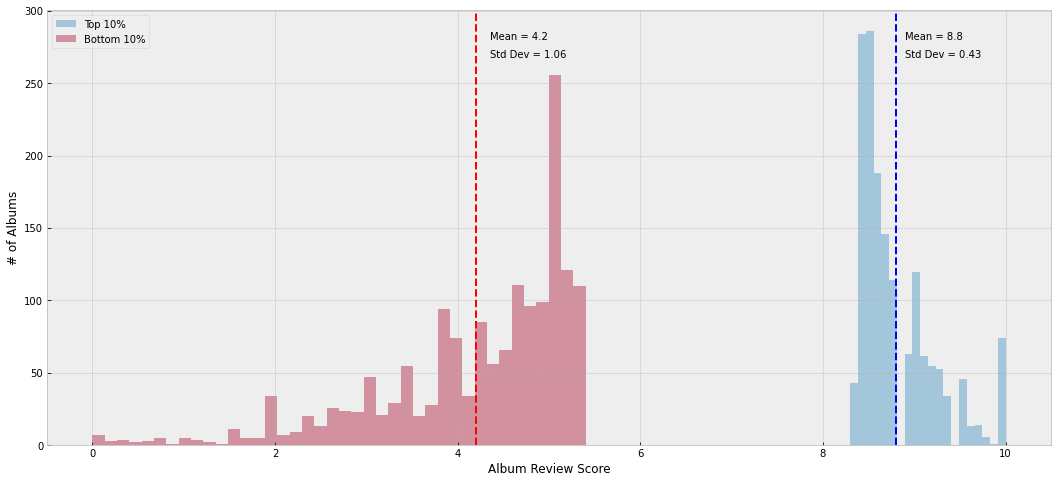

In [20]:
fig, ax = plt.subplots(figsize=(18,8))
sns.distplot(top_album_df['score_mean'], norm_hist=False, kde=False, bins=20, label='Top 10%')
sns.distplot(bottom_album_df['score_mean'], norm_hist=False, kde=False, bins=40, label='Bottom 10%')
ax.axvline(top_album_df['score_mean'].mean(), ls='--', color='blue')
ax.axvline(bottom_album_df['score_mean'].mean(), ls='--', color='red')
ax.text(4.35, 280, 'Mean = {}'.format(round(bottom_album_df['score_mean'].mean(), 1)), fontsize=10)
ax.text(4.35, 268, 'Std Dev = {}'.format(round(bottom_album_df['score_mean'].std(), 2)), fontsize=10)
ax.text(8.9, 280, 'Mean = {}'.format(round(top_album_df['score_mean'].mean(), 1)), fontsize=10)
ax.text(8.9, 268, 'Std Dev = {}'.format(round(top_album_df['score_mean'].std(), 2)), fontsize=10)
plt.xlabel('Album Review Score')
plt.ylabel('# of Albums')
plt.legend(loc='upper left')
plt.savefig('images/score_distribution.png')
plt.show()

## Top vs. Bottom 10% Albums:  Categorical Variables

Categorical song data includes each song's key, time signature, explicit lyric status (explicit / non-explicit) and mode (major / minor). We will look at each of these variables across each set of songs (top 10% and bottom 10%) as well as across individual genre subsets (electronic, experimental, folk/country, global, jazz, metal, pop/R&B, rap, and rock) within each of these song subsets.

In [21]:
def plot_cat_cols(col, upper_df, lower_df, title=None, x_axis_labels=None, axis=None, y_limit=None, 
                  rotate_x=False, save=False, save_title=None, x_label = ''):
    top_vals = upper_df[col].value_counts()/len(upper_df)*100
    top_df = pd.DataFrame(list(zip(top_vals.sort_index().index.values, top_vals.sort_index())), 
                          columns=[col, 'album_percent'])
    top_df['album_category'] = 'Top 10%'
    
    bottom_vals = lower_df[col].value_counts()/len(lower_df)*100
    bottom_df = pd.DataFrame(list(zip(bottom_vals.sort_index().index.values, bottom_vals.sort_index())), 
                             columns=[col, 'album_percent'])
    bottom_df['album_category'] = 'Bottom 10%'
    
    combined_df = pd.concat([top_df, bottom_df])
    if axis != None:
        sns.barplot(data=combined_df, x=col, y='album_percent', hue='album_category', ax=axis)
        axis.get_legend().remove()
        axis.set_title(title, fontsize=14)
        axis.set_xlabel(x_label, fontsize=14)
        axis.set_ylabel('% of Songs', fontsize=14)
        axis.set_xticklabels(x_axis_labels, fontsize=12)
        if y_limit != None:
            axis.set_ylim(0, y_limit)
        axis.tick_params(axis='y', which='major', labelsize=12)
        if rotate_x:
            axis.set_xticklabels(axis.get_xticklabels(), rotation=45, ha='right')
    else: 
        fig, ax = plt.subplots(figsize=(18, 8))
        sns.barplot(data=combined_df, x=col, y='album_percent', hue='album_category')
#         fig.legend(loc='upper right')
        if x_label == '':
            ax.set_xlabel(col, fontsize=14)
        else:
            ax.set_xlabel(x_label, fontsize=14)
        ax.set_ylabel('% of Songs', fontsize=14)
        if y_limit != None:
            ax.set_ylim(0, y_limit)
        plt.legend(loc='upper right', prop={'size': 14}, ncol=2)
        if rotate_x:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    if x_axis_labels != None:
        x = np.array(range(len(x_axis_labels)))
        plt.xticks(x, x_axis_labels, fontsize=12)    
    plt.yticks(fontsize=12)
    plt.title(title, fontsize=14)
    if save:
        plt.savefig('images/' + save_title)

In [22]:
def plot_cat_grid(cat_var, upper_df, lower_df, title=None, labels=None, y_limit=None, rotate_x=False, x_label=''):
    fig, axs = plt.subplots(5,2, figsize=(14,22))
    genre_counter = 0

    for row in range(5):
        for col in range(2):
            genre = genre_cols[genre_counter]
            top_genre_df = upper_df.loc[upper_df[genre] == 1]
            bottom_genre_df = lower_df.loc[lower_df[genre] == 1]
            plot_cat_cols(cat_var, top_genre_df, bottom_genre_df, title=genre, y_limit=y_limit,
                          x_axis_labels=labels, axis=axs[row,col], rotate_x=rotate_x, x_label=x_label)
            genre_counter += 1
    
    handles, labels = axs[row,col].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', fontsize=12, ncol=2)
    fig.tight_layout(pad=3, rect=[0, 0.03, 1, 0.97])
    plt.suptitle(title, fontsize=12)

### Key

The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. If no key was detected, the value is -1.

In [23]:
key_labels = ['C', 'C#/Db', 'D', 'D#/Eb', 'E', 'F', 'F#/Gb', 'G', 'G#/Ab', 'A', 'A#/Bb', 'B']

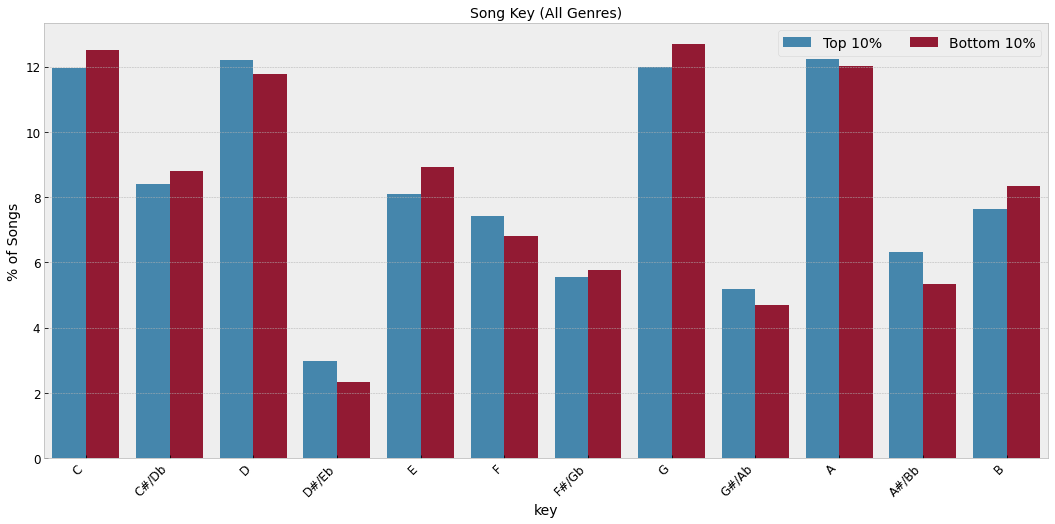

In [24]:
plot_cat_cols('key', top_album_songs, bottom_album_songs, title='Song Key (All Genres)', 
              x_axis_labels=key_labels, rotate_x=True)

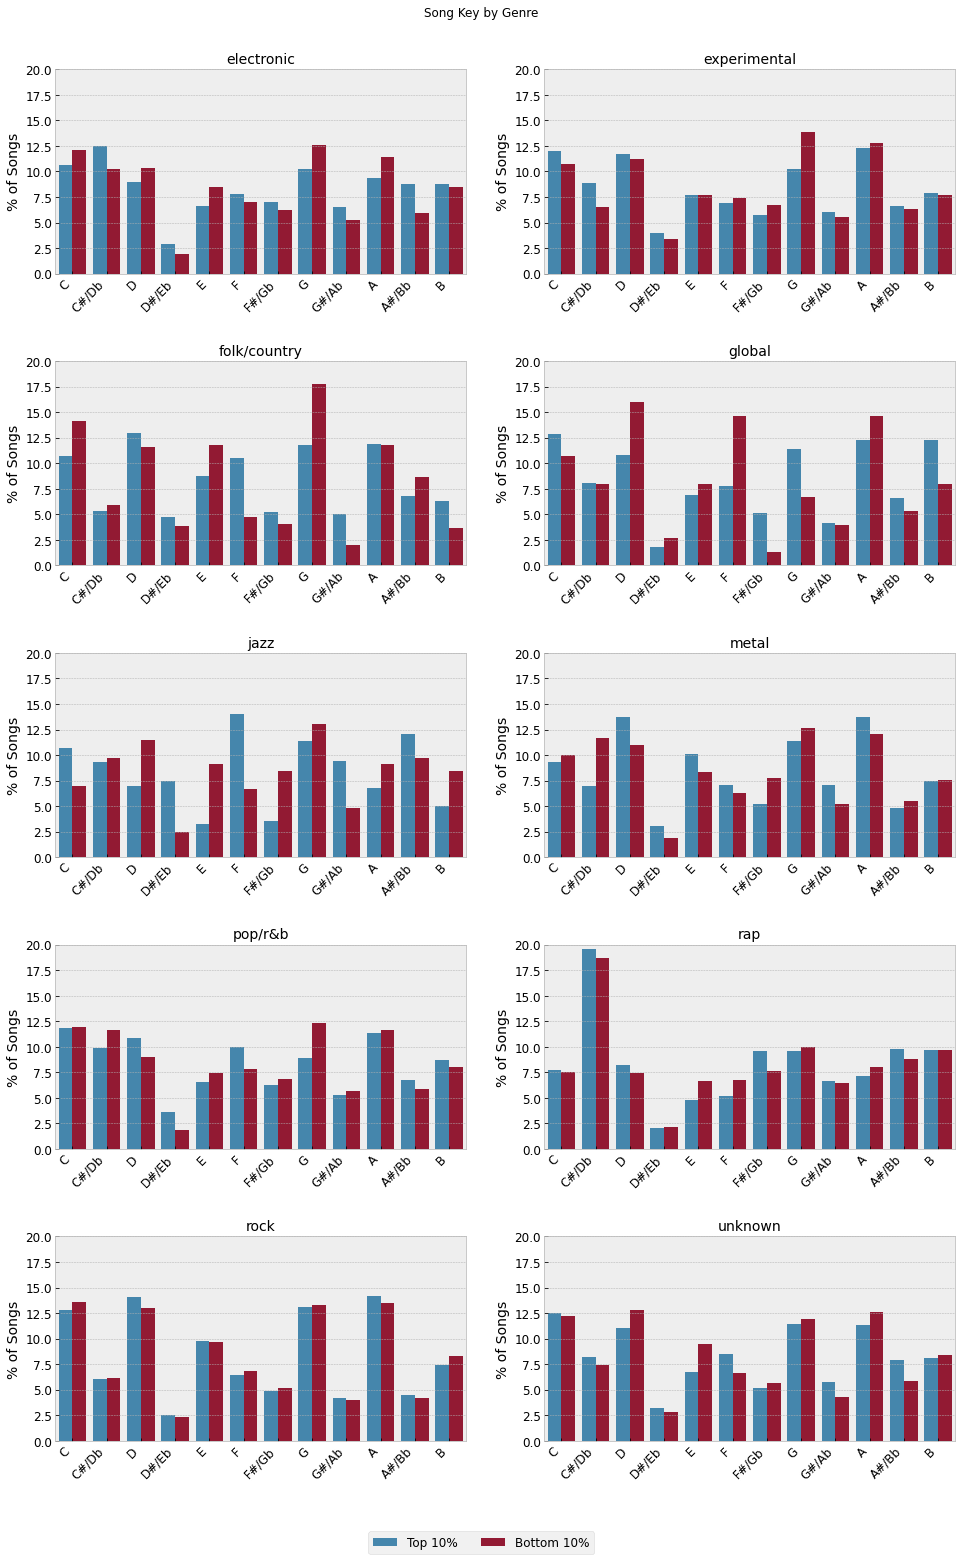

In [25]:
plot_cat_grid('key', top_album_songs, bottom_album_songs, 'Song Key by Genre', key_labels, 20, rotate_x=True)

### Time Signature

An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of “3/4”, to “7/4”.

The overwhelming majority of songs in both song sets are in 4/4, followed by 3/4. A small portion of each set includes songs in 5/4, followed by categories that are undescribed by the Spotify web API documentation (0 and 1). I will interpret a value of 1 as indicating the song does not have a regular meter (i.e. the meter changes across the song), while a value of 0 represents an instance where a meter was not able to be detected. 

In [26]:
time_signature_labels = ['undetected', 'irregular', '3/4', '4/4', '5/4']

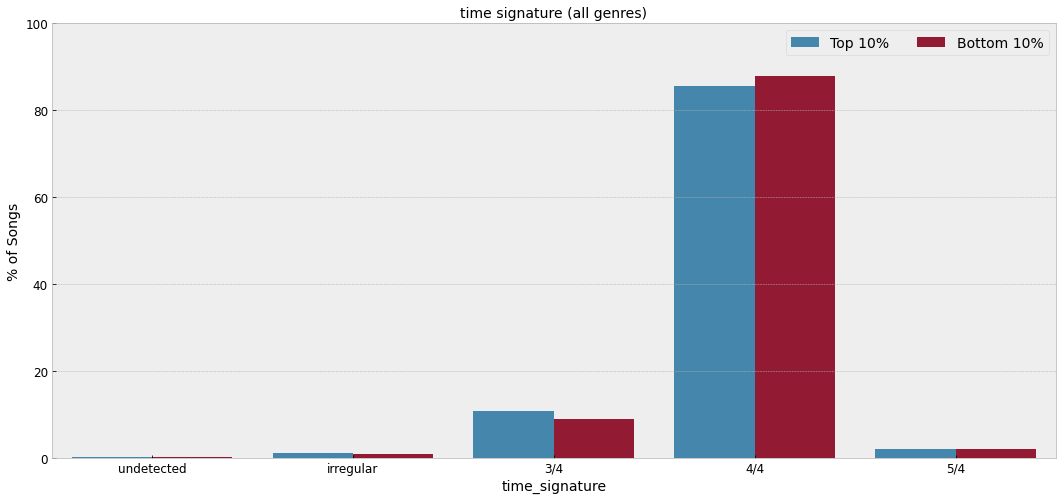

In [27]:
plot_cat_cols('time_signature', top_album_songs, bottom_album_songs, 
              title='time signature (all genres)', x_axis_labels=time_signature_labels, y_limit=100)

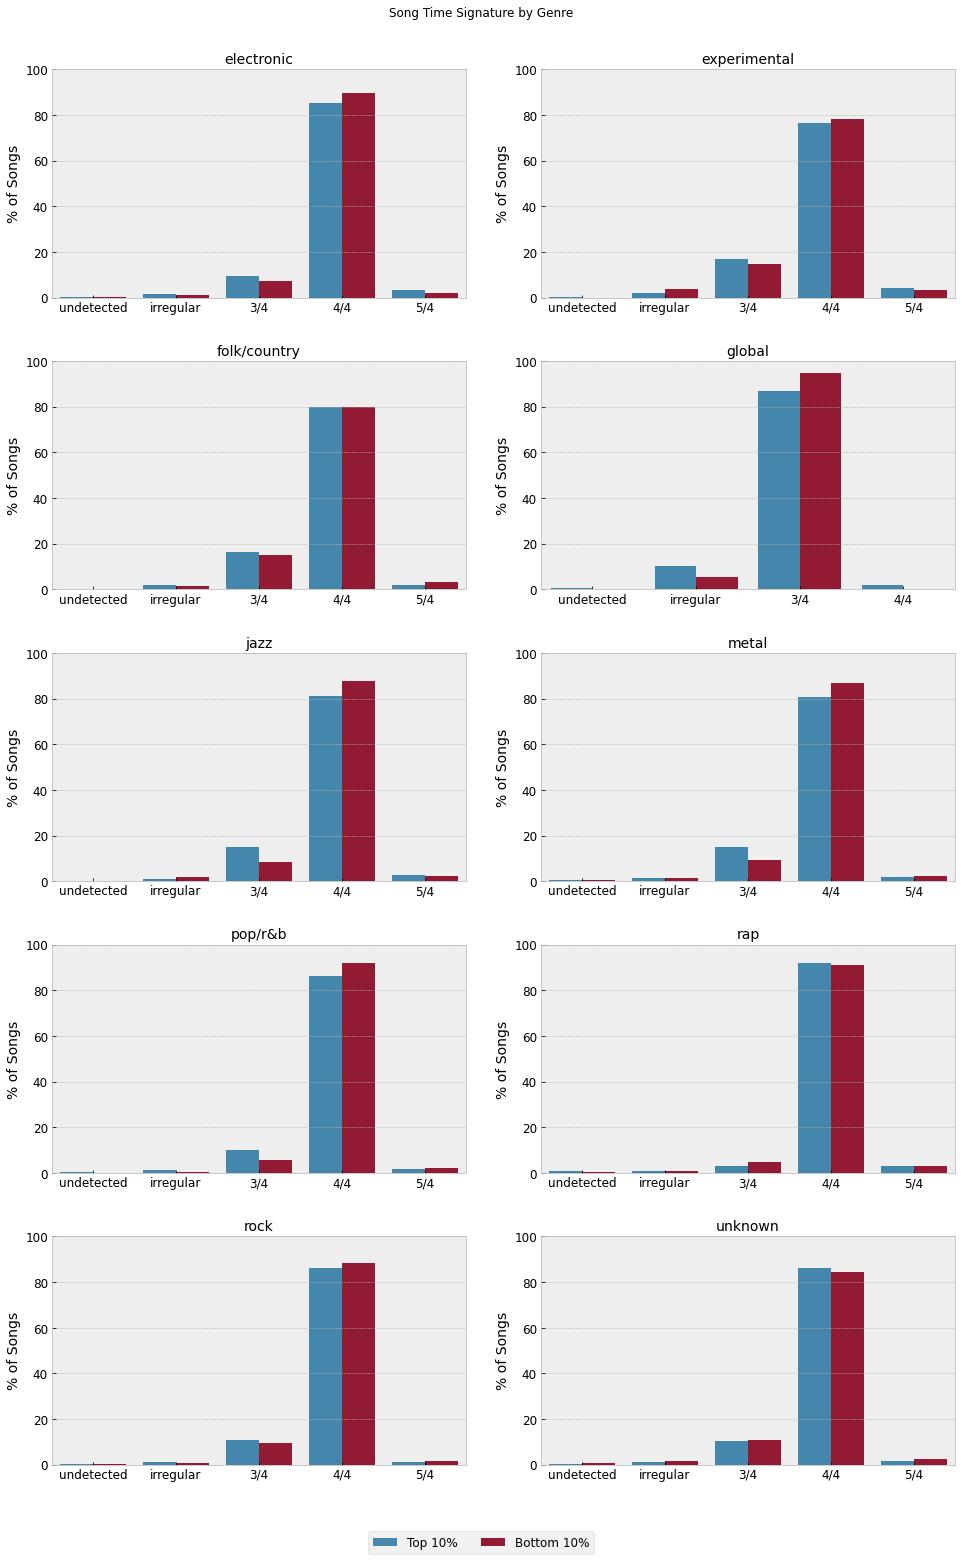

In [28]:
# fix global, it doesn't have any 0 values

plot_cat_grid('time_signature', top_album_songs, bottom_album_songs, 'Song Time Signature by Genre', time_signature_labels, y_limit=100)

### Explicit Status
Whether or not the track has explicit lyrics ( true = yes it does; false = no it does not OR unknown).

In [29]:
explicit_labels = ['not explicit', 'explicit']

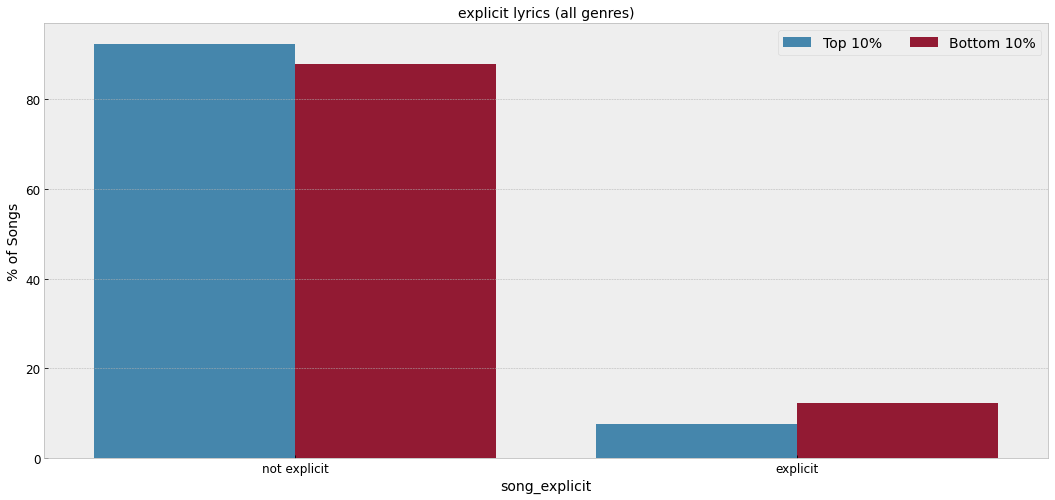

In [30]:
plot_cat_cols('song_explicit', top_album_songs, bottom_album_songs, 
              title='explicit lyrics (all genres)', x_axis_labels=explicit_labels)

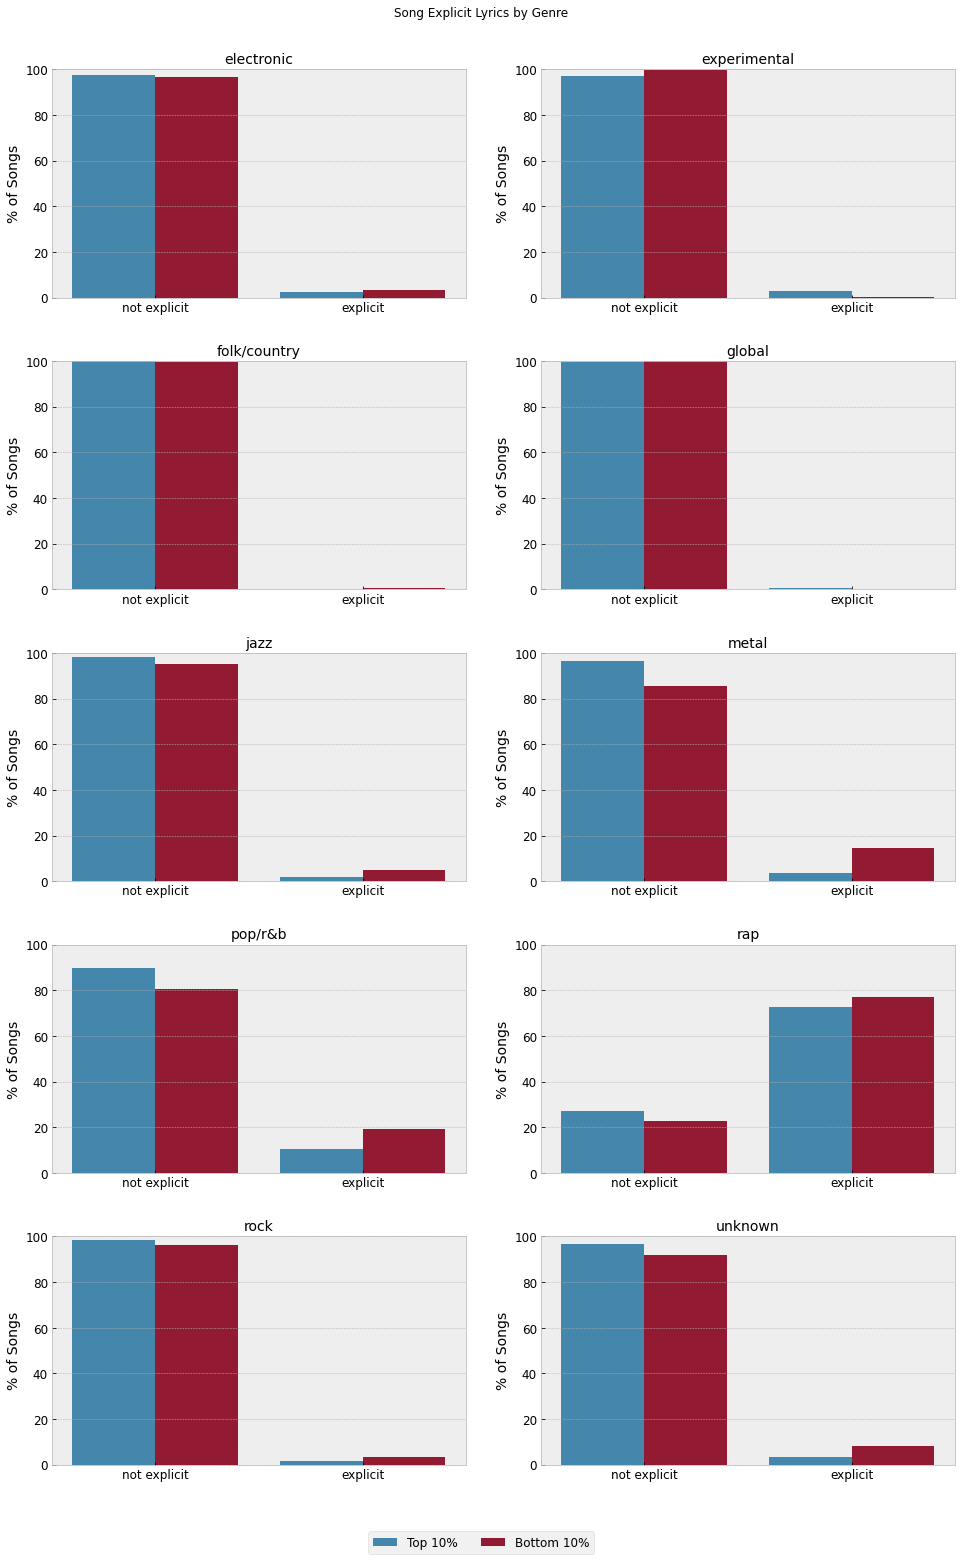

In [31]:
plot_cat_grid('song_explicit', top_album_songs, bottom_album_songs, 'Song Explicit Lyrics by Genre', explicit_labels, 100)

### Mode
Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

In [32]:
mode_labels = ['minor', 'major']

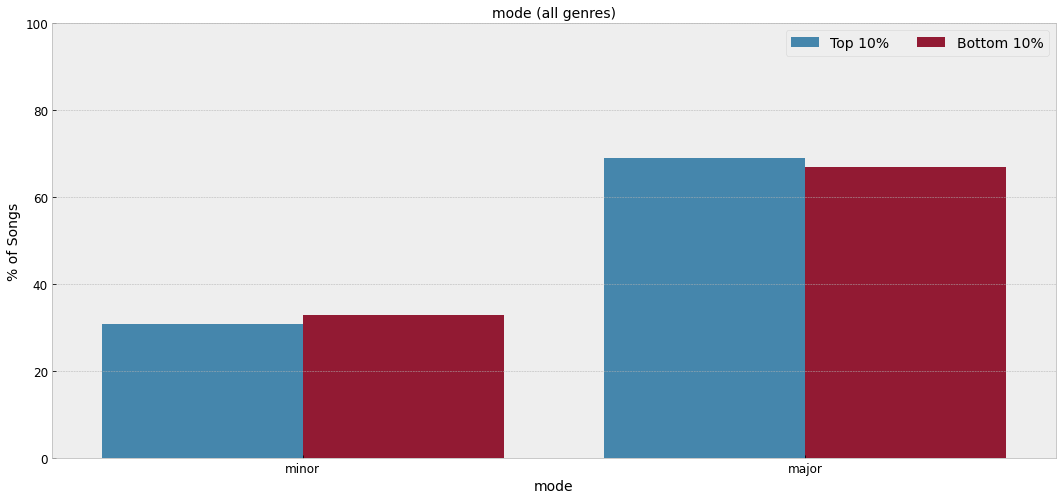

In [33]:
plot_cat_cols('mode', top_album_songs, bottom_album_songs, 
              title='mode (all genres)', x_axis_labels=mode_labels, y_limit=100, save=True, 
              save_title='mode_all_genres.png')

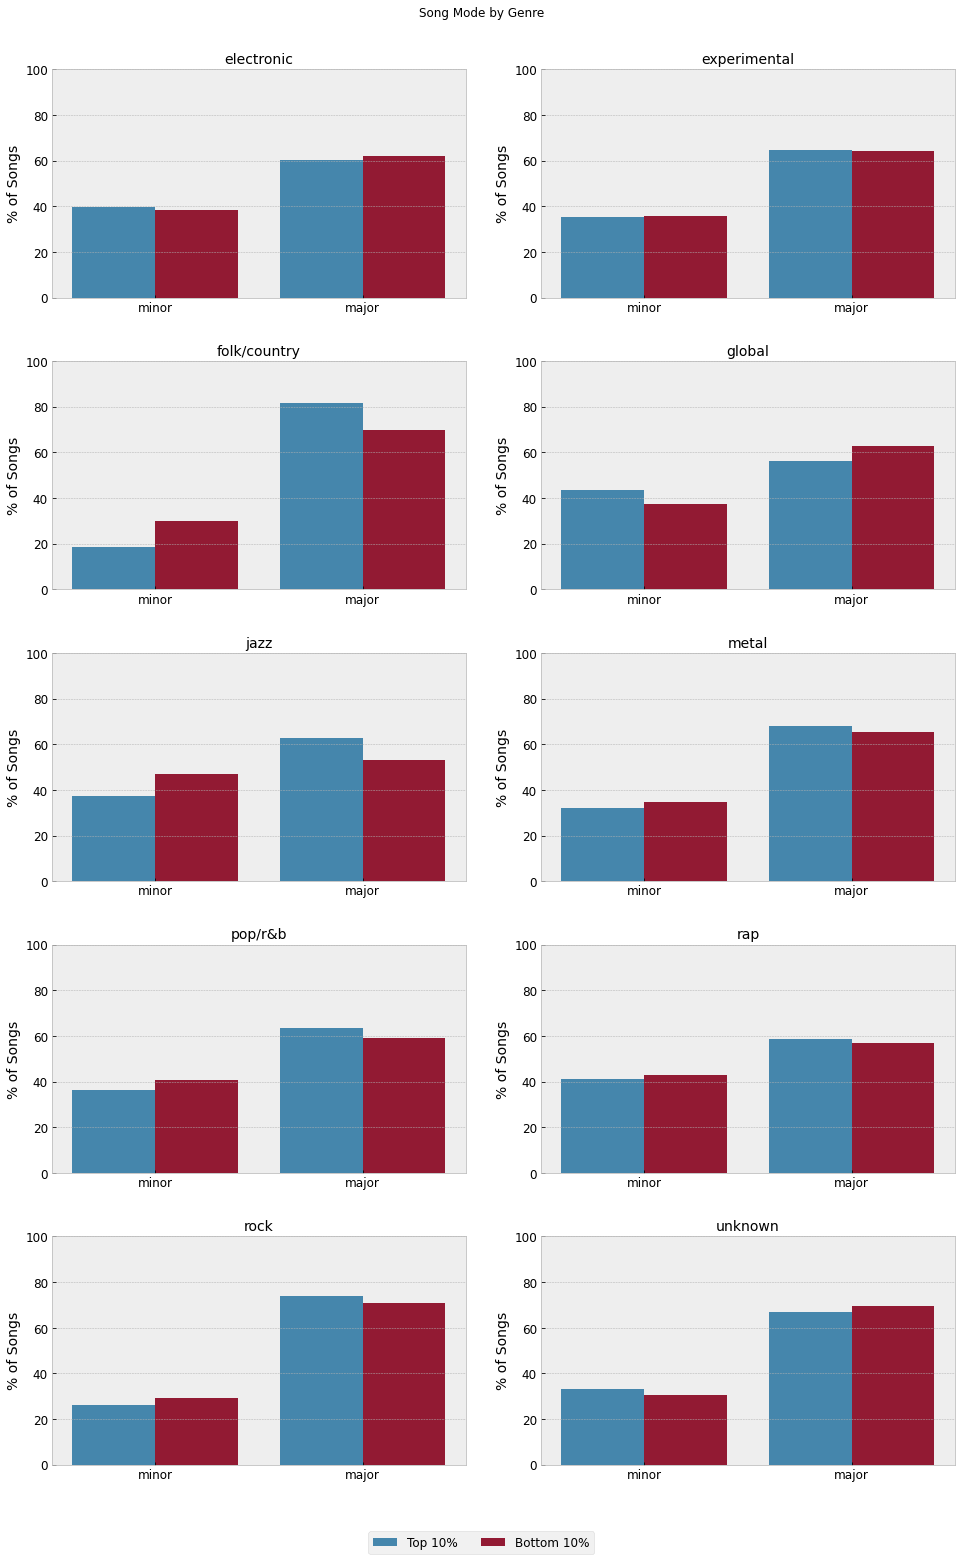

In [34]:
plot_cat_grid('mode', top_album_songs, bottom_album_songs, 'Song Mode by Genre', labels=mode_labels, y_limit=100)

### Key + Mode = Scale
Typically, the key and mode of a song are listed together to identify the scale upon which the song is constructed (i.e. C Major, Ab Minor, etc.). The Spotify API provides each of these pieces of information as separate variables. Combining them allows for identification of the scale providing the basis for each song. This is often simply referred to as the key of the song.

In [35]:
top_album_songs['scale'] = top_album_songs['key'].astype(str) + top_album_songs['mode'].astype(str)
bottom_album_songs['scale'] = bottom_album_songs['key'].astype(str) + bottom_album_songs['mode'].astype(str)

In [36]:
key_labels = ['C', 'C#/Db', 'D', 'D#/Eb', 'E', 'F', 'F#/Gb', 'G', 'G#/Ab', 'A', 'A#/Bb', 'B']

In [37]:
mode_labels = ['minor', 'major']

In [38]:
minor_key_labels = ['C minor', 'C#/Db minor', 'D minor', 'D#/Eb minor', 'E minor', 
                    'F minor', 'F#/Gb minor', 'G minor', 'G#/Ab minor', 'A minor', 
                    'A#/Bb minor', 'B minor']

In [39]:
major_key_labels = ['C major', 'C#/Db major', 'D major', 'D#/Eb major', 'E major', 
                    'F major', 'F#/Gb major', 'G major', 'G#/Ab major', 'A major', 
                    'A#/Bb major', 'B major']

In [40]:
scale_map = {'00': 'C minor', '01': 'C major', '10': 'C#/Db minor', '11': 'C#/Db major', 
             '20': 'D minor', '21': 'D major', '30': 'D#/Eb minor', '31': 'D#/Eb major',
             '40': 'E minor', '41': 'E major', '50': 'F minor', '51': 'F major', 
             '60': 'F#/Gb minor', '61': 'F#/Gb major', '70': 'G minor', '71': 'G major',
             '80': 'G#/Ab minor', '81': 'G#/Ab major', '90': 'A minor', '91': 'A major',
             '100': 'A#/Bb minor', '101': 'A#/Bb major', '110': 'B minor', '111': 'B major'}

### Minor Keys

In [41]:
top_minor_songs = top_album_songs.loc[top_album_songs['mode'] == 0]
bottom_minor_songs = bottom_album_songs.loc[bottom_album_songs['mode'] == 0]

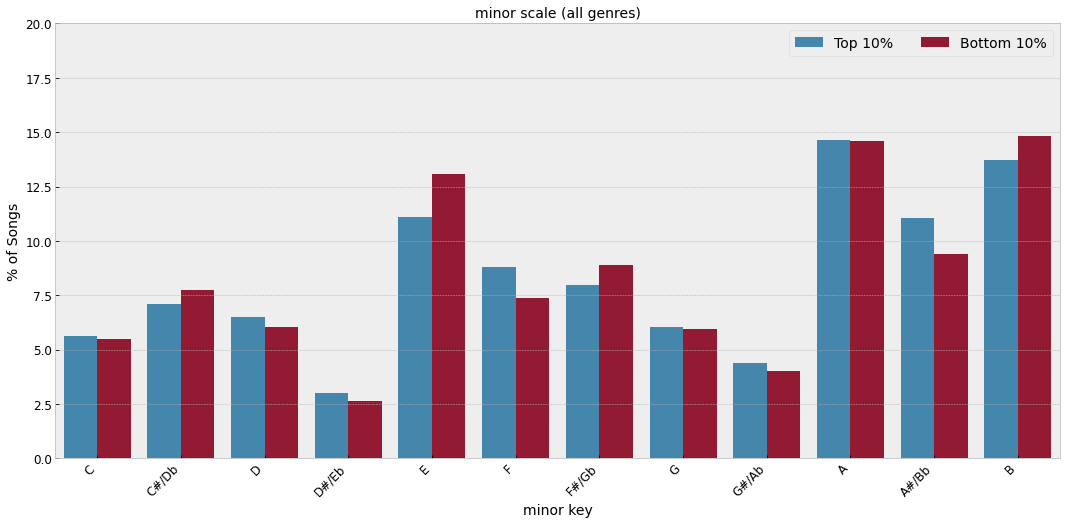

In [42]:
plot_cat_cols('key', top_minor_songs, bottom_minor_songs, 
              title='minor scale (all genres)', x_axis_labels=key_labels, y_limit=20, rotate_x=True, x_label='minor key')

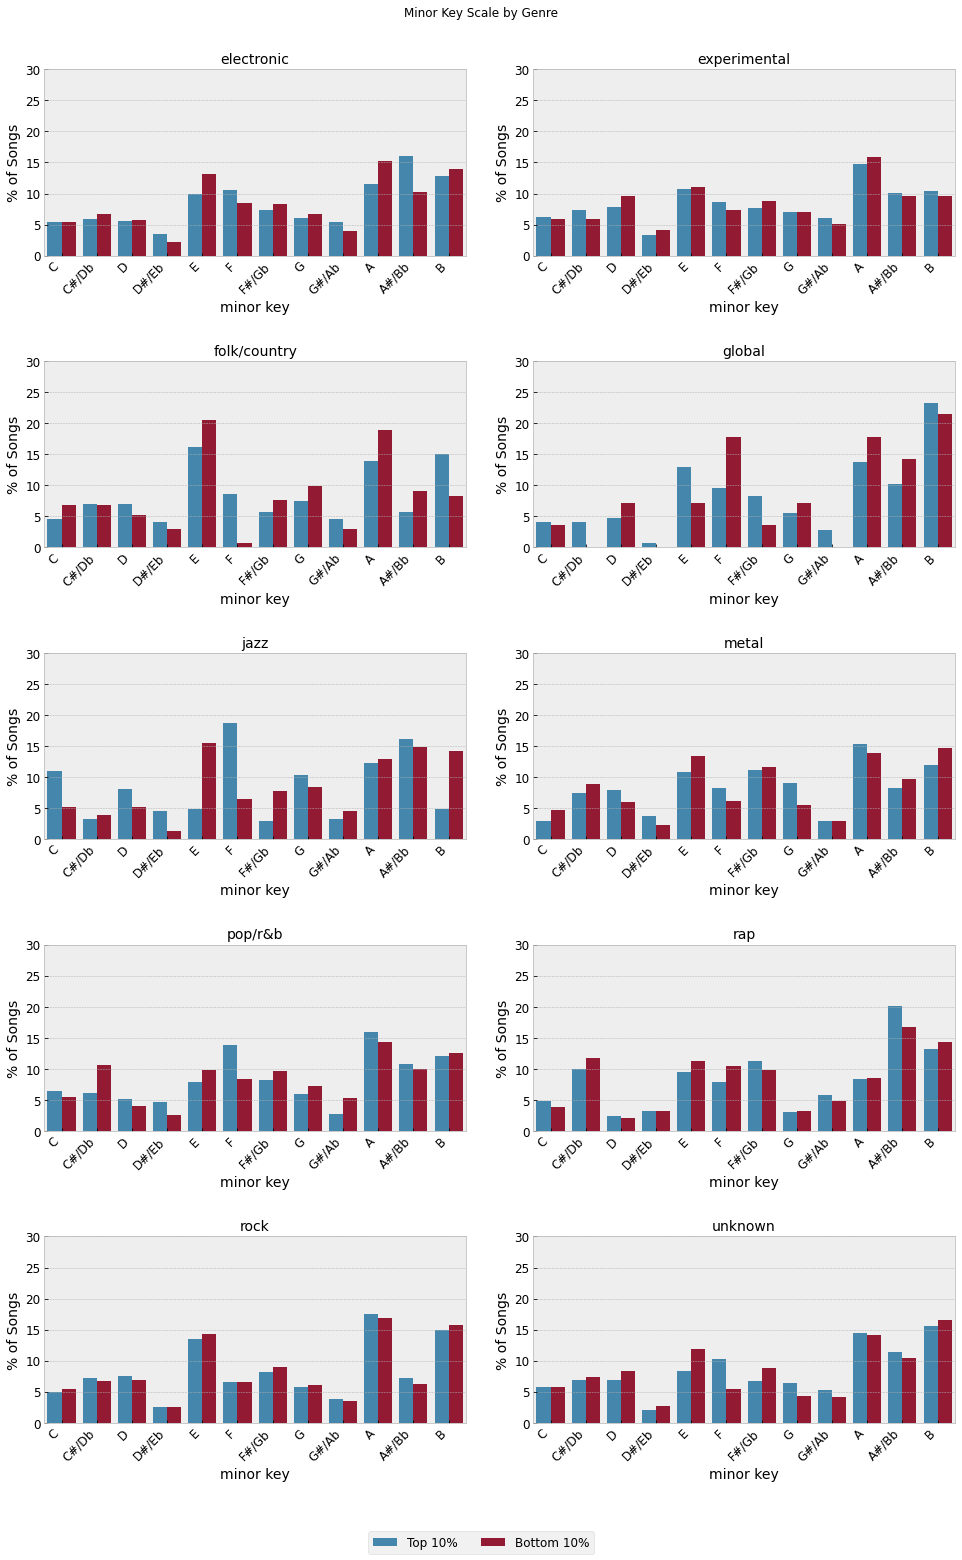

In [43]:
plot_cat_grid('key', top_minor_songs, bottom_minor_songs, 'Minor Key Scale by Genre', 
              labels=key_labels, y_limit=30, rotate_x=True, x_label='minor key')

### Major Keys

In [44]:
top_major_songs = top_album_songs.loc[top_album_songs['mode'] == 1]
bottom_major_songs = bottom_album_songs.loc[bottom_album_songs['mode'] == 1]

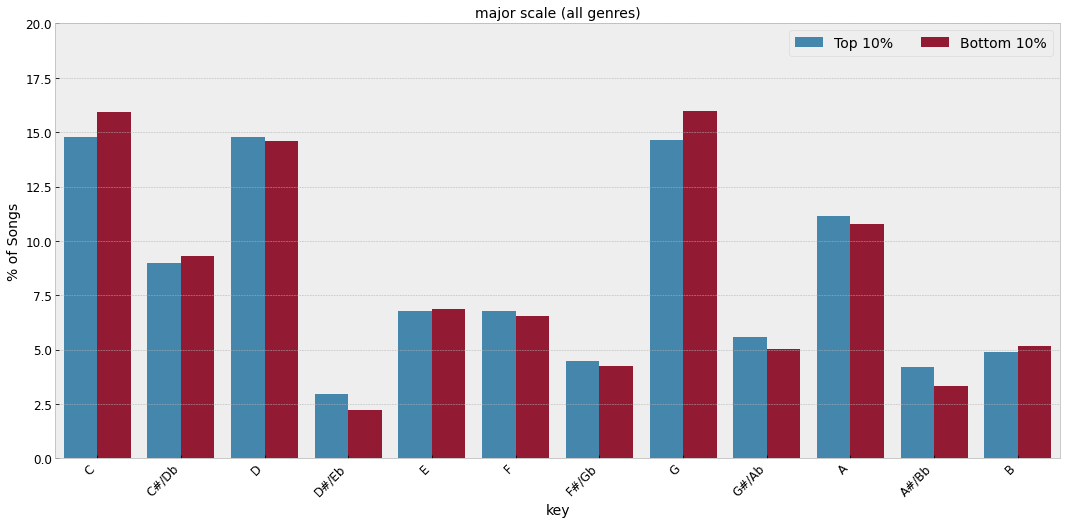

In [45]:
plot_cat_cols('key', top_major_songs, bottom_major_songs, 
              title='major scale (all genres)', x_axis_labels=key_labels, y_limit=20, rotate_x=True)

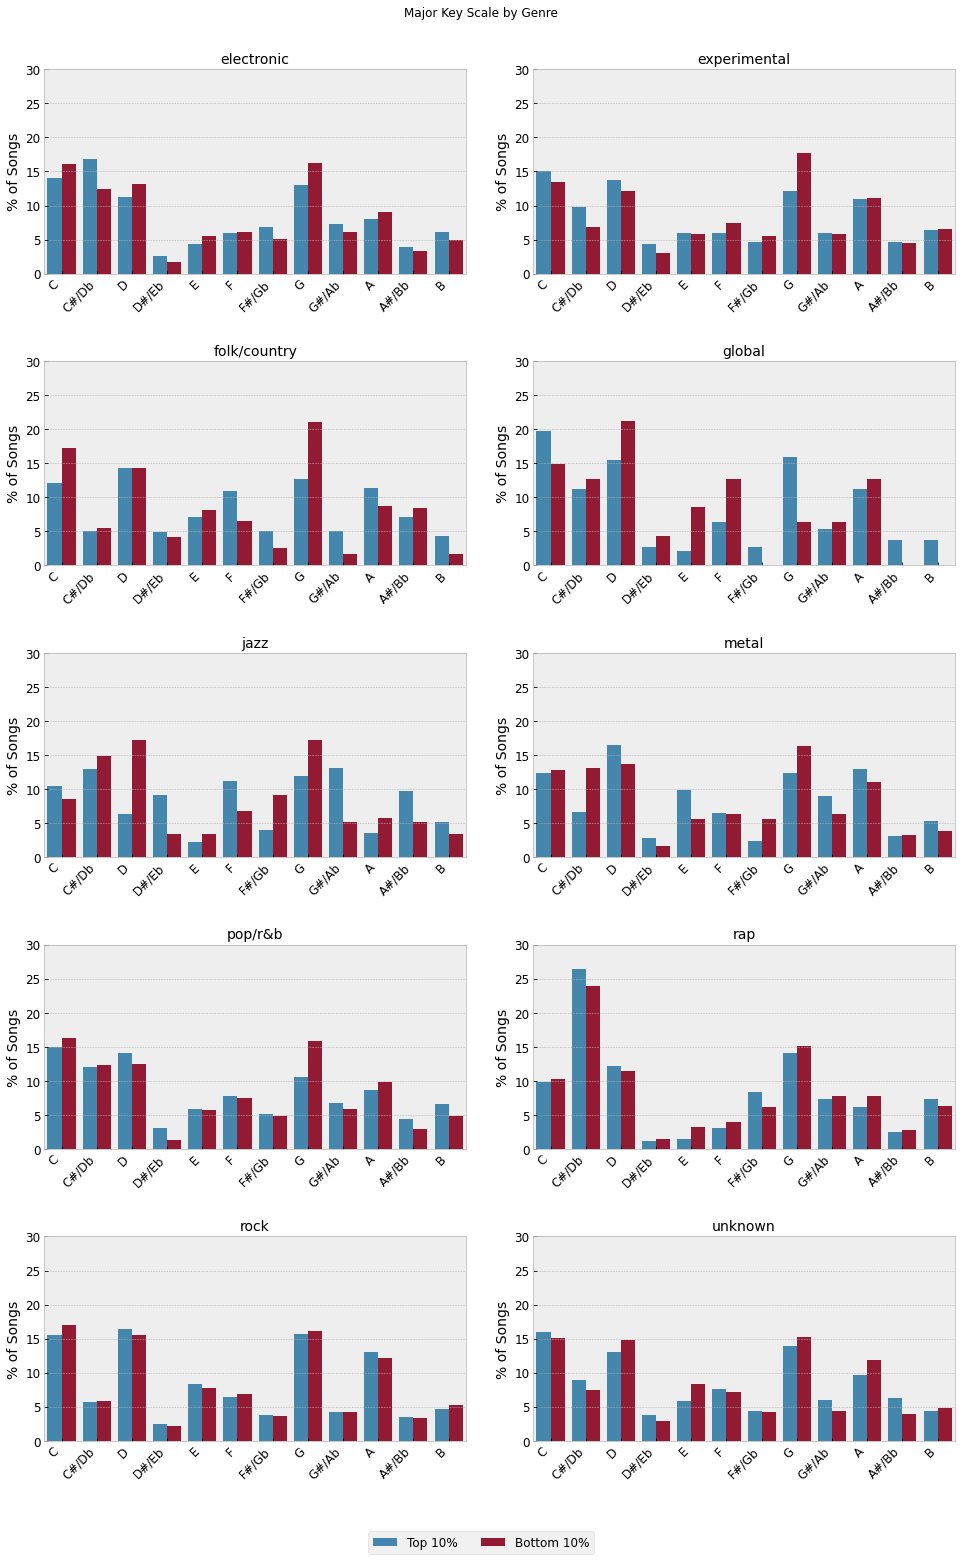

In [46]:
plot_cat_grid('key', top_major_songs, bottom_major_songs, 'Major Key Scale by Genre', 
              labels=key_labels, y_limit=30, rotate_x=True)

In [47]:
scale_index = ['00', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100', '110',
               '01', '11', '21', '31', '41', '51', '61', '71', '81', '91', '101', '111']

In [48]:
def plot_scales(upper_df, lower_df, title='', save=False, save_title=''):
    top_scales = upper_df.scale.value_counts()/len(upper_df)
    bottom_scales = lower_df.scale.value_counts()/len(lower_df)

    top_scales = top_scales.reindex(index=scale_index)
    bottom_scales = bottom_scales.reindex(index=scale_index)

#     iterables = [key_labels, mode_labels]
#     scale_multiindex = pd.MultiIndex.from_product(iterables, names=['key', 'mode'])

    scale_index_renamed = [scale_map.get(item, item) for item in scale_index]

    scale_df = pd.DataFrame(list(zip(top_scales, bottom_scales)), columns=['Top 10%', 'Bottom 10%'], index=scale_index_renamed)

    fig, ax = plt.subplots(figsize=(18,12))
    scale_df.plot(kind='barh', ax=ax)
    plt.title(title, fontsize=14)
    plt.xlabel('Proportion of Songs Within Subset', fontsize=14)
    plt.ylabel('Scale (Key, + Mode)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    if save:
        plt.savefig('images/' + save_title)
    plt.show()

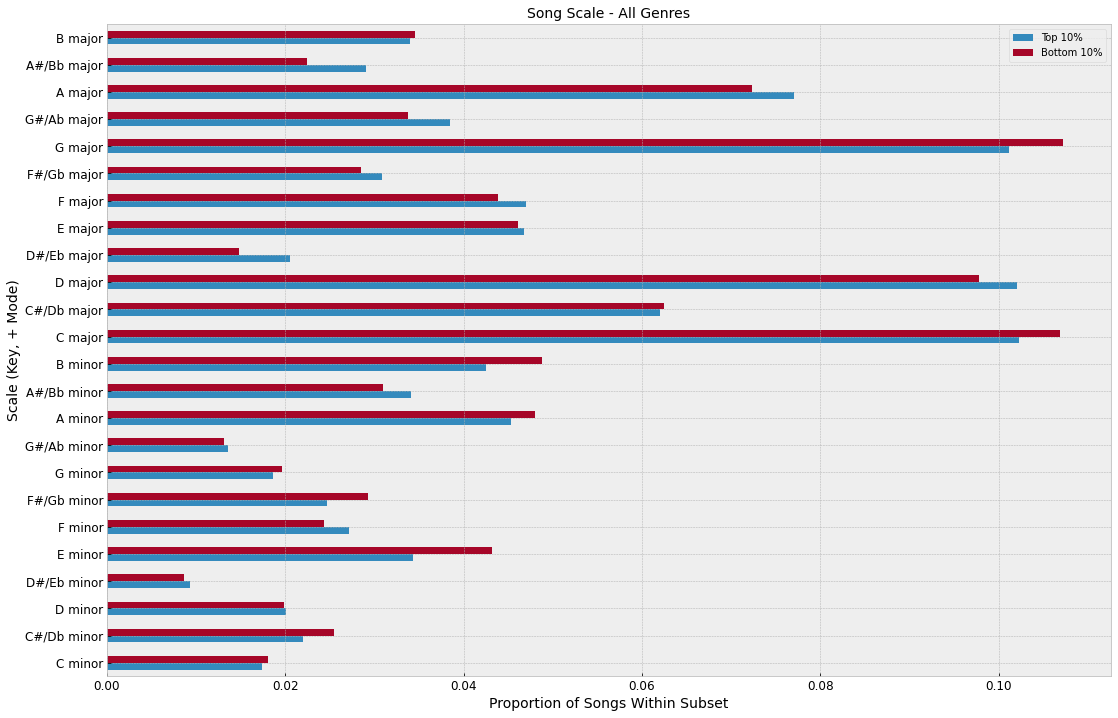

In [49]:
plot_scales(top_album_songs, bottom_album_songs, title='Song Scale - All Genres', save=True, save_title='song_scales.png')

In [50]:
top_scales = top_album_songs.scale.value_counts()
bottom_scales = bottom_album_songs.scale.value_counts()

top_scales = top_scales.reindex(index=scale_index)
bottom_scales = bottom_scales.reindex(index=scale_index)

combined_scales = (top_scales + bottom_scales)/(len(top_album_songs) + len(bottom_album_songs))
combined_scales.sort_values(ascending=False)

01     0.104316
71     0.103857
21     0.100142
91     0.074948
11     0.062231
90     0.046498
41     0.046477
51     0.045559
110    0.045275
40     0.038261
81     0.036360
111    0.034240
100    0.032711
61     0.029783
60     0.026702
101    0.026046
50     0.025893
10     0.023511
20     0.019972
70     0.019098
31     0.017983
00     0.017699
80     0.013395
30     0.009046
Name: scale, dtype: float64

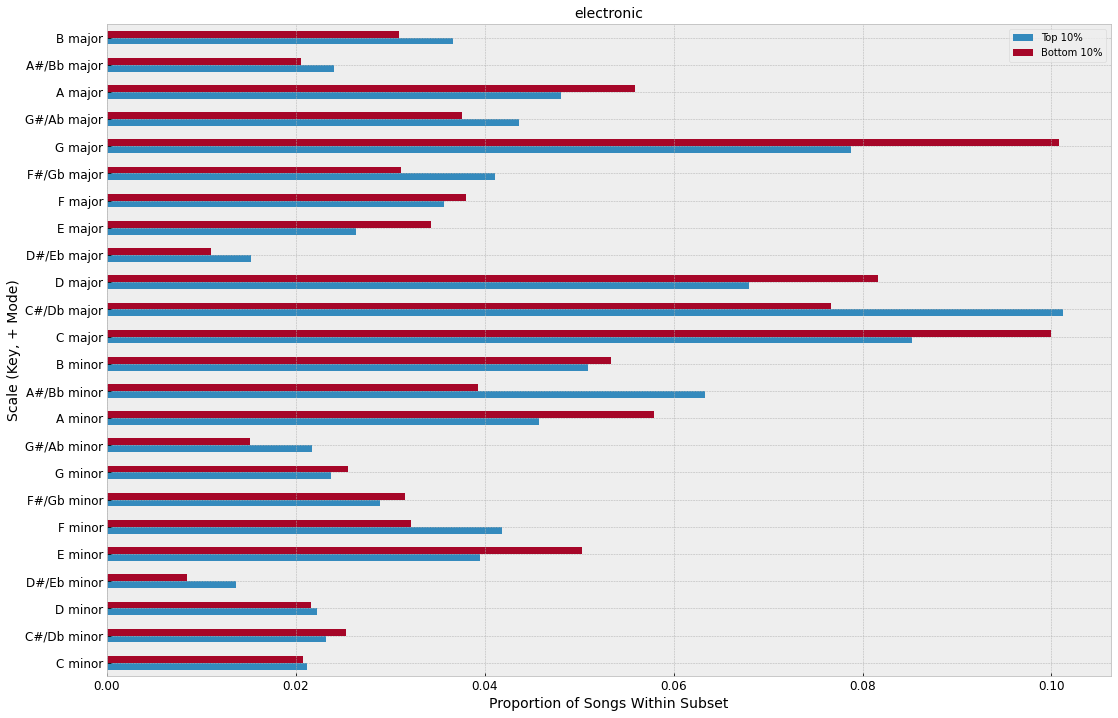

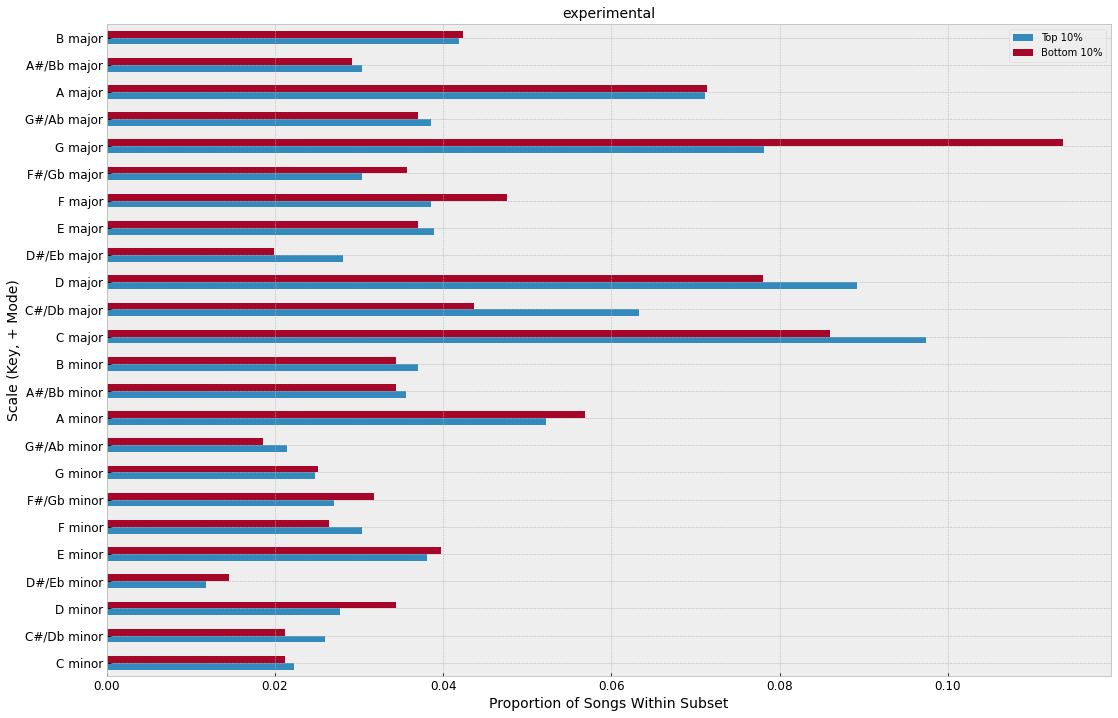

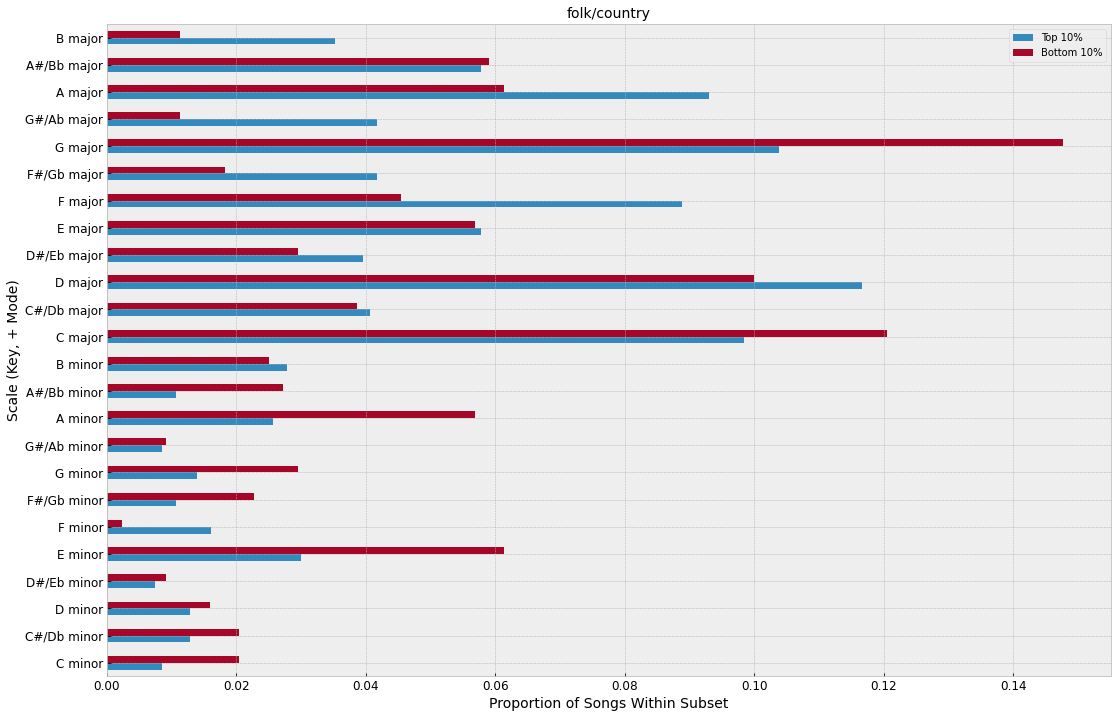

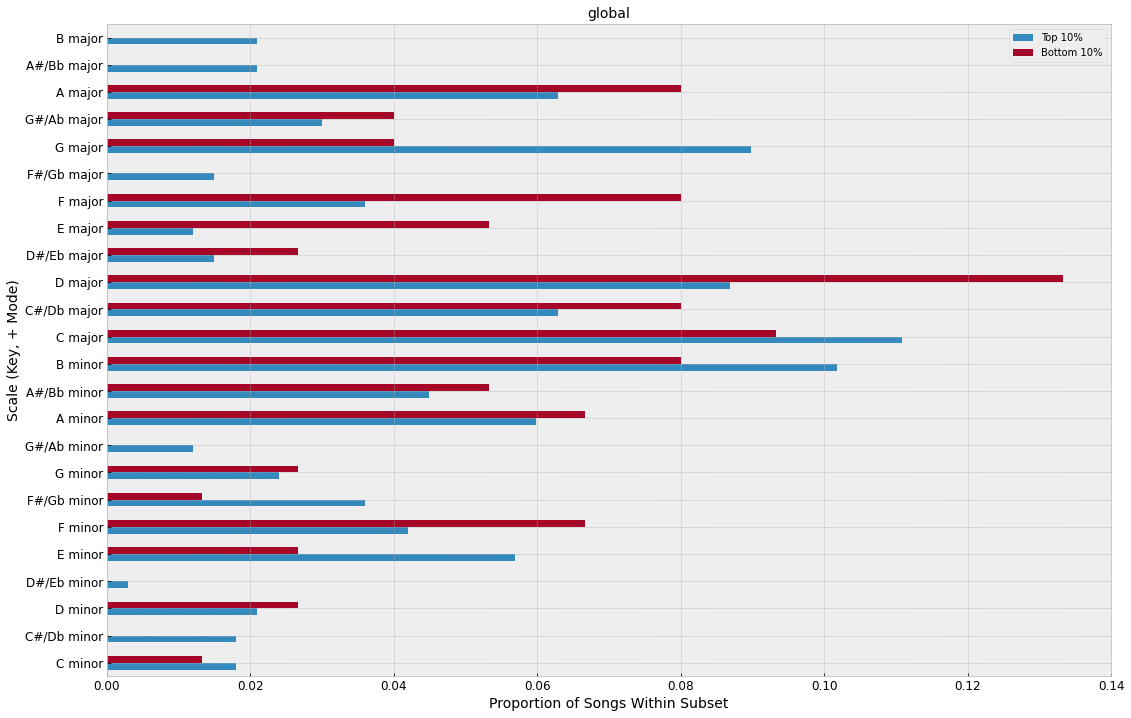

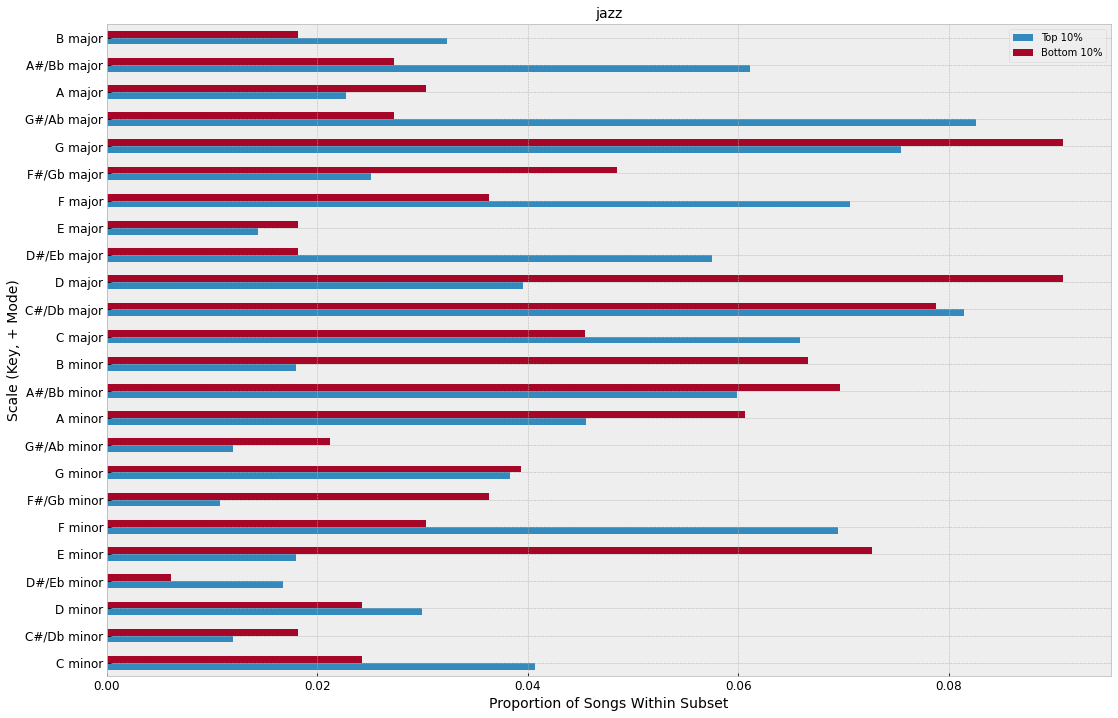

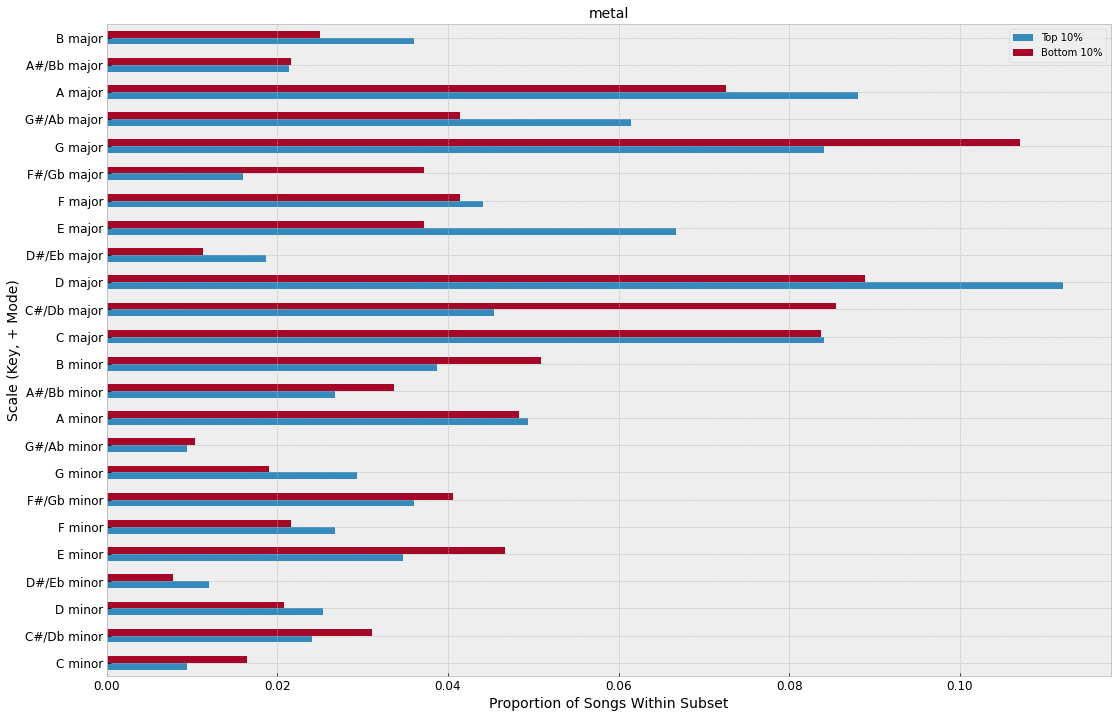

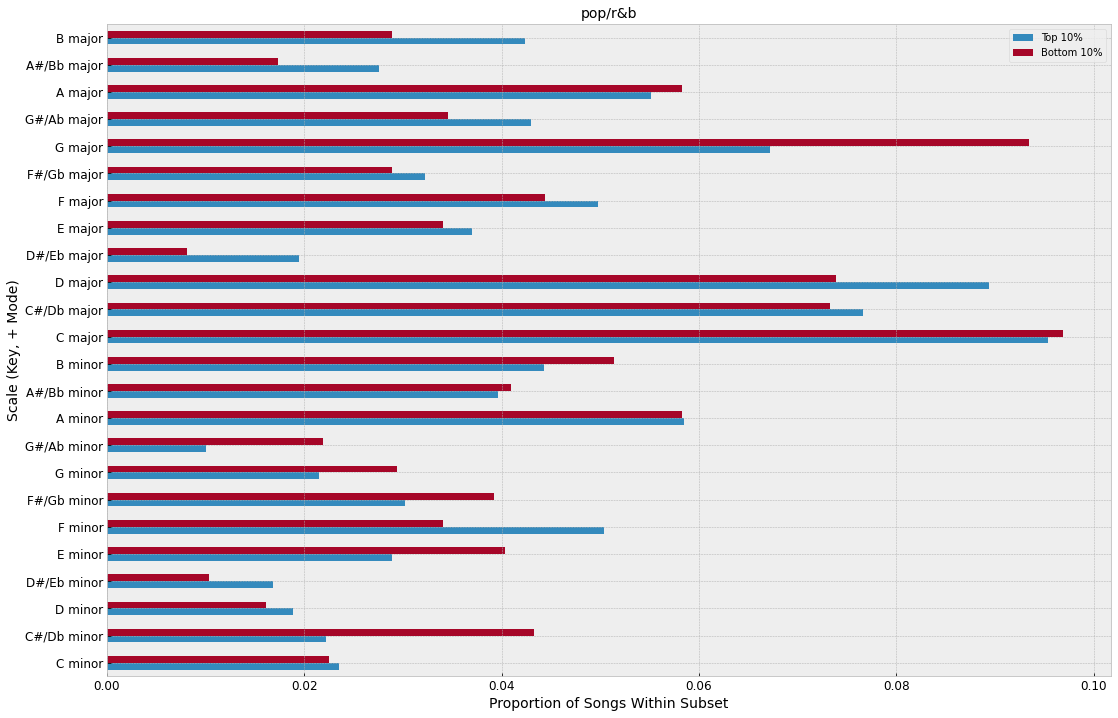

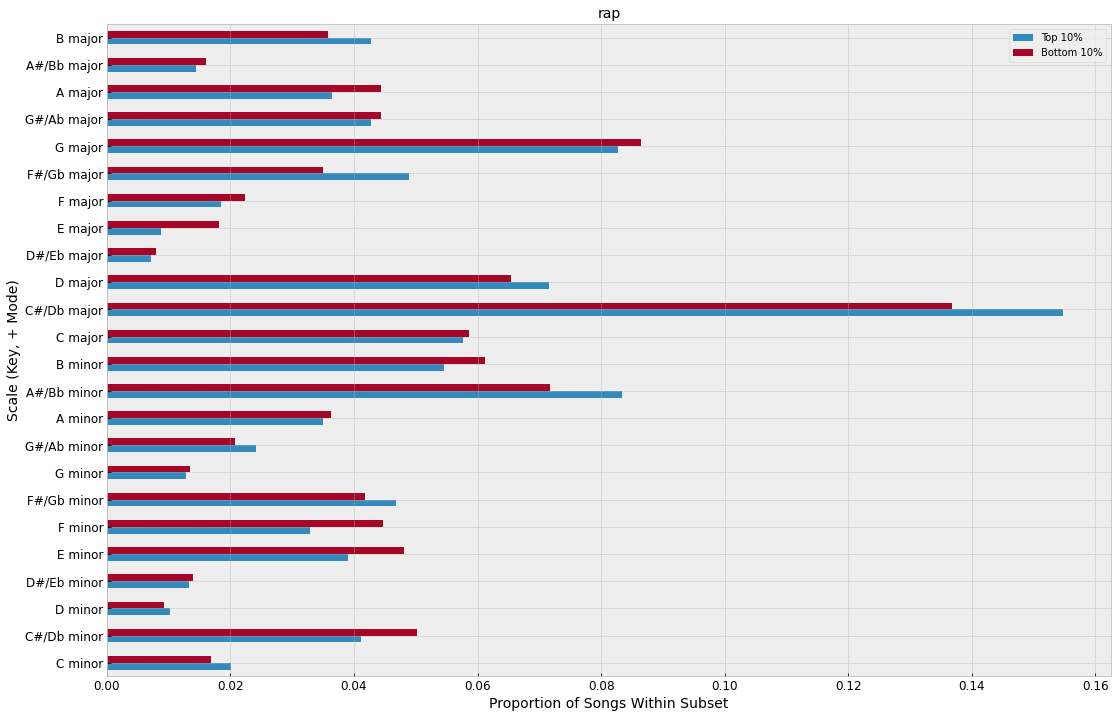

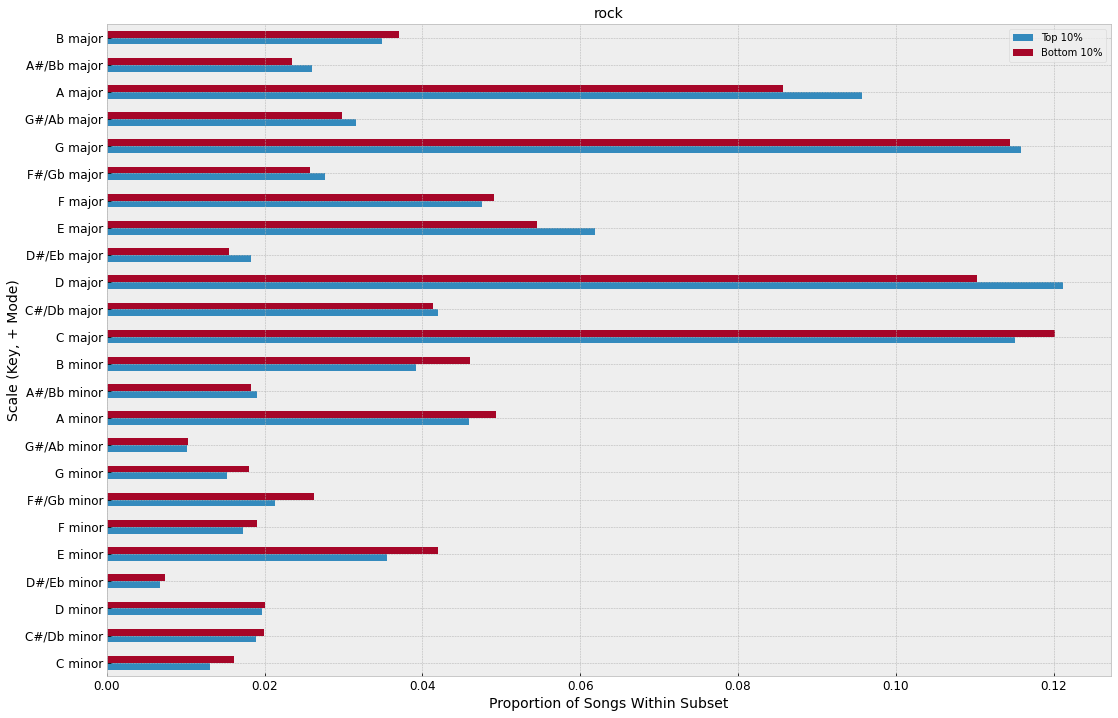

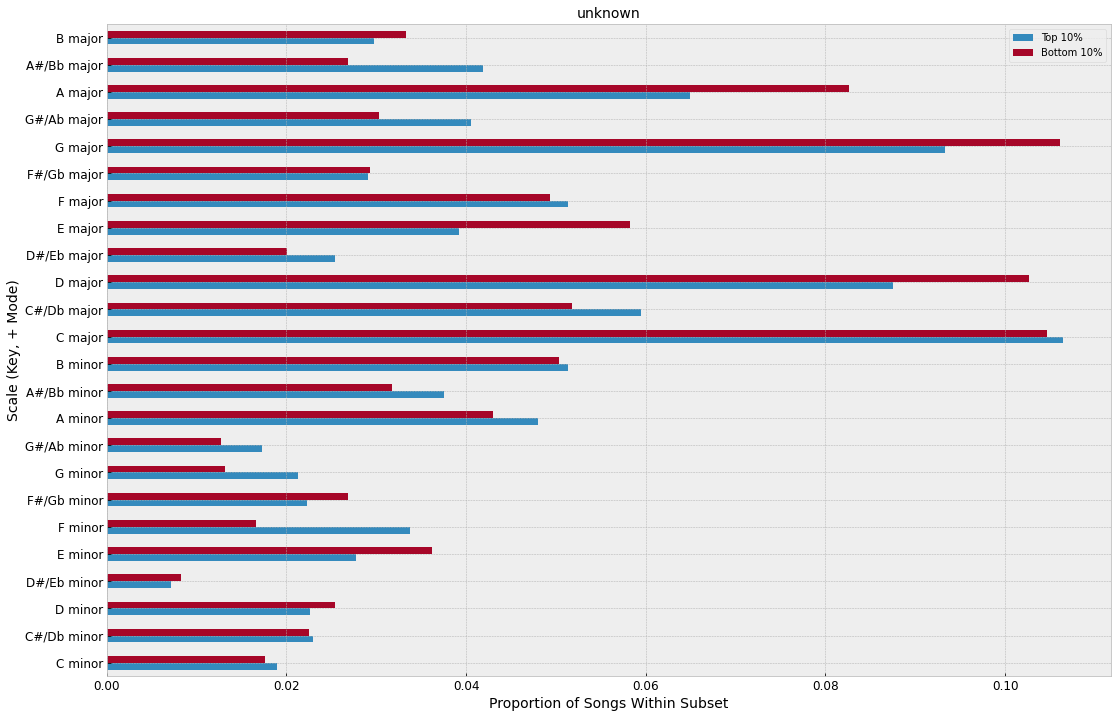

In [51]:
for genre in genre_cols:
    top_genre_df = top_album_songs.loc[top_album_songs[genre] == 1]
    bottom_genre_df = bottom_album_songs.loc[bottom_album_songs[genre] == 1]
    
    if genre == 'folk/country':
        save_title = 'folk_country_song_scales.png'
    elif genre == 'pop/r&b':
        save_title = 'pop_rb_song_scales.png'
    else:
        save_title = genre + '_song_scales.png'
    
    plot_scales(top_genre_df, bottom_genre_df, title=genre, save=True, save_title=save_title)

# Top vs. Bottom 10% Albums:  Numerical Variables

Numerical song data includes the following variables:
* Song Duration (ms) 
* Acousticness (scale of 0.0 - 1.0)
* Danceability (scale of 0.0 - 1.0)
* Energy (scale of 0.0 - 1.0)
* Instrumentalness (scale of 0.0 - 1.0)
* Liveness (scale of 0.0 - 1.0)
* Tempo (bpm)
* Valence (scale of 0.0 - 1.0)
* Popularity (scale of 0 - 100)

In [52]:
def plot_numeric_col(col, upper_df, lower_df, title=None, axis=None, x_limit=None, show_outliers=True, 
                     save=False, save_title=None, x_label = ''):
    top_df = upper_df.loc[:, [col]]
    top_df['album_category'] = 'Top 10%'
    bottom_df = lower_df.loc[:, [col]]
    bottom_df['album_category'] = 'Bottom 10%'
    combined_df = pd.concat([top_df, bottom_df])
    
    if axis != None:
        sns.boxplot(data=combined_df, y='album_category', x=col, ax=axis, showfliers=show_outliers)
        axis.set_xlabel(x_label, fontsize=14)
        axis.set_ylabel('')
        axis.tick_params(axis='both', which='major', labelsize=12)
        axis.set_title(title, fontsize=14)
        if x_limit != None:
            axis.set_xlim(0, x_limit)
        axis.xaxis.get_offset_text().set_fontsize(12)
            
    else:
        fig, ax = plt.subplots(figsize=(18,8))
        sns.boxplot(data=combined_df, y='album_category', x=col, showfliers=show_outliers)
        ax.set_xlabel(col, fontsize=14)
        ax.set_ylabel('') 
        ax.tick_params(axis='both', which='major', labelsize=12)
        if x_limit != None:
            ax.set_xlim(0, x_limit)
        ax.xaxis.get_offset_text().set_fontsize(12)
    plt.yticks(fontsize=12)
    plt.title(title, fontsize=14)
    if save:
        plt.savefig('images/' + save_title)
    

In [53]:
def plot_numeric_grid(num_var, upper_df, lower_df, title, x_limit=None, show_outliers=True, x_label=''):
    fig, axs = plt.subplots(5,2, figsize=(14,18))
    genre_counter = 0

    for row in range(5):
        for col in range(2):
            genre = genre_cols[genre_counter]
            top_genre_df = upper_df.loc[upper_df[genre] == 1]
            bottom_genre_df = lower_df.loc[lower_df[genre] == 1]
            plot_numeric_col(num_var, top_genre_df, bottom_genre_df, 
                             title=genre, axis=axs[row,col], x_limit=x_limit, 
                             show_outliers=show_outliers, x_label=x_label)
            genre_counter += 1
    
    fig.tight_layout(pad=3, rect=[0, 0.03, 1, 0.97])
    plt.suptitle(title, fontsize=12)

In [54]:
def plot_histogram(num_var, upper_df, lower_df, title, save=False, save_title=None):
    fig, ax = plt.subplots(figsize=(18,8))
    sns.distplot(upper_df[num_var], norm_hist=False, kde=False, label='Top 10%')
    sns.distplot(lower_df[num_var], norm_hist=False, kde=False, label='Bottom 10%')
    plt.ylabel('# of Songs')
    plt.legend(loc='upper left')
    plt.title(title)
    if save:
        plt.savefig('images/' + save_title)
    plt.show()

In [55]:
def var_comparison(num_var, upper_df, lower_df):
    u_value, p_value = mannwhitneyu(upper_df[num_var], lower_df[num_var])
    
    p_value = round(p_value, 3)

    # Calculate common langauge effect size
    com_lang_eff_size = round(u_value / (len(upper_df)*len(lower_df)), 3)
    
    top_quantiles = upper_df[num_var].quantile([0.25, 0.5, 0.75])
    bottom_quantiles = lower_df[num_var].quantile([0.25, 0.5, 0.75])
    
    top_outliers = len(np.where(np.abs(zscore(upper_df[num_var]) > 3))[0])
    bottom_outliers = len(np.where(np.abs(zscore(lower_df[num_var]) > 3))[0])
    
#     top_med_quar = str(top_quantiles[0.5]) + ' [' + str(top_quantiles[0.25]) + ' - ' + str(top_quantiles[0.75]) + ']'
#     bottom_med_quar = str(bottom_quantiles[0.5]) + ' [' + str(bottom_quantiles[0.25]) + ' - ' + str(bottom_quantiles[0.75]) + ']' 

    sig_value = False
    if p_value < 0.05:
        sig_value = True
    
    print('N1 (Top 10%):', len(upper_df))
    print('N2 (Bottom 10%):', len(lower_df))
    print('U-value: ', u_value)
    print('p-value: ', p_value)
    print('Significant: ', sig_value)
    print('Common Language Effect Size: ', com_lang_eff_size)
    print('Top 10% Median: ', top_quantiles[0.5])
    print('Bottom 10% Median: ', bottom_quantiles[0.5])
    print('Number of Outliers (Top 10%): ', top_outliers)
    print('Number of Outliers (Bottom 10%): ', bottom_outliers)

In [56]:
def color_sig_green(s, column):
    is_sig = pd.Series(data=False, index=s.index) 
    is_sig[column] = s.loc[column]
    return ['background-color: honeydew' if is_sig.any() else 'background-color: mistyrose' for v in is_sig]

def genre_comparison(num_var, upper_df, lower_df, caption_text=''):
    return_df = pd.DataFrame(columns=['Genre', 'Top 10% Count', 'Bottom 10% Count', 'U', 'p', 
                                      'Sig?', 'CL', 'Top 10% Median', 
                                      'Bottom 10% Median', 'Top 10% Outliers', 'Bottom 10% Outliers'])
    
    for genre_index in range(len(genre_cols)):
        genre = genre_cols[genre_index]
        top_genre_df = upper_df.loc[upper_df[genre] == 1]
        bottom_genre_df = lower_df.loc[lower_df[genre] == 1]
        
        u_value, p_value = mannwhitneyu(top_genre_df[num_var], bottom_genre_df[num_var])
        
        # Calculate common langauge effect size
        com_lang_eff_size = u_value / (len(top_genre_df)*len(bottom_genre_df))
        
        top_quantiles = top_genre_df[num_var].quantile([0.25, 0.5, 0.75])
        bottom_quantiles = bottom_genre_df[num_var].quantile([0.25, 0.5, 0.75])
        
        top_outliers = len(np.where(np.abs(zscore(top_genre_df[num_var]) > 3))[0])
        bottom_outliers = len(np.where(np.abs(zscore(bottom_genre_df[num_var]) > 3))[0])
        
#         top_med_quar = str(top_quantiles[0.5]) + ' [' + str(top_quantiles[0.25]) + ' - ' + str(top_quantiles[0.75]) + ']'
#         bottom_med_quar = str(bottom_quantiles[0.5]) + ' [' + str(bottom_quantiles[0.25]) + ' - ' + str(bottom_quantiles[0.75]) + ']'
    
        sig_value = False
        if p_value < 0.05:
            sig_value = True
            
              
        return_df.loc[len(return_df)] = [genre, len(top_genre_df), len(bottom_genre_df), u_value.astype(np.int64), 
                                         p_value, sig_value, 
                                         '{:.3f}'.format(round(com_lang_eff_size, 3)), 
                                         '{:.2f}'.format(round(top_quantiles[0.5], 2)), 
                                         '{:.2f}'.format(round(bottom_quantiles[0.5], 2)),
                                         top_outliers, bottom_outliers]

    caption_props = [('text-align', 'center'), ('font-size', '125%')]
        
    return return_df.style.apply(color_sig_green, column='Sig?', axis=1).\
                     set_caption(caption_text).\
                     set_table_styles([dict(selector='caption', props=caption_props)])
    

### Song Duration

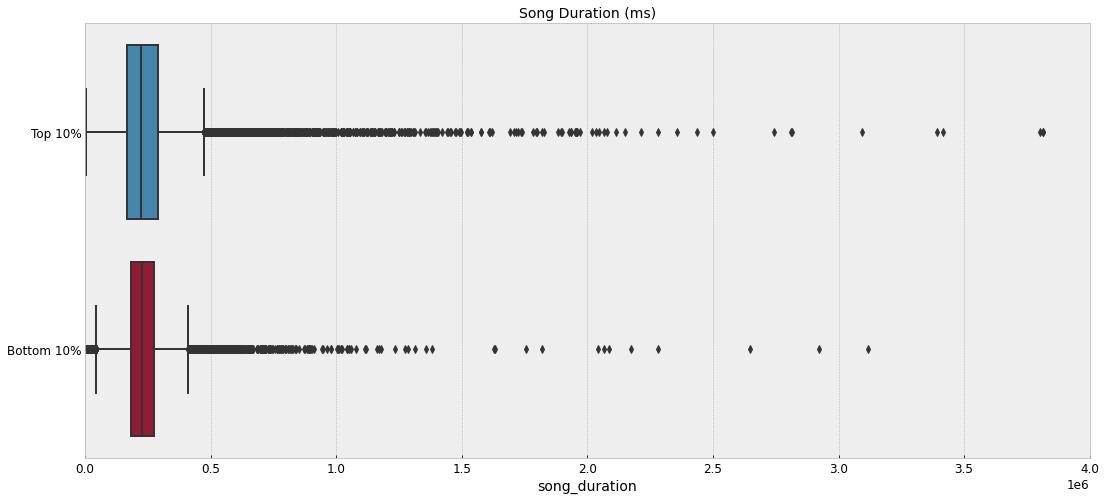

In [57]:
plot_numeric_col('song_duration', top_album_songs, bottom_album_songs, 'Song Duration (ms)',
                 x_limit=4000000, show_outliers=True)

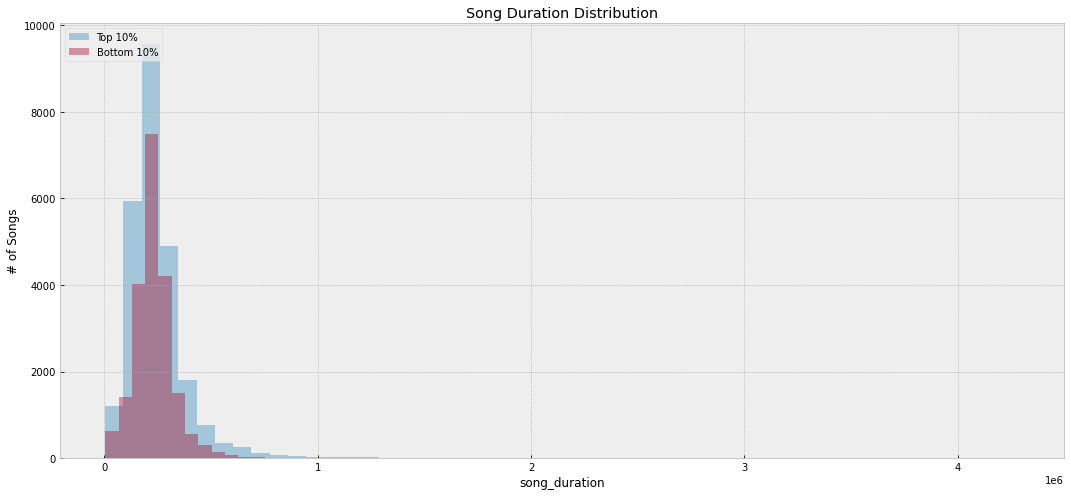

In [58]:
plot_histogram('song_duration', top_album_songs, bottom_album_songs, 'Song Duration Distribution')

In [59]:
var_comparison('song_duration', top_album_songs, bottom_album_songs)

N1 (Top 10%): 25270
N2 (Bottom 10%): 20495
U-value:  258836697.5
p-value:  0.467
Significant:  False
Common Language Effect Size:  0.5
Top 10% Median:  221786.5
Bottom 10% Median:  225520.0
Number of Outliers (Top 10%):  366
Number of Outliers (Bottom 10%):  217


In [60]:
print('Top 10% Outlier Duration Threshold: ', 3 * top_album_songs['song_duration'].std() + top_album_songs['song_duration'].mean())
print('Bottom 10% Outlier Duration Threshold: ', 3 * bottom_album_songs['song_duration'].std() + top_album_songs['song_duration'].mean())

Top 10% Outlier Duration Threshold:  767150.5372405997
Bottom 10% Outlier Duration Threshold:  584020.3210973439


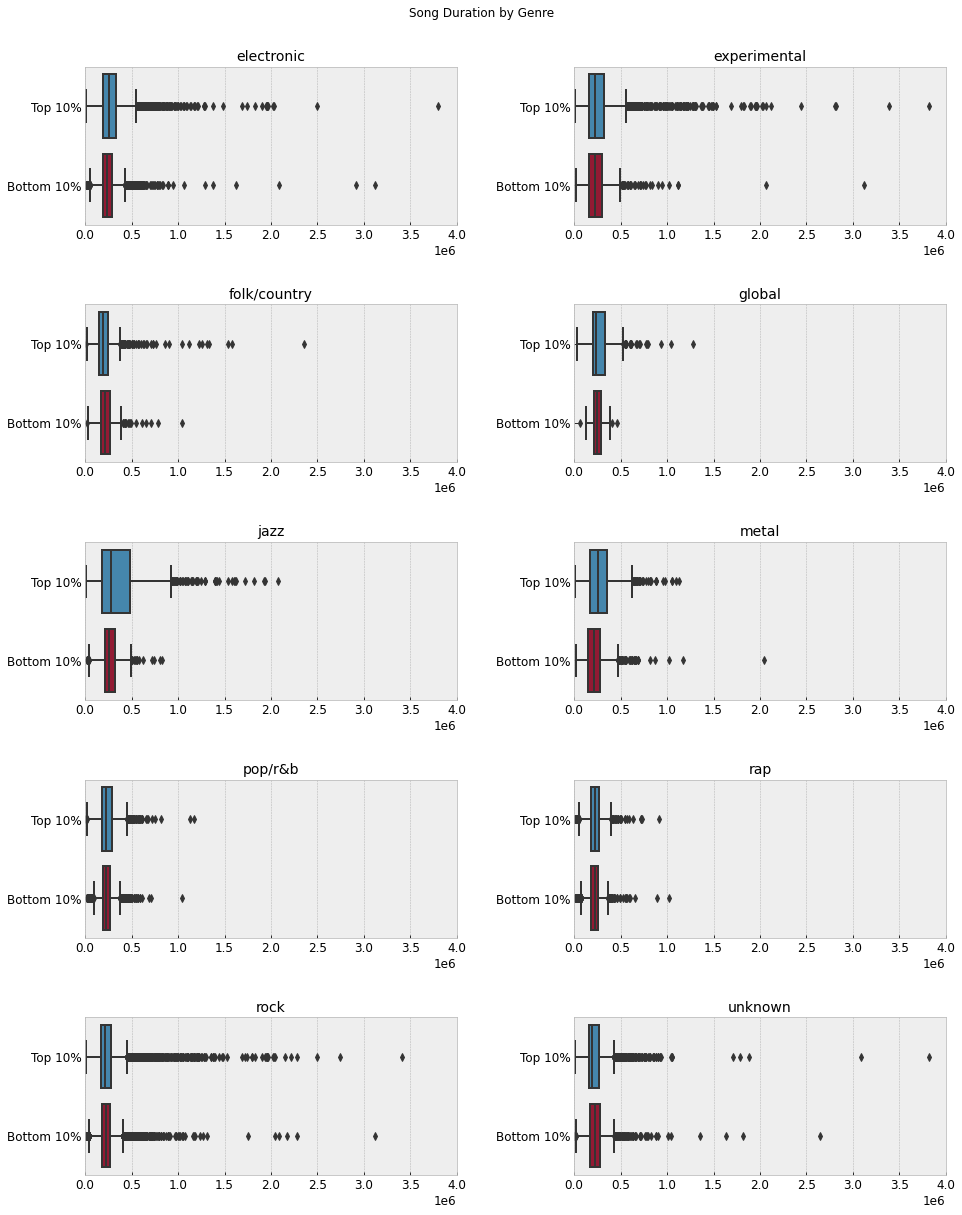

In [61]:
plot_numeric_grid('song_duration', top_album_songs, bottom_album_songs, 'Song Duration by Genre', x_limit=4000000)

In [62]:
song_duration_df = genre_comparison('song_duration', top_album_songs, bottom_album_songs,
                                    caption_text='Song Duration Statistical Analysis')
song_duration_df

In [63]:
top_album_songs[top_album_songs.song_duration > 3000000]

reviewid                            artist_name  \
694       17064                       william basinski   
7027      11326                             carl craig   
7039      11326                             carl craig   
8085      22346                            steve reich   
8257       3402                                    gas   
8836      18200                       public image ltd   
12657      9742  charlemagne palestine and tony conrad   
20668     16601                                  sleep   

                      album_title  score  \
694      the disintegration loops   10.0   
7027                     sessions    9.0   
7039                     sessions    9.0   
8085           the ecm recordings    9.0   
8257                          pop    9.0   
8836                  first issue    9.0   
12657  an aural symbiotic mystery    8.7   
20668                  dopesmoker    8.5   

                                               song_name  \
694                                              dlp 1.1   
7027                               Sessions Bundle Mix 1   
7039                               Sessions Bundle Mix 2   
8085                              Music For 18 Musicians   
8257                                            Narkopop   
8836   Interview with John Lydon (Bbc Radio 1, Rock o...   
12657                         An Aural Symbiotic Mystery   
20668                                         Dopesmoker   

                      song_id  song_track_number  song_duration  \
694    31FiS1jMI38kYfC8ey358W                  1        3815786   
7027   235M9GFOFO0jsufoXHwhSx                 12        3802639   
7039   1FUXeu6E10MWbNumUl6ihY                 12        4284626   
8085   4x48SRR0MmHwZFqKlN0zRr                  1        3391040   
8257   7iOzU5FKqAg4MXrcnhHGFC                 11        4277993   
8836   0ASMSvJ6awIo4O1ytllGNZ                 10        3414960   
12657  6D9JyzMU2sPPt1cAdtTUlo                  1        3092533   
20668  1vhvheW4R0KbK6Kr3NFplW                  1        3816373   

       song_explicit                              song_uri  acousticness  \
694                0  spotify:track:31FiS1jMI38kYfC8ey358W       0.97300   
7027               0  spotify:track:235M9GFOFO0jsufoXHwhSx       0.00425   
7039               0  spotify:track:1FUXeu6E10MWbNumUl6ihY       0.00282   
8085               0  spotify:track:4x48SRR0MmHwZFqKlN0zRr       0.98200   
8257               0  spotify:track:7iOzU5FKqAg4MXrcnhHGFC       0.08910   
8836               0  spotify:track:0ASMSvJ6awIo4O1ytllGNZ       0.83300   
12657              0  spotify:track:6D9JyzMU2sPPt1cAdtTUlo       0.85300   
20668              0  spotify:track:1vhvheW4R0KbK6Kr3NFplW       0.00367   

       danceability  energy  key  mode  time_signature  instrumentalness  \
694          0.2800  0.0816    5     1               5             0.938   
7027         0.7240  0.5140    1     0               4             0.823   
7039         0.6890  0.7910   11     0               4             0.788   
8085         0.5080  0.5360    9     1               3             0.921   
8257         0.1620  0.1970    6     0               4             0.844   
8836         0.6160  0.0795   11     0               3             0.000   
12657        0.0657  0.1600    2     1               3             0.755   
20668        0.1600  0.5720    5     1               4             0.745   

       liveness  speechiness    tempo  valence  popularity release_date  \
694      0.1050       0.0406   95.380   0.0669          40   2014-09-02   
7027     0.1070       0.0559  123.862   0.2250           0   2004-01-01   
7039     0.1330       0.0638  125.160   0.2000           0   2004-01-01   
8085     0.0835       0.0449  106.567   0.3750          32   2016-09-30   
8257     0.1700       0.0367  110.000   0.0379           0   2017-04-21   
8836     0.3650       0.8900  102.879   0.3030           7   1978-01-01   
12657    0.7320       0.0440   73.040   0.0330 

### Song Duration (Outliers Removed)

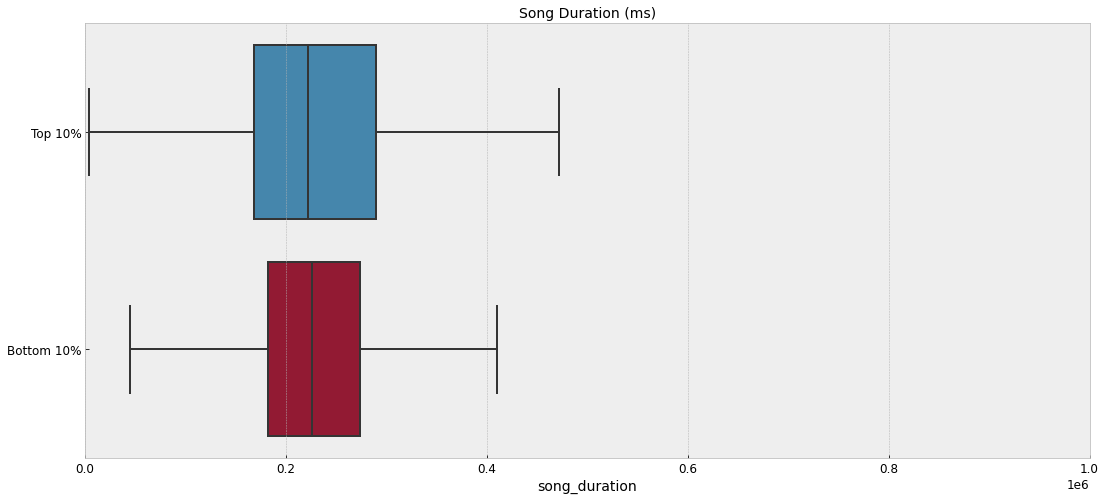

In [64]:
plot_numeric_col('song_duration', top_album_songs, bottom_album_songs, 'Song Duration (ms)',
                 x_limit=1000000, show_outliers=False)

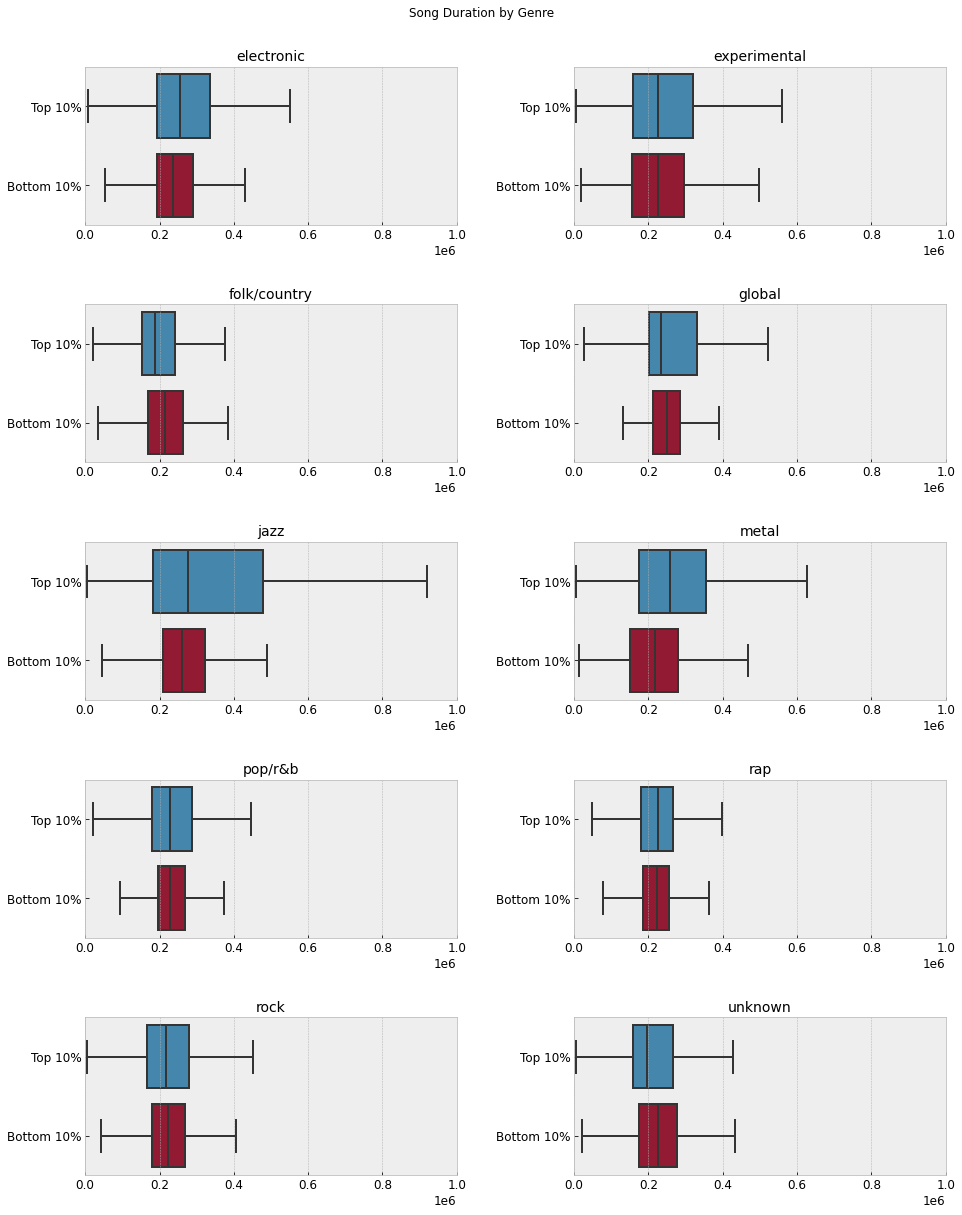

In [65]:
plot_numeric_grid('song_duration', top_album_songs, bottom_album_songs, 'Song Duration by Genre', x_limit=1000000, show_outliers=False)

### Acousticness
A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

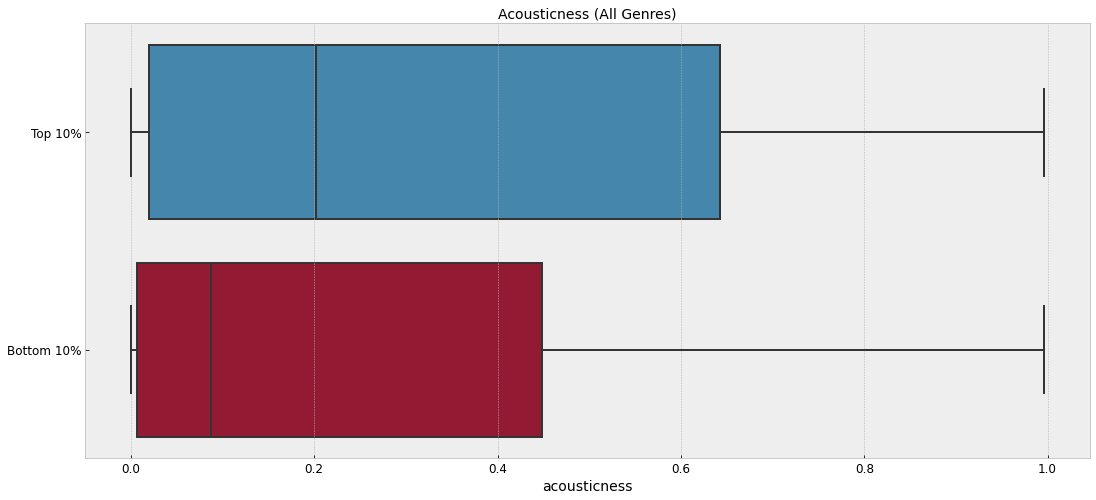

In [66]:
plot_numeric_col('acousticness', top_album_songs, bottom_album_songs, 'Acousticness (All Genres)', save=True, save_title='song_acousticness.png')

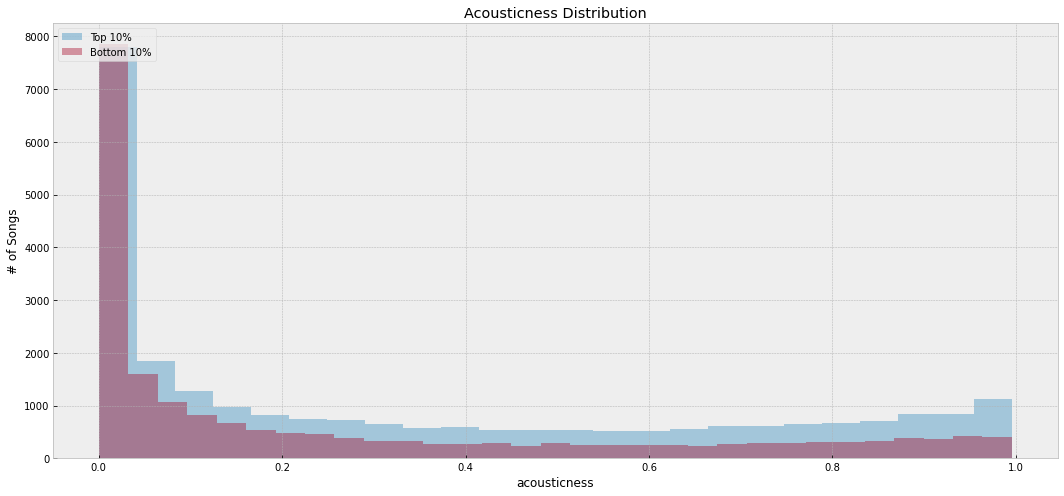

In [67]:
plot_histogram('acousticness', top_album_songs, bottom_album_songs, 'Acousticness Distribution')

In [68]:
var_comparison('acousticness', top_album_songs, bottom_album_songs)

N1 (Top 10%): 25270
N2 (Bottom 10%): 20495
U-value:  220852962.5
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.426
Top 10% Median:  0.20199999999999999
Bottom 10% Median:  0.0874
Number of Outliers (Top 10%):  0
Number of Outliers (Bottom 10%):  0


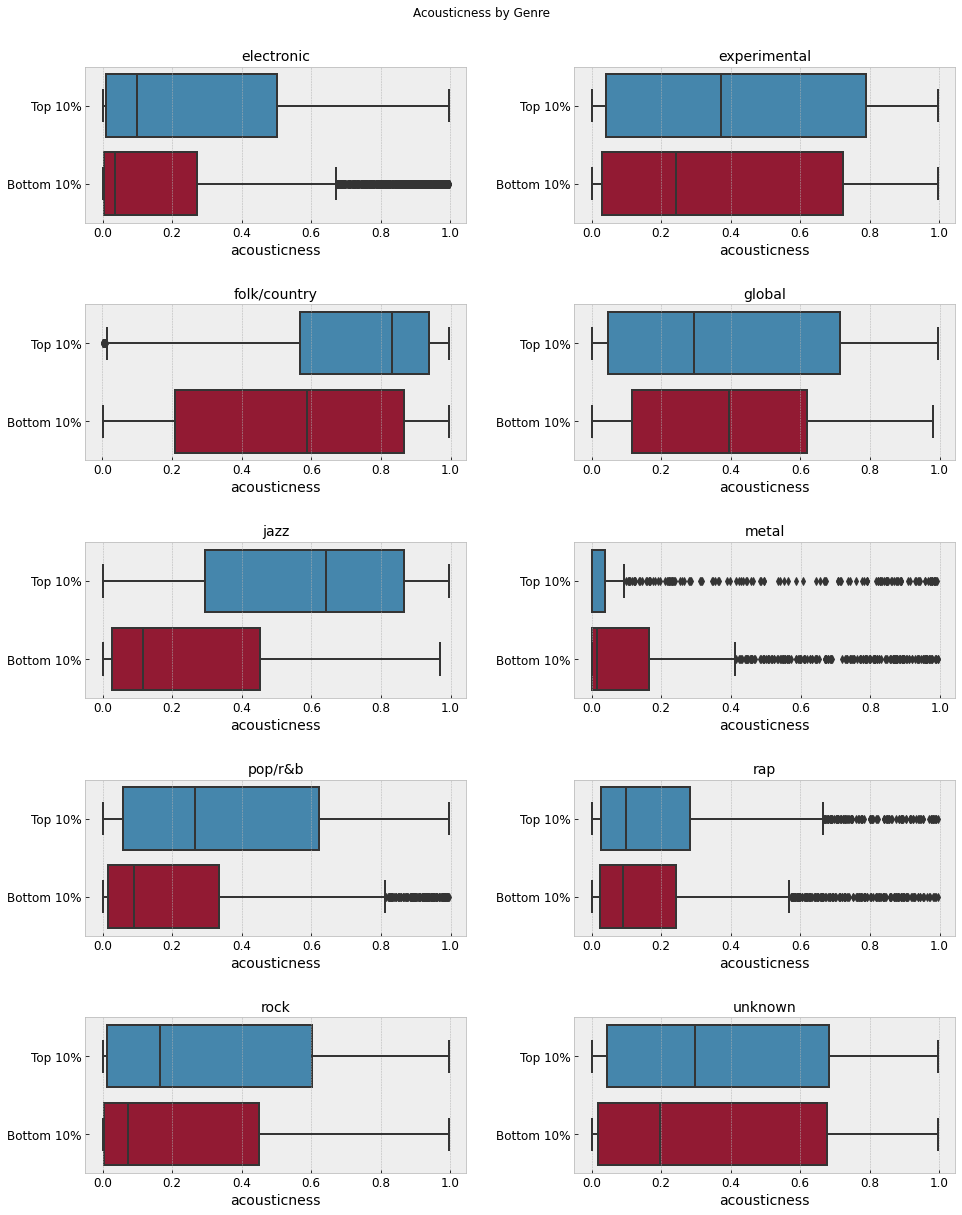

In [69]:
plot_numeric_grid('acousticness', top_album_songs, bottom_album_songs, 'Acousticness by Genre', x_label='acousticness')

In [152]:
top_album_songs[top_album_songs.acousticness > 0.995]

reviewid         artist_name  \
3942       2573              dungen   
4402       2575              dungen   
5531      10747     various artists   
6573      14821           bob dylan   
6594      15881                 m83   
8067        260  the appleseed cast   
13205      5507     dorine muraille   
13539     22277    william basinski   
13934     13861            four tet   
14945      2110     various artists   
16979     22606             rachels   
17739     18408    julianna barwick   
22471      6760                 req   

                                             album_title  score  \
3942                                        ta det lugnt    9.3   
4402                                        ta det lugnt    9.3   
5531   the very best of ethiopiques hypnotic grooves ...    9.2   
6573   the bootleg series vol 9 the witmark demos 196...    9.1   
6594                              hurry up were dreaming    9.1   
8067                          low level owl vol i and ii    9.0   
13205                                               mani    8.7   
13539                                              92982    8.7   
13934                               there is love in you    8.6   
14945        american primitive vol ii pre war revenants    8.6   
16979                                     systems layers    8.5   
17739                                           nepenthe    8.5   
22471                                         sketchbook    8.4   

                                          song_name                 song_id  \
3942    Glömd Konst Kommer Stundom Ånyo Till Heders  3EIFuubyLmKojseWWrZ51w   
4402    Glömd Konst Kommer Stundom Ånyo Till Heders  3EIFuubyLmKojseWWrZ51w   
5531                                  Mother's Love  5SnYnqM27WNCTN8siQqtbv   
6573   I'll Keep It with Mine - Witmark Demo - 1964  5IrauJx70zx72c1xiZgzVq   
6594                       When Will You Come Home?  0ILPnIuTZ2TJ8pbYxmOHzF   
8067                               Bird of Paradise  6mzcK5C2X5Ybcv50gfuvyv   
13205                                    Muraille_3  4zr8feVxddLfKYYsGeGzJu   
13539                                       92982.4  6mLqt7OCy4IJJLo9GF2Tas   
13934                                 Pablo's Heart  4IpwXQ6ALvhhmfq54d9hCj   
14945                                  Poor Mourner  2fkSEHYsdWCJ8hmAprL87U   
16979                                 NY Snow Globe  1DsW5wQCQYvl2DjtYkshWg   
17739                                        Offing  3LiafX2u4wHRwLy1W9B81q   
22471                                       Colours  1XyqR5GgLPz0Lsd67U0UNi   

       song_track_number  song_duration  song_explicit  \
3942                   9          55760              0   
4402                   9          55760              0   
5531                   6         219146              0   
6573                  22         214626              0   
6594                  10          83600              0   
8067                   9         144120              0   
13205                 12          51533              0   
13539                  3        1199440              0   
13934                  4          11992              0   
14945                  2         119493              0   
16979                 19         147866              0   
17739                  1         195533              0   
22471                  5         300426              0   

                                   song_uri  acousticness  danceability  \
3942   spotify:track:3EIFuubyLmKojseWWrZ51w         0.996         0.225   
4402   spotify:track:3EIFuubyLmKojseWWrZ51w         0.996         0.225   
5531   spotify:track:5SnYnqM27WNCTN8siQqtbv         0.996         0.379   
6573   spotify:track:5IrauJx70zx72c1xiZgzVq         0.996         0.425   
6594   spotify:track:0ILPnIuTZ2TJ8pbYxmOHzF         0.996         0.208   
8067   spotify:track:6mzcK5C2X5Ybcv50gfuvyv         0.996         0.451   
13205  spotify:track:4zr8feVxddLfKYYsGeGzJu         0.996         0.692   
1

In [71]:
acousticness_df = genre_comparison('acousticness', top_album_songs, bottom_album_songs,
                                   caption_text = 'Song Acousticness Statistical Analysis')
acousticness_df

### Danceability
Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

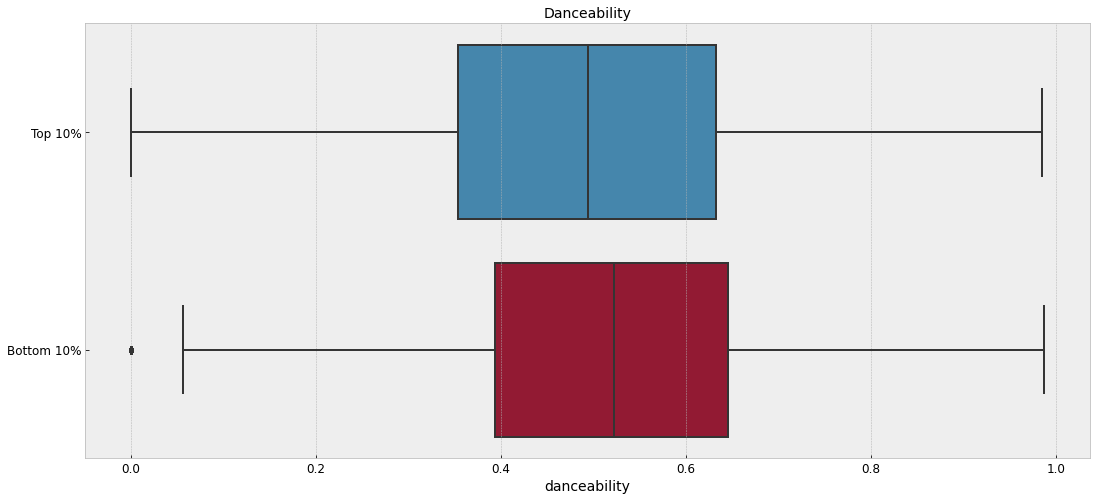

In [72]:
plot_numeric_col('danceability', top_album_songs, bottom_album_songs, 'Danceability')

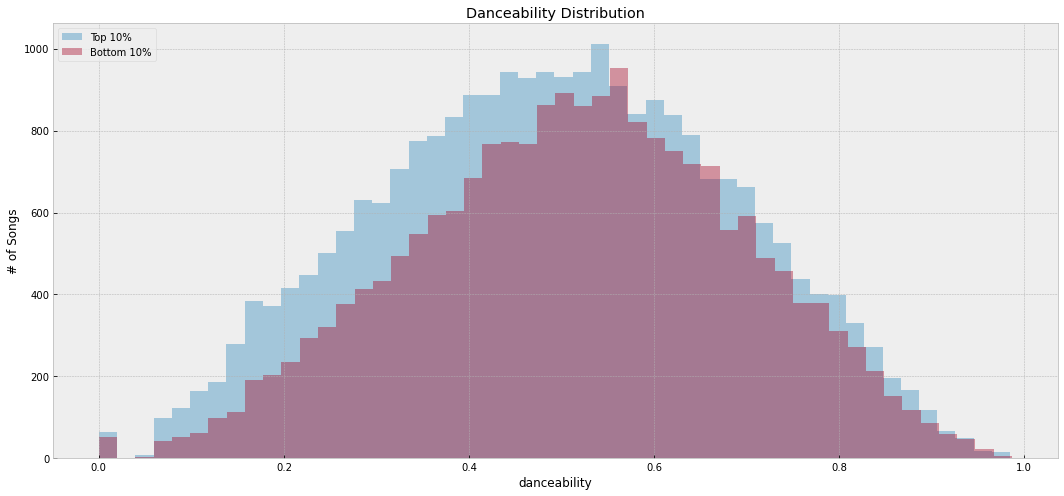

In [73]:
plot_histogram('danceability', top_album_songs, bottom_album_songs, 'Danceability Distribution', save=True, save_title='danceability_distribution.png')

In [74]:
var_comparison('danceability', top_album_songs, bottom_album_songs)

N1 (Top 10%): 25270
N2 (Bottom 10%): 20495
U-value:  239699756.5
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.463
Top 10% Median:  0.494
Bottom 10% Median:  0.522
Number of Outliers (Top 10%):  0
Number of Outliers (Bottom 10%):  0


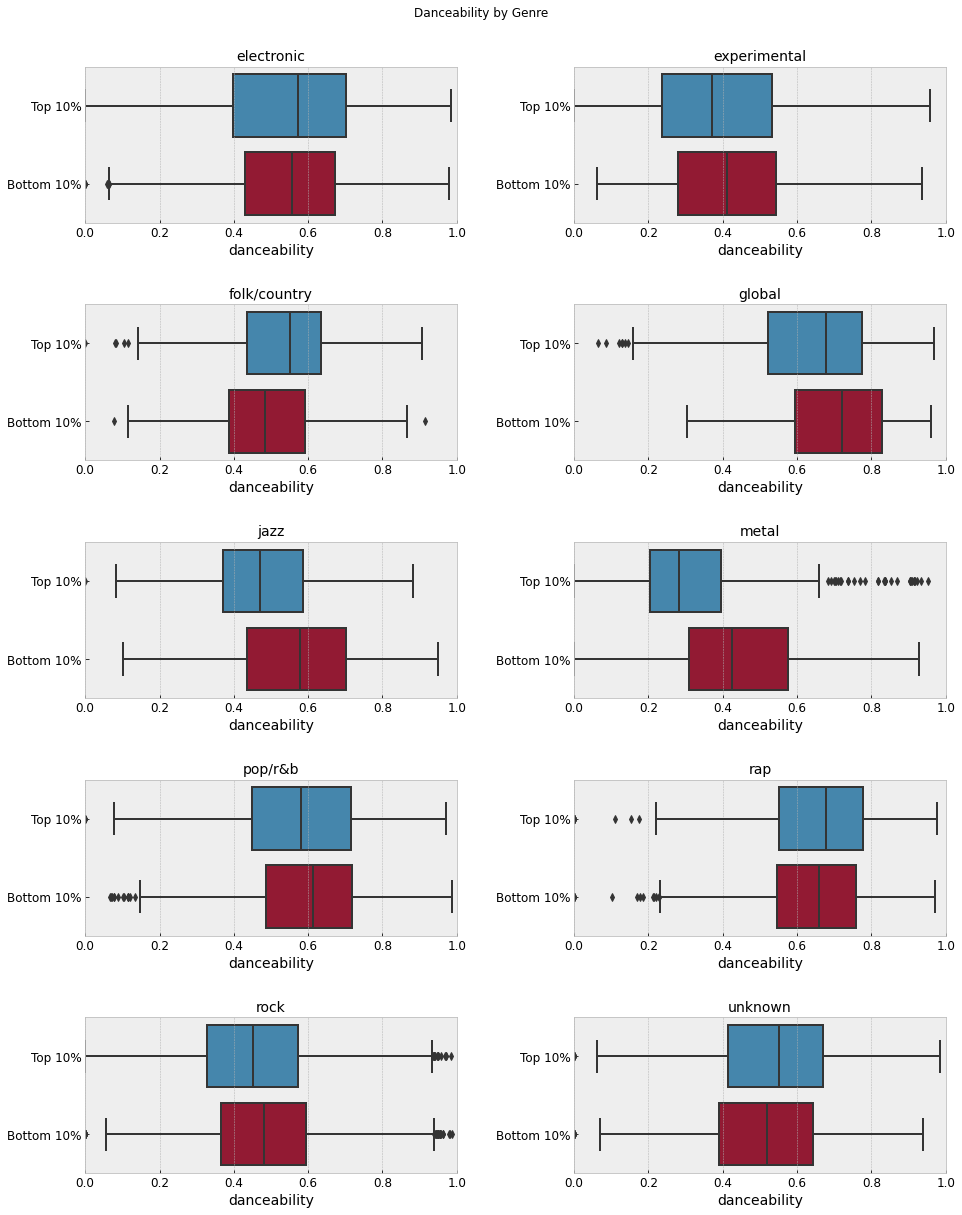

In [75]:
plot_numeric_grid('danceability', top_album_songs, bottom_album_songs, 'Danceability by Genre', x_limit=1, x_label='danceability')

In [76]:
danceability_df = genre_comparison('danceability', top_album_songs, bottom_album_songs,
                                    caption_text='Song Danceability Statistical Analysis')
danceability_df

### Energy
Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

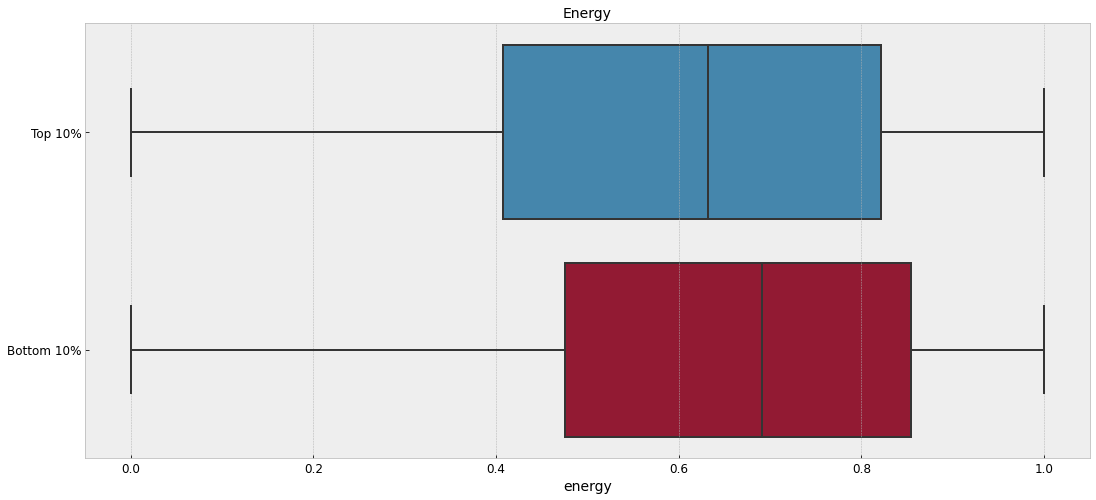

In [77]:
plot_numeric_col('energy', top_album_songs, bottom_album_songs, 'Energy', save=True, save_title='energy_distribution.png')

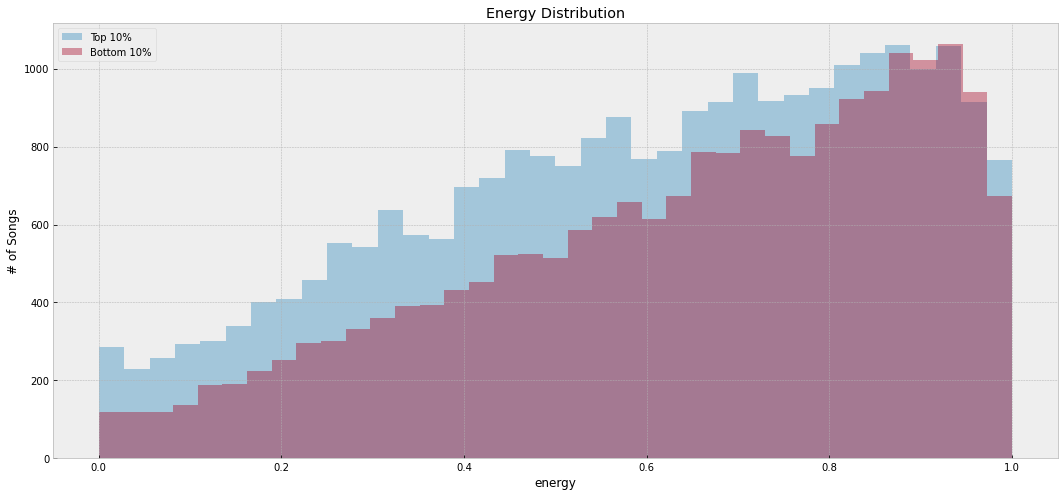

In [78]:
plot_histogram('energy', top_album_songs, bottom_album_songs, 'Energy Distribution')

In [79]:
var_comparison('energy', top_album_songs, bottom_album_songs)

N1 (Top 10%): 25270
N2 (Bottom 10%): 20495
U-value:  231701276.5
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.447
Top 10% Median:  0.6325000000000001
Bottom 10% Median:  0.691
Number of Outliers (Top 10%):  0
Number of Outliers (Bottom 10%):  0


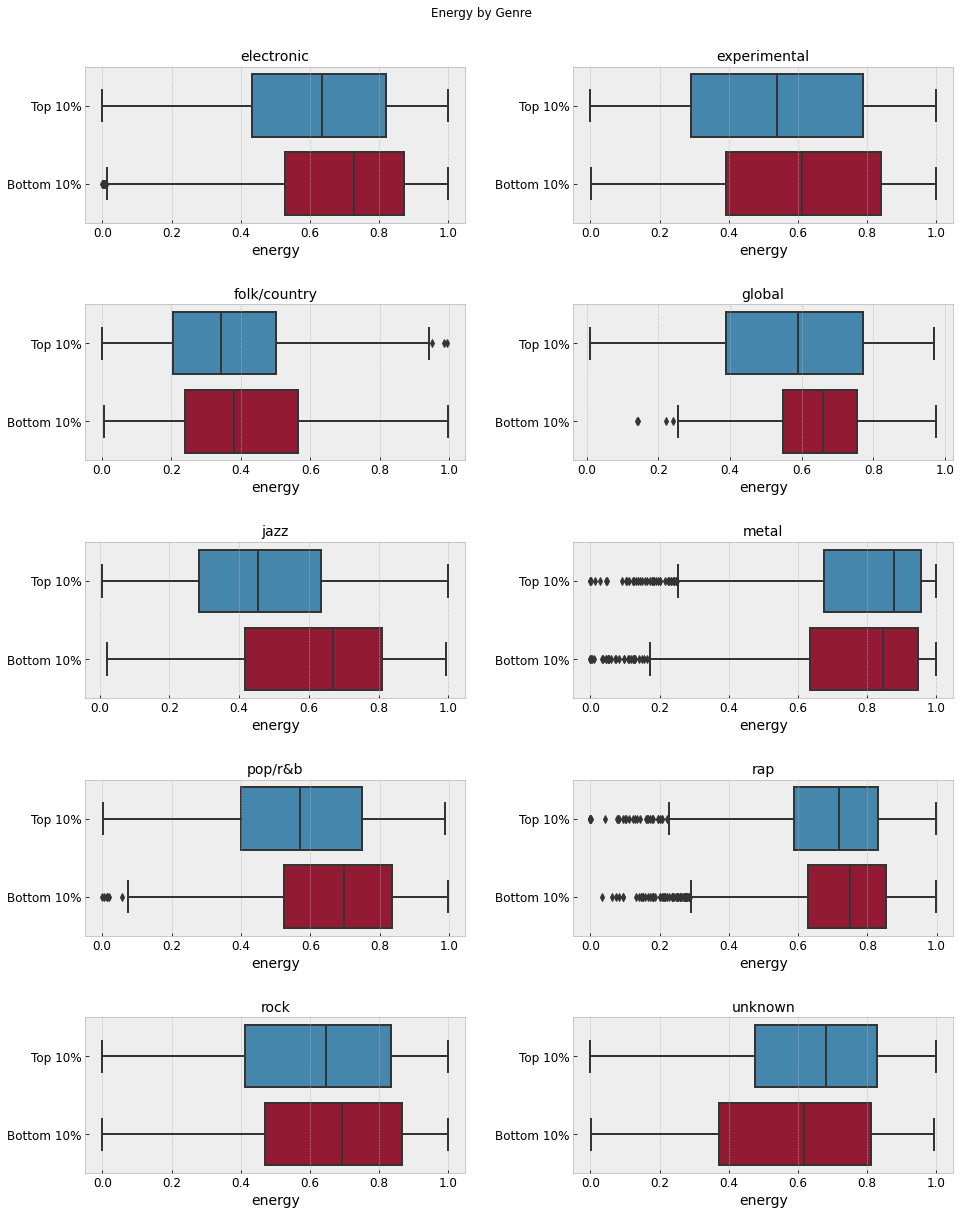

In [80]:
plot_numeric_grid('energy', top_album_songs, bottom_album_songs, 'Energy by Genre', x_label='energy')

In [81]:
energy_df = genre_comparison('energy', top_album_songs, bottom_album_songs,
                              caption_text='Song Energy Statistical Analysis')
energy_df

### Instrumentalness
Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

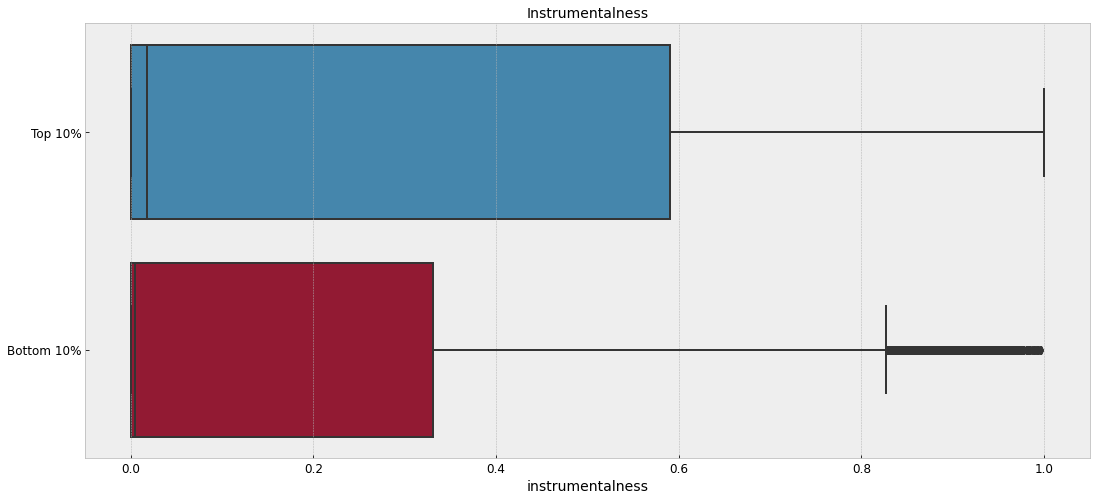

In [82]:
plot_numeric_col('instrumentalness', top_album_songs, bottom_album_songs, 'Instrumentalness')

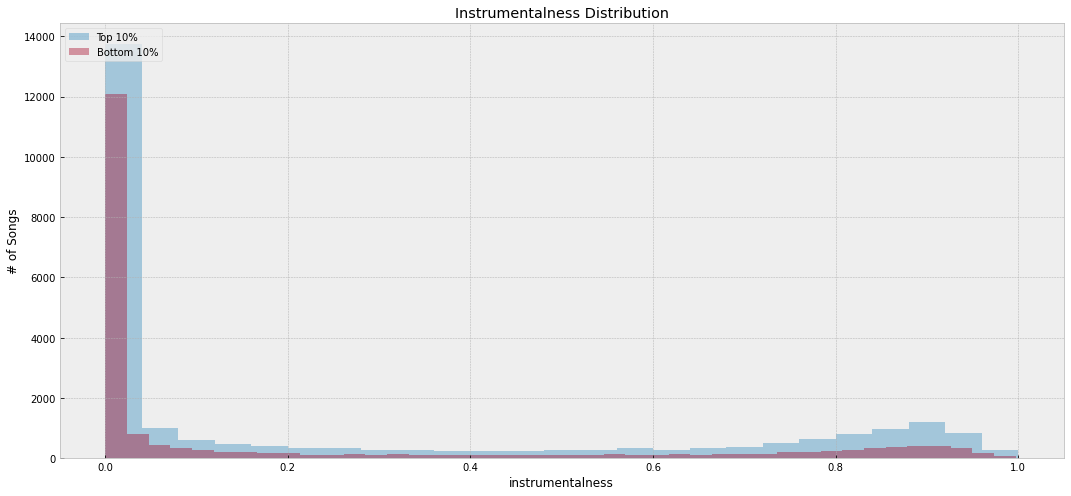

In [83]:
plot_histogram('instrumentalness', top_album_songs, bottom_album_songs, 'Instrumentalness Distribution', save=True,
              save_title='instrumentalness_distribution.png')

In [84]:
var_comparison('instrumentalness', top_album_songs, bottom_album_songs)

N1 (Top 10%): 25270
N2 (Bottom 10%): 20495
U-value:  235265987.5
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.454
Top 10% Median:  0.0173
Bottom 10% Median:  0.0042
Number of Outliers (Top 10%):  0
Number of Outliers (Bottom 10%):  0


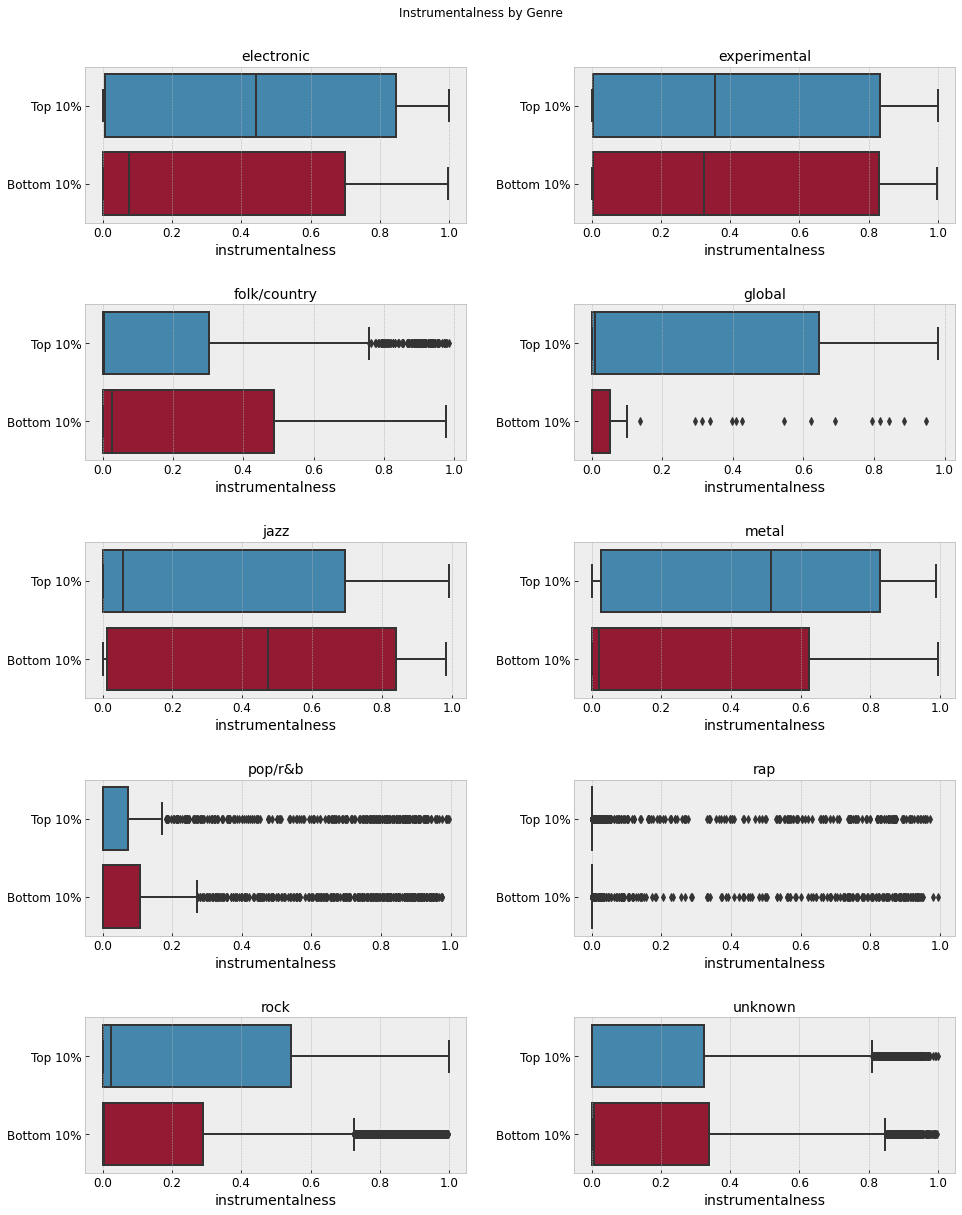

In [85]:
plot_numeric_grid('instrumentalness', top_album_songs, bottom_album_songs, 'Instrumentalness by Genre', x_label='instrumentalness')

In [86]:
instrumentalness_df = genre_comparison('instrumentalness', top_album_songs, bottom_album_songs,
                                        caption_text='Song Instrumentalness Statistical Analysis')
instrumentalness_df

In [87]:
top_album_songs[top_album_songs.instrumentalness > 0.98]

reviewid                       artist_name  \
1942      11921                         liz phair   
2490      11257                       chuck berry   
2905       3035                           fennesz   
3150       9760                           fennesz   
3689       2556                     disco inferno   
5119      17841                     half japanese   
5136      17841                     half japanese   
5138        952               broken social scene   
5158       7514                    sufjan stevens   
5277      11582                               gas   
5280      11582                               gas   
6001       5982         the olivia tremor control   
6079      21844                            prince   
6241        831                              blur   
6254        519                        bad brains   
6280       3265                         frog eyes   
8293      15688                   archers of loaf   
8593      22253                     janet jackson   
8677      21407                         this heat   
8687      21407                         this heat   
9156       7949                          tarwater   
9187       5267                   the microphones   
9625        892                  boxhead ensemble   
10721     14688                            no age   
11327      2041                   various artists   
11441      2449                          dreamies   
11464     16175                          drexciya   
11760      5900             namelessnumberheadman   
12013      9827                     frank sinatra   
12017      9827                     frank sinatra   
12236      4785                     gyorgy ligeti   
12711     17504             oneohtrix point never   
13703     20079                        panda bear   
14244      7023                  schlammpeitziger   
14253      7023                  schlammpeitziger   
14431     17132                          converge   
14569      5009                               m83   
14897      8008  thinking fellers union local 282   
15086     10448                           sebadoh   
15297      5323                    minus the bear   
15562      3036                           fennesz   
15731      3798                        tim hecker   
16254     15473                    mickey newbury   
16598      1729                       childs view   
16605     20463                          prurient   
16749     17508                  stars of the lid   
16751     17508                  stars of the lid   
17177     16379                       azusa plane   
17234      6353                          pluramon   
17237      6353                          pluramon   
17323     15299                        panda bear   
17700     15147                  julianna barwick   
17742     18408                  julianna barwick   
18254     12833                        dan deacon   
18373      7578                         sunn 0)))   
18675     11702                     cocteau twins   
18685     11702                     cocteau twins   
18686     11702                     cocteau twins   
19155     16936      ariel pinks haunted graffiti   
19303     11208                       beach house   
19507     19684             the smashing pumpkins   
20097      2889                           emperor   
20813      1247                        mira calix   
21111      5046                          mahogany   
21462     11066                  times new viking   
21463     11066                  times new viking   
21472     11066                  times new viking   
23386      1743                           colleen   
23388      1743                           colleen   
23457      8874                     susumu yokota   
24149     13809                         ben frost   
24417     16432                       lotus plaza   
24458      5732                     need new body   
24949      3033                           fennesz   
25132     13963                 

### Liveness
Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

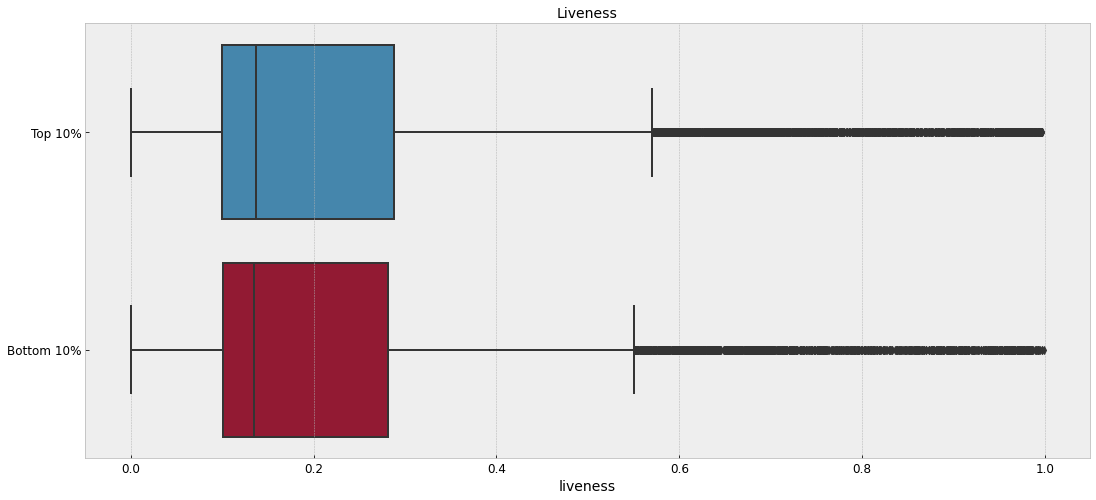

In [88]:
plot_numeric_col('liveness', top_album_songs, bottom_album_songs, 'Liveness')

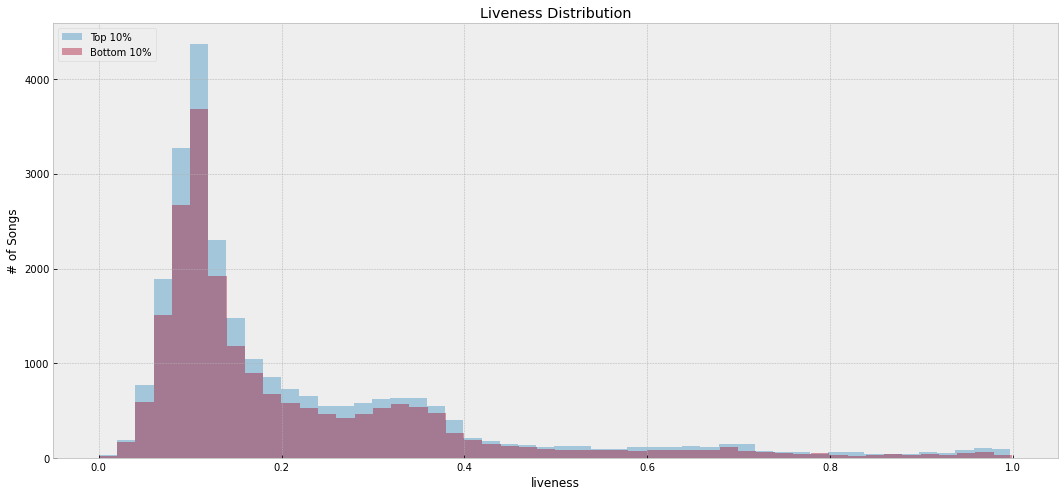

In [89]:
plot_histogram('liveness', top_album_songs, bottom_album_songs, 'Liveness Distribution', save=True, save_title='liveness_distribution.png')

In [90]:
var_comparison('liveness', top_album_songs, bottom_album_songs)

N1 (Top 10%): 25270
N2 (Bottom 10%): 20495
U-value:  256417461.5
p-value:  0.036
Significant:  True
Common Language Effect Size:  0.495
Top 10% Median:  0.13699999999999998
Bottom 10% Median:  0.135
Number of Outliers (Top 10%):  705
Number of Outliers (Bottom 10%):  539


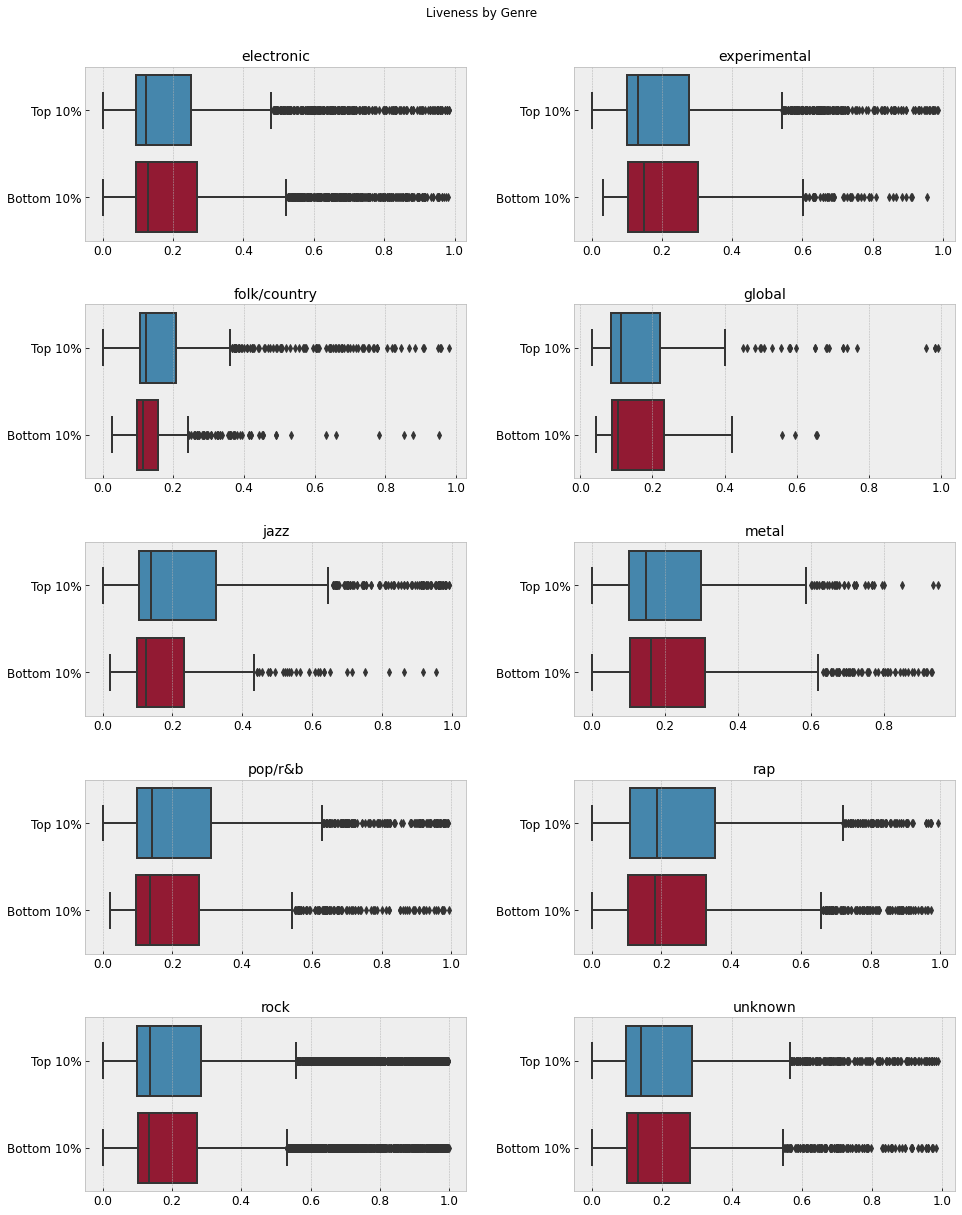

In [91]:
plot_numeric_grid('liveness', top_album_songs, bottom_album_songs, 'Liveness by Genre')

In [92]:
liveness_df = genre_comparison('liveness', top_album_songs, bottom_album_songs,
                                caption_text='Song Liveness Statistical Analysis')
liveness_df

### Speechiness
Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

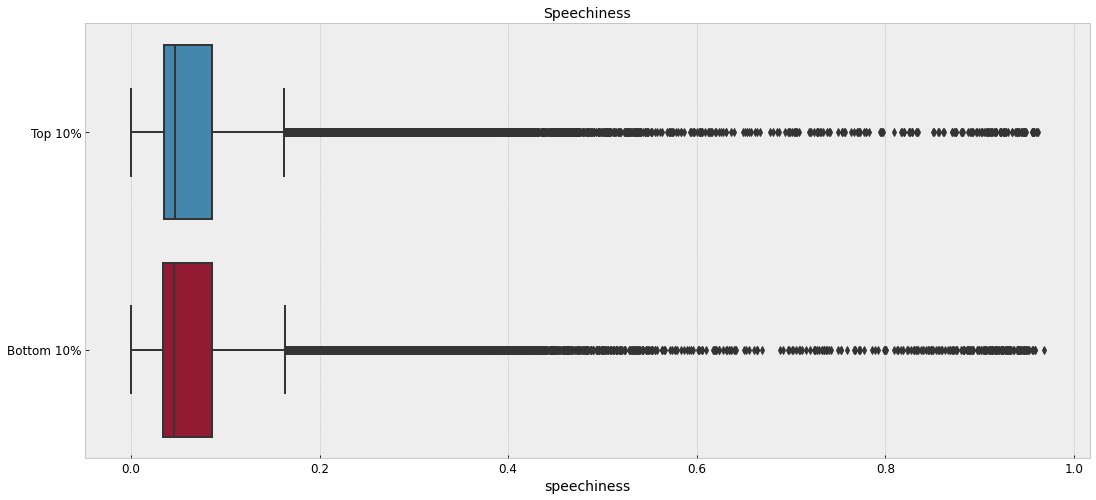

In [93]:
plot_numeric_col('speechiness', top_album_songs, bottom_album_songs, 'Speechiness')

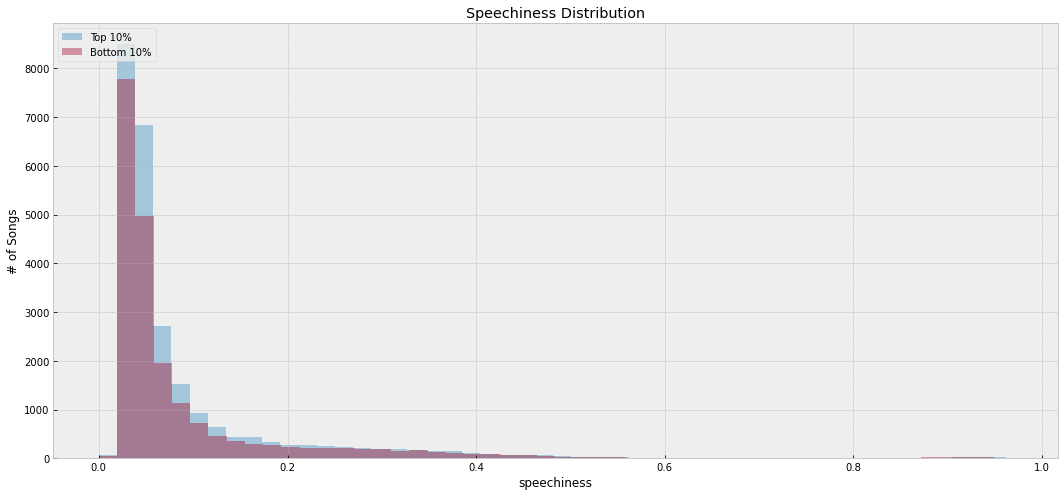

In [94]:
plot_histogram('speechiness', top_album_songs, bottom_album_songs, 'Speechiness Distribution')

In [95]:
var_comparison('speechiness', top_album_songs, bottom_album_songs)

N1 (Top 10%): 25270
N2 (Bottom 10%): 20495
U-value:  251055615.0
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.485
Top 10% Median:  0.0471
Bottom 10% Median:  0.0456
Number of Outliers (Top 10%):  563
Number of Outliers (Bottom 10%):  397


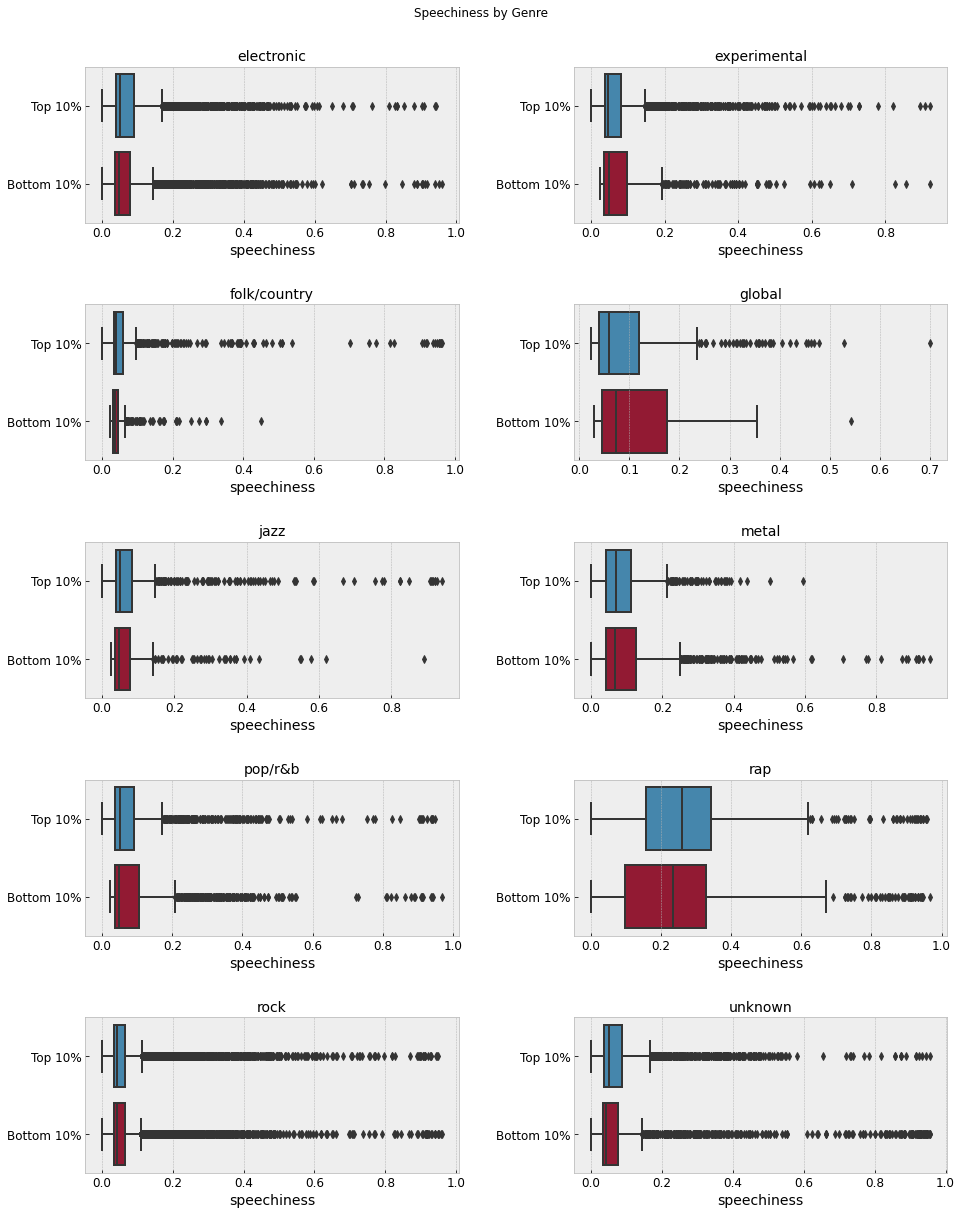

In [96]:
plot_numeric_grid('speechiness', top_album_songs, bottom_album_songs, 'Speechiness by Genre', x_label='speechiness')

In [145]:
speechiness_df = genre_comparison('speechiness', top_album_songs, bottom_album_songs,
                                   caption_text='Song Speechiness Statistical Analysis')
speechiness_df

### Tempo
The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

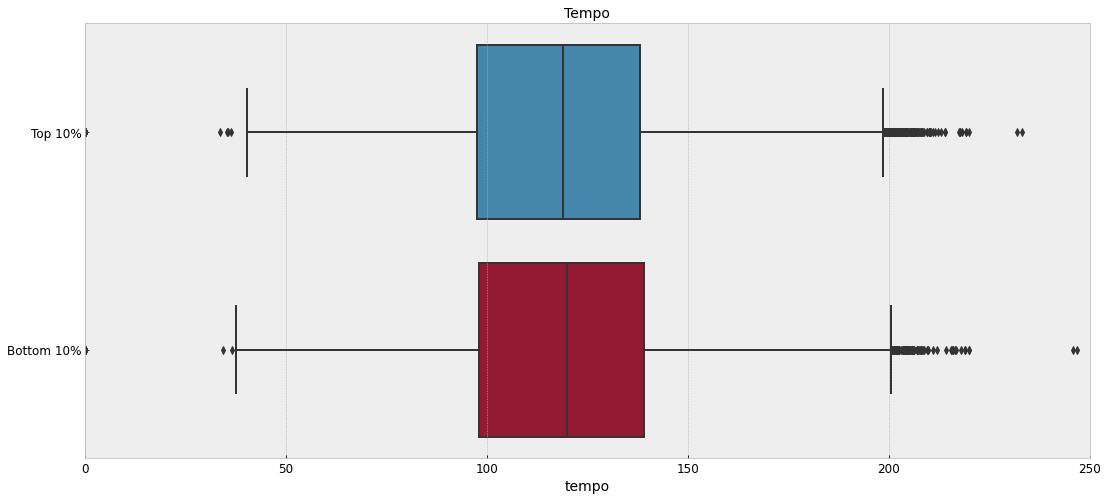

In [98]:
plot_numeric_col('tempo', top_album_songs, bottom_album_songs, 'Tempo', x_limit=250)

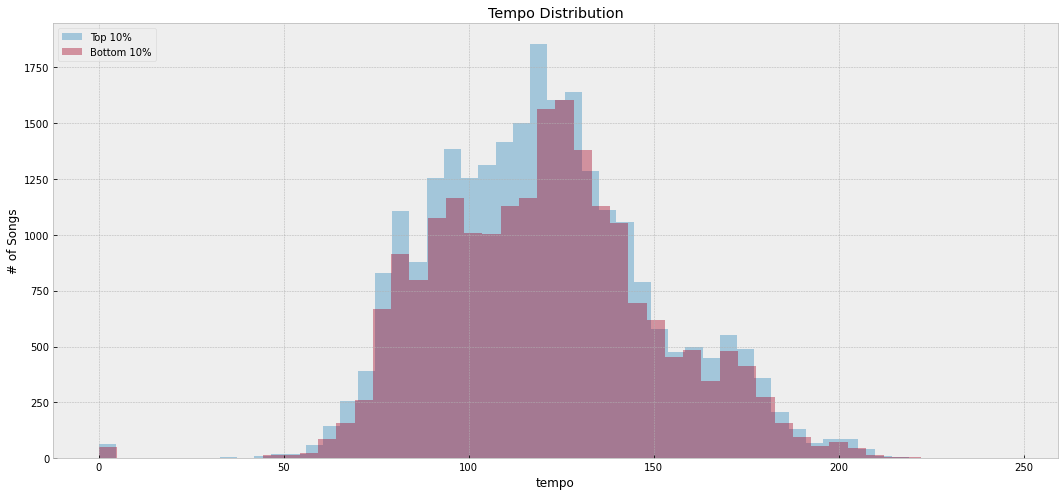

In [99]:
plot_histogram('tempo', top_album_songs, bottom_album_songs, 'Tempo Distribution', save=True, save_title='tempo_distribution')

In [100]:
var_comparison('tempo', top_album_songs, bottom_album_songs)

N1 (Top 10%): 25270
N2 (Bottom 10%): 20495
U-value:  252786655.0
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.488
Top 10% Median:  118.919
Bottom 10% Median:  120.035
Number of Outliers (Top 10%):  21
Number of Outliers (Bottom 10%):  16


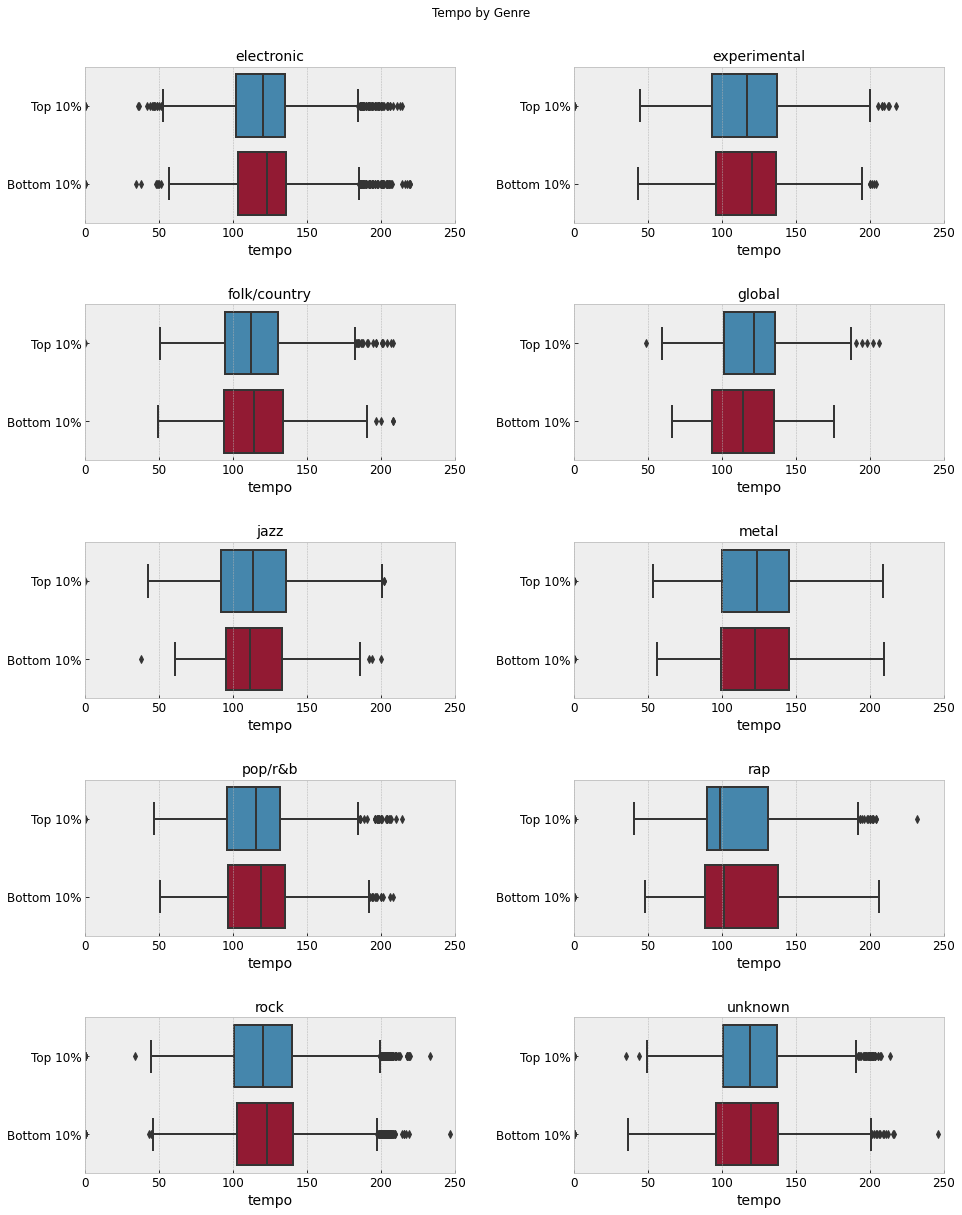

In [101]:
plot_numeric_grid('tempo', top_album_songs, bottom_album_songs, 'Tempo by Genre', x_limit=250, x_label='tempo')

In [102]:
tempo_df = genre_comparison('tempo', top_album_songs, bottom_album_songs, 
                             caption_text='Song Tempo Statistical Analysis')
tempo_df

### Valence
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

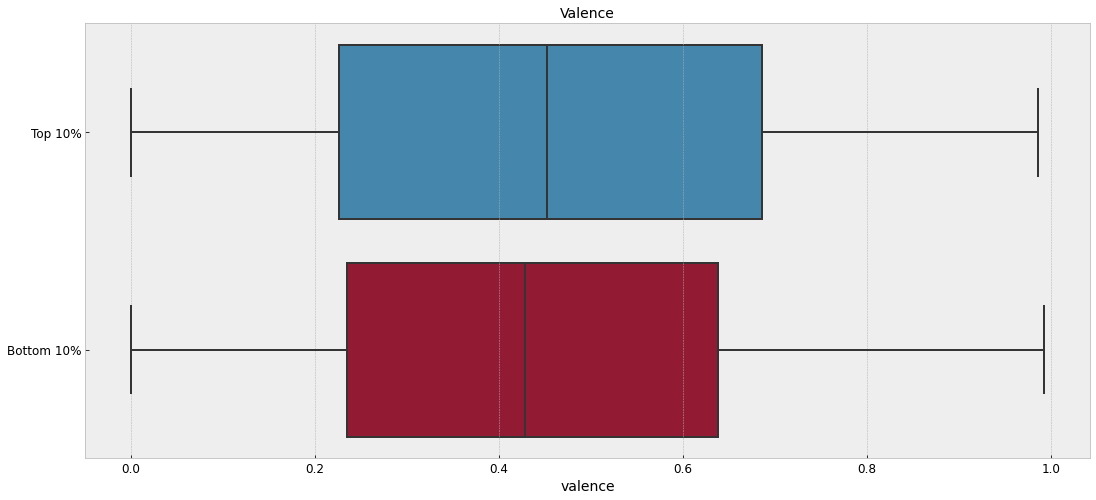

In [103]:
plot_numeric_col('valence', top_album_songs, bottom_album_songs, 'Valence', save=True, save_title='valence_distribution.png')

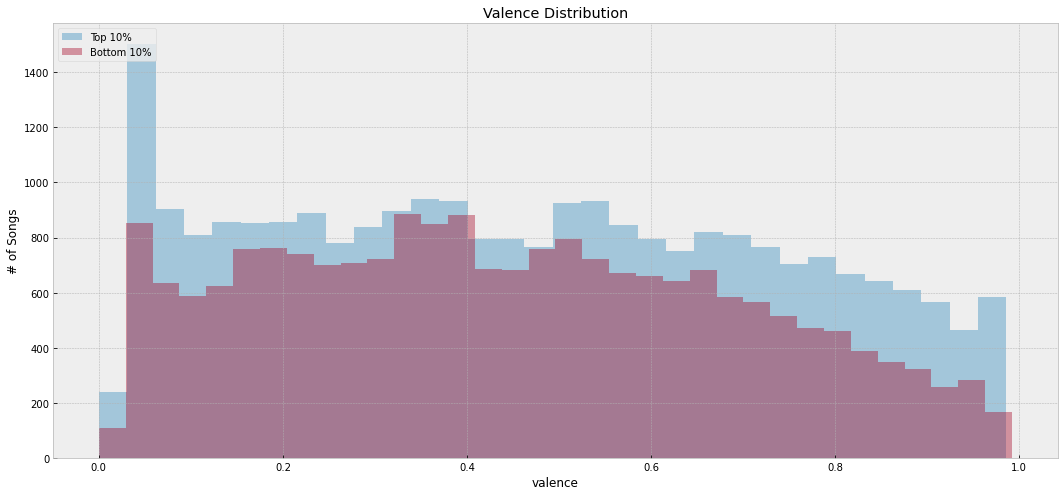

In [104]:
plot_histogram('valence', top_album_songs, bottom_album_songs, 'Valence Distribution')

In [105]:
var_comparison('valence', top_album_songs, bottom_album_songs)

N1 (Top 10%): 25270
N2 (Bottom 10%): 20495
U-value:  250219780.0
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.483
Top 10% Median:  0.452
Bottom 10% Median:  0.428
Number of Outliers (Top 10%):  0
Number of Outliers (Bottom 10%):  0


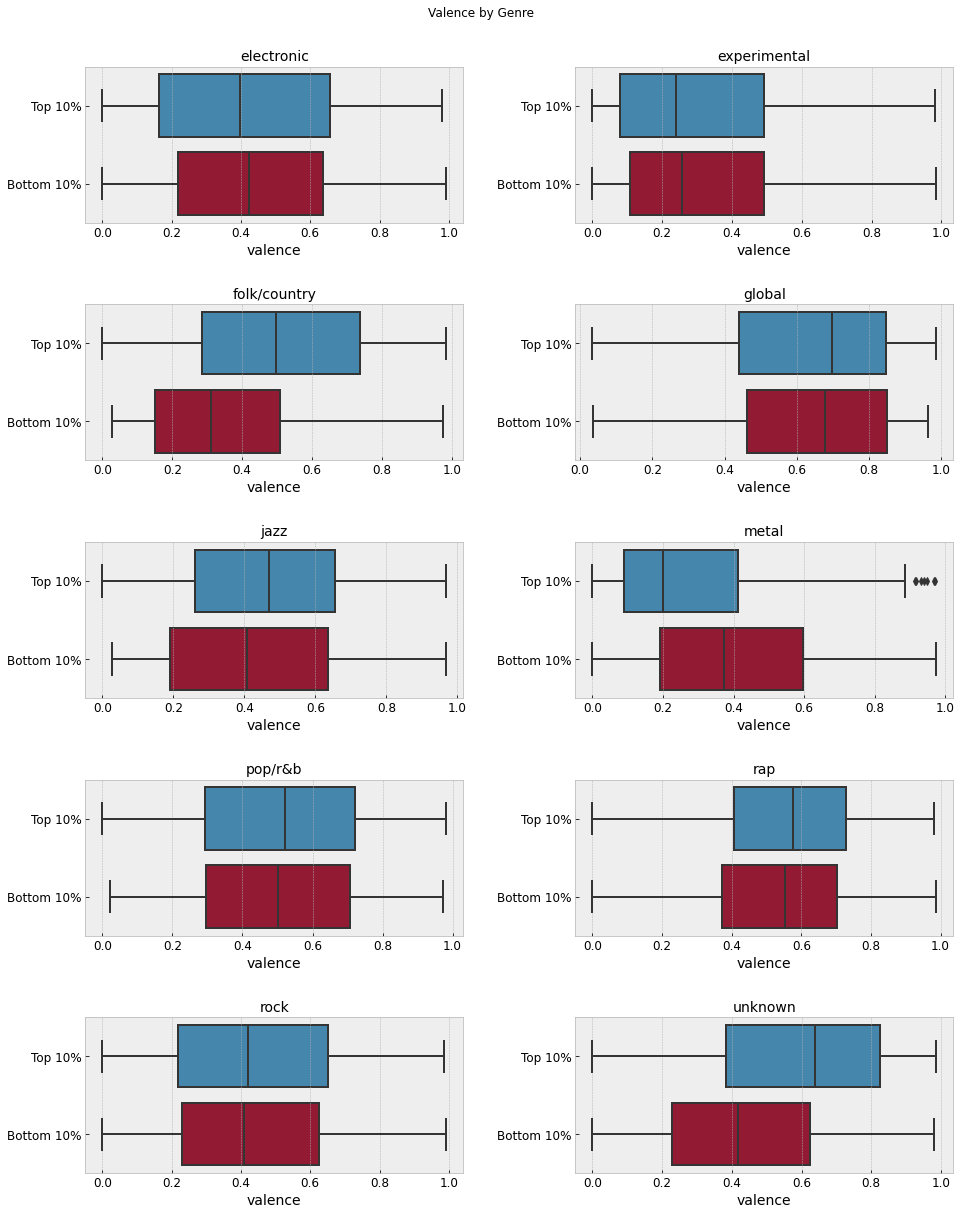

In [106]:
plot_numeric_grid('valence', top_album_songs, bottom_album_songs, 'Valence by Genre', x_label='valence')

In [107]:
valence_df = genre_comparison('valence', top_album_songs, bottom_album_songs, 
                               caption_text='Song Valence Statistical Analysis')
valence_df

### Popularity

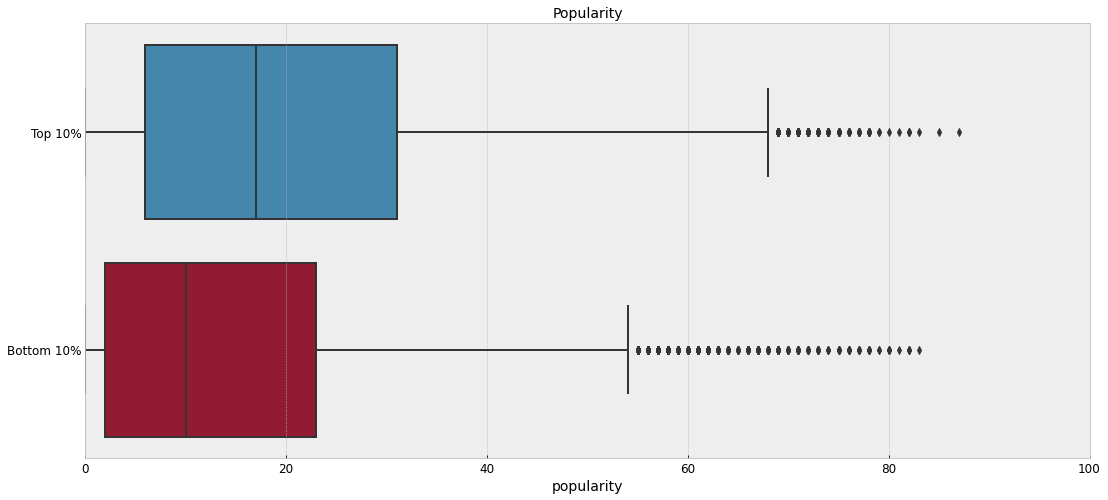

In [108]:
plot_numeric_col('popularity', top_album_songs, bottom_album_songs, 'Popularity', x_limit=100, save=True, save_title='popularity_distribution.png')

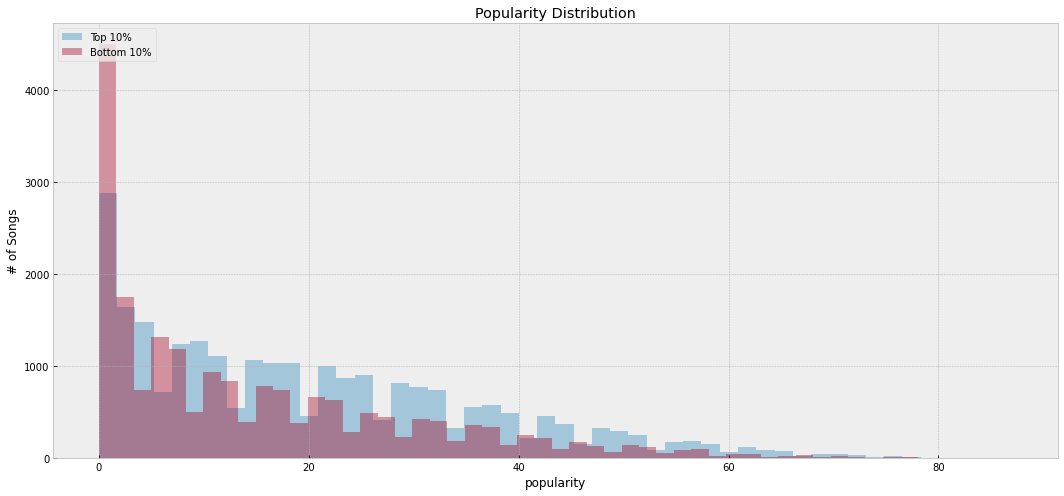

In [109]:
plot_histogram('popularity', top_album_songs, bottom_album_songs, 'Popularity Distribution')

In [110]:
var_comparison('popularity', top_album_songs, bottom_album_songs)

N1 (Top 10%): 25270
N2 (Bottom 10%): 20495
U-value:  206753828.5
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.399
Top 10% Median:  17.0
Bottom 10% Median:  10.0
Number of Outliers (Top 10%):  153
Number of Outliers (Bottom 10%):  216


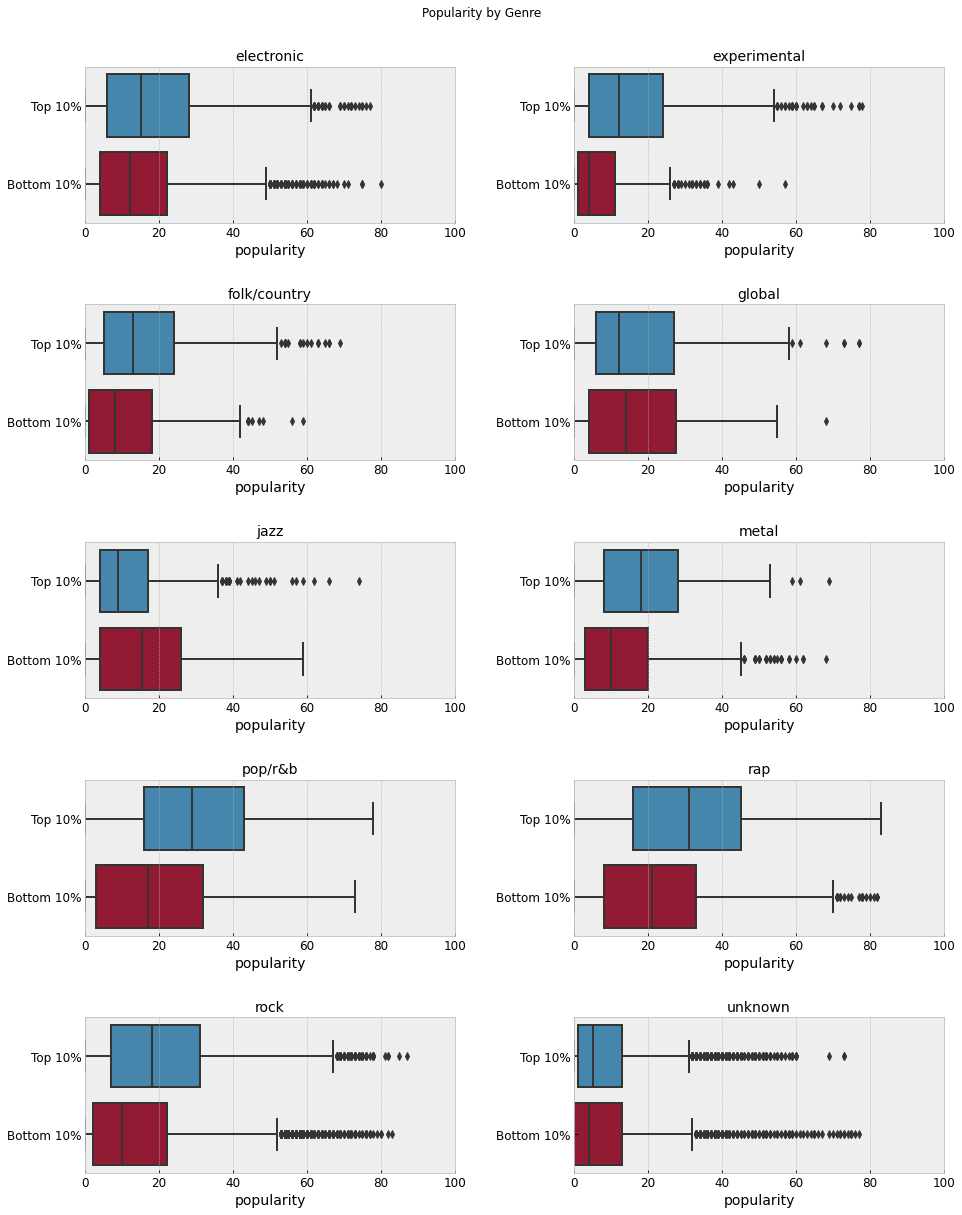

In [111]:
plot_numeric_grid('popularity', top_album_songs, bottom_album_songs, 'Popularity by Genre', x_limit=100, x_label='popularity')

In [112]:
popularity_df = genre_comparison('popularity', top_album_songs, bottom_album_songs, 
                                  caption_text='Song Popularity Statistical Analysis')
popularity_df

# Song Lyrics

In [113]:
len(top_album_songs[top_album_songs['song_lyrics'] == 'lyrics not found']) / len(top_album_songs) * 100

34.772457459438066

In [114]:
len(bottom_album_songs[bottom_album_songs['song_lyrics'] == 'lyrics not found']) / len(bottom_album_songs) * 100

36.72603073920469

### Lyric Lines

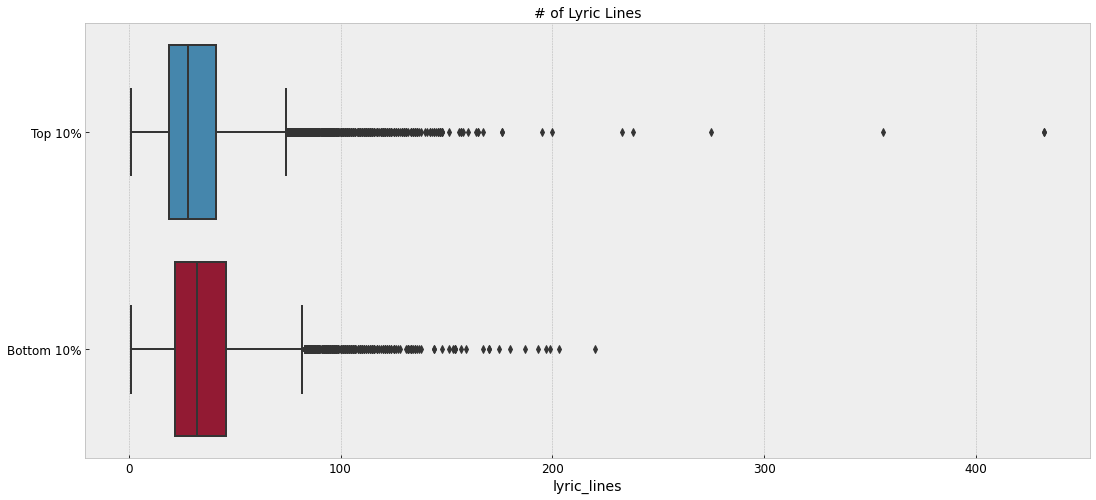

In [115]:
plot_numeric_col('lyric_lines', top_lyrics, bottom_lyrics, '# of Lyric Lines', save=True, save_title='lyric_lines_distribution.png')

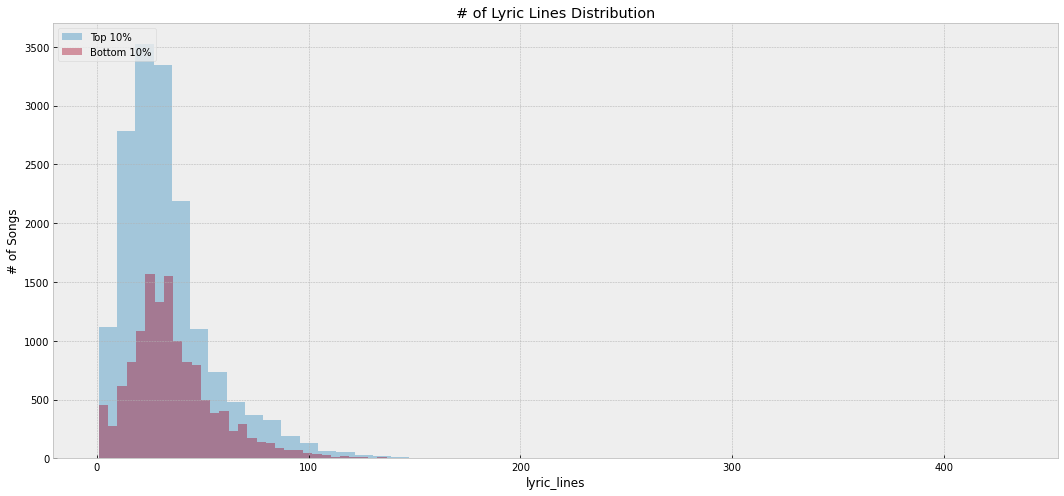

In [116]:
plot_histogram('lyric_lines', top_lyrics, bottom_lyrics, '# of Lyric Lines Distribution', save=True, save_title='lyric_lines_distribution.png')

In [117]:
var_comparison('lyric_lines', top_album_songs, bottom_album_songs)

N1 (Top 10%): 25270
N2 (Bottom 10%): 20495
U-value:  251418913.0
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.485
Top 10% Median:  18.0
Bottom 10% Median:  21.0
Number of Outliers (Top 10%):  346
Number of Outliers (Bottom 10%):  216


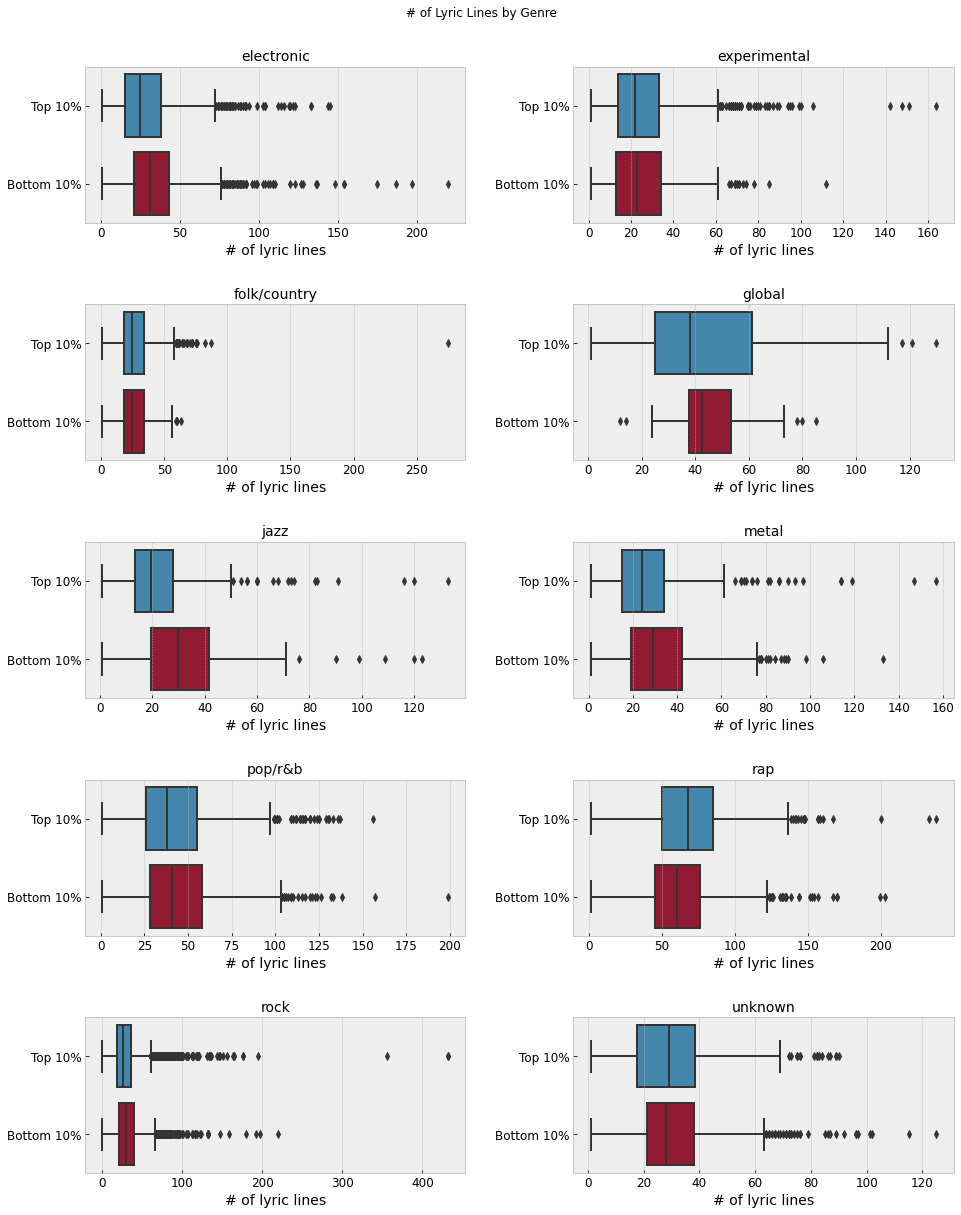

In [118]:
plot_numeric_grid('lyric_lines', top_lyrics, bottom_lyrics, '# of Lyric Lines by Genre', x_label='# of lyric lines')

In [119]:
lyric_lines_df = genre_comparison('lyric_lines', top_lyrics, bottom_lyrics,
                                   caption_text='Song # of Lyric Lines Statistical Analysis')
lyric_lines_df

### Lyric Words

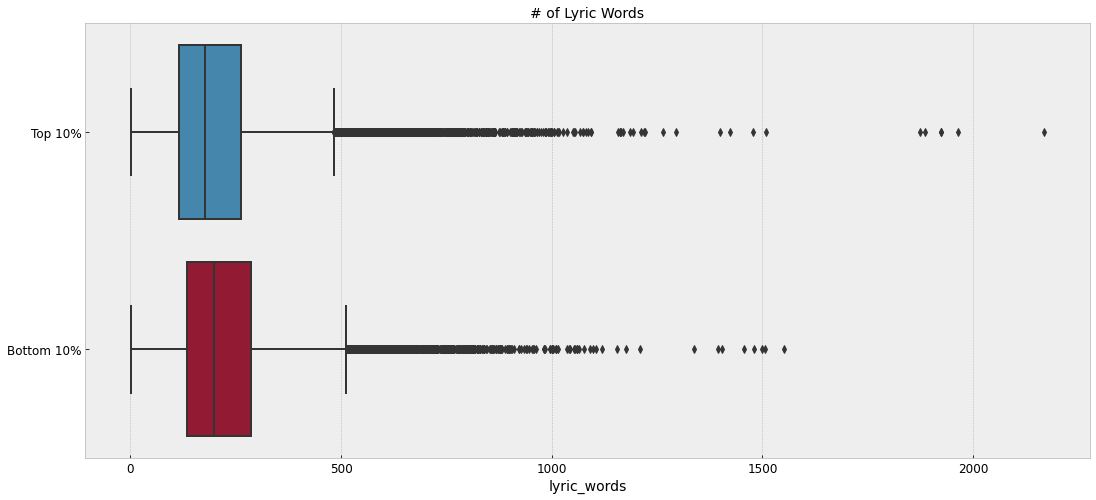

In [120]:
plot_numeric_col('lyric_words', top_lyrics, bottom_lyrics, '# of Lyric Words')

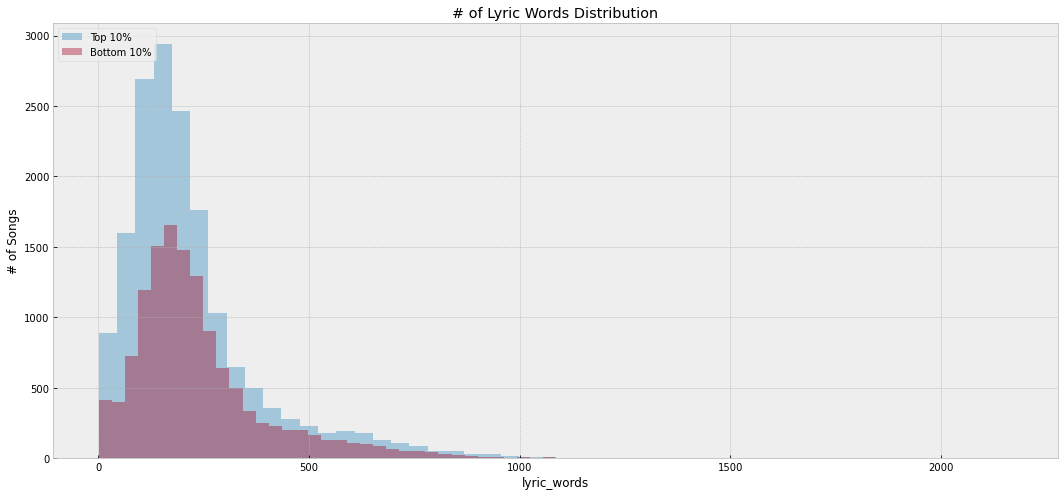

In [121]:
plot_histogram('lyric_words', top_lyrics, bottom_lyrics, '# of Lyric Words Distribution')

In [122]:
var_comparison('lyric_words', top_album_songs, bottom_album_songs)

N1 (Top 10%): 25270
N2 (Bottom 10%): 20495
U-value:  252857629.0
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.488
Top 10% Median:  111.0
Bottom 10% Median:  124.0
Number of Outliers (Top 10%):  525
Number of Outliers (Bottom 10%):  364


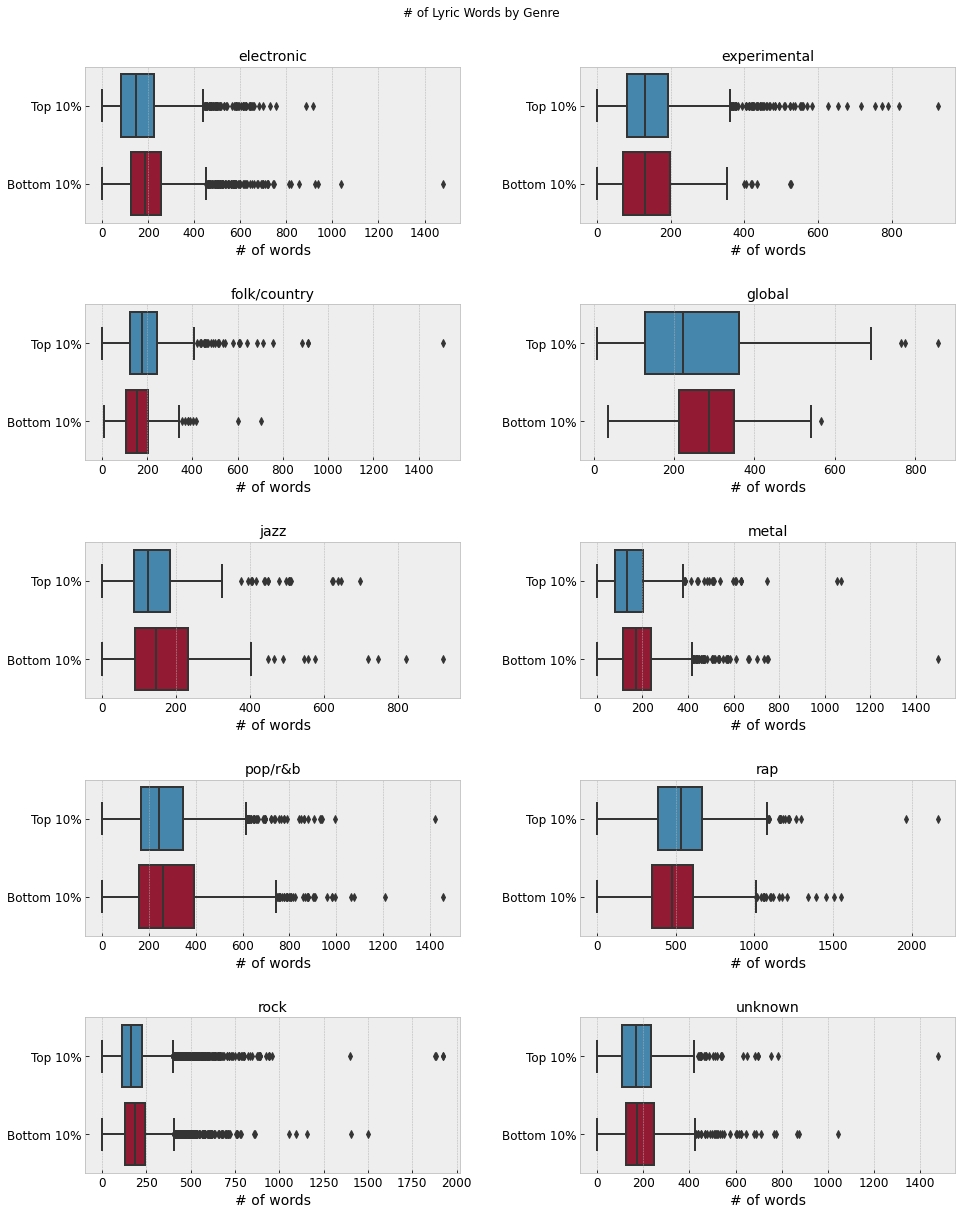

In [123]:
plot_numeric_grid('lyric_words', top_lyrics, bottom_lyrics, '# of Lyric Words by Genre', x_label='# of words')

In [124]:
lyric_words_df = genre_comparison('lyric_words', top_lyrics, bottom_lyrics, 
                                   caption_text='Song # of Lyric Words Statistical Analysis')
lyric_words_df

### Lyric Words Per Line

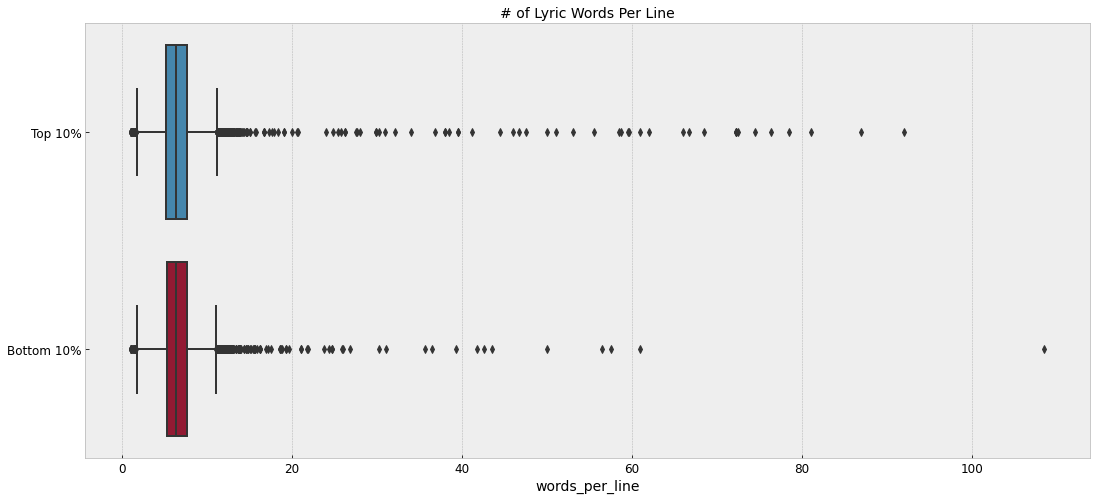

In [125]:
plot_numeric_col('words_per_line', top_lyrics[top_lyrics['lyric_lines'] > 1], 
                bottom_lyrics[bottom_lyrics['lyric_lines'] > 1], '# of Lyric Words Per Line')

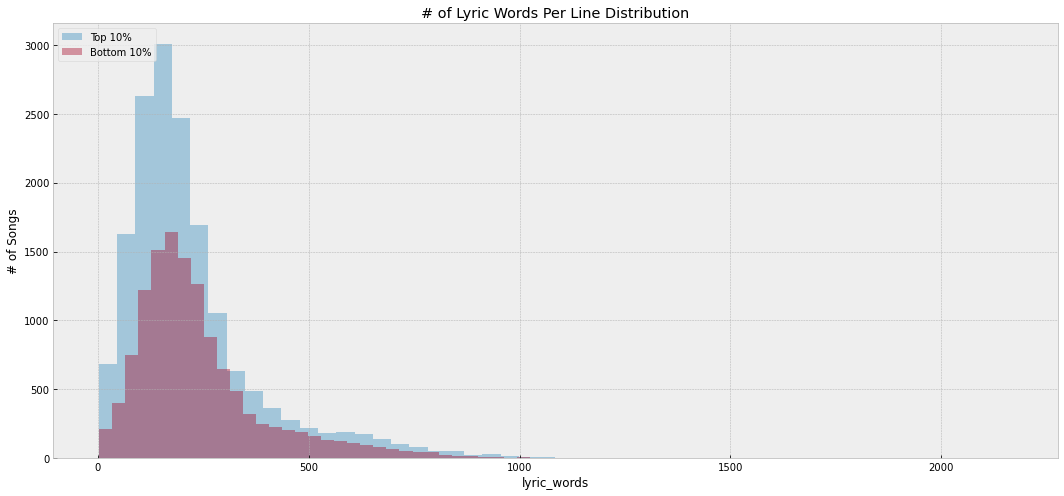

In [126]:
plot_histogram('lyric_words', top_lyrics[top_lyrics['lyric_lines'] > 1], 
                bottom_lyrics[bottom_lyrics['lyric_lines'] > 1], '# of Lyric Words Per Line Distribution')

In [127]:
var_comparison('words_per_line', top_album_songs, bottom_album_songs)

N1 (Top 10%): 25270
N2 (Bottom 10%): 20495
U-value:  250817410.5
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.484
Top 10% Median:  6.275862068965517
Bottom 10% Median:  6.243572841133817
Number of Outliers (Top 10%):  0
Number of Outliers (Bottom 10%):  0


/Users/scottduda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/Users/scottduda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


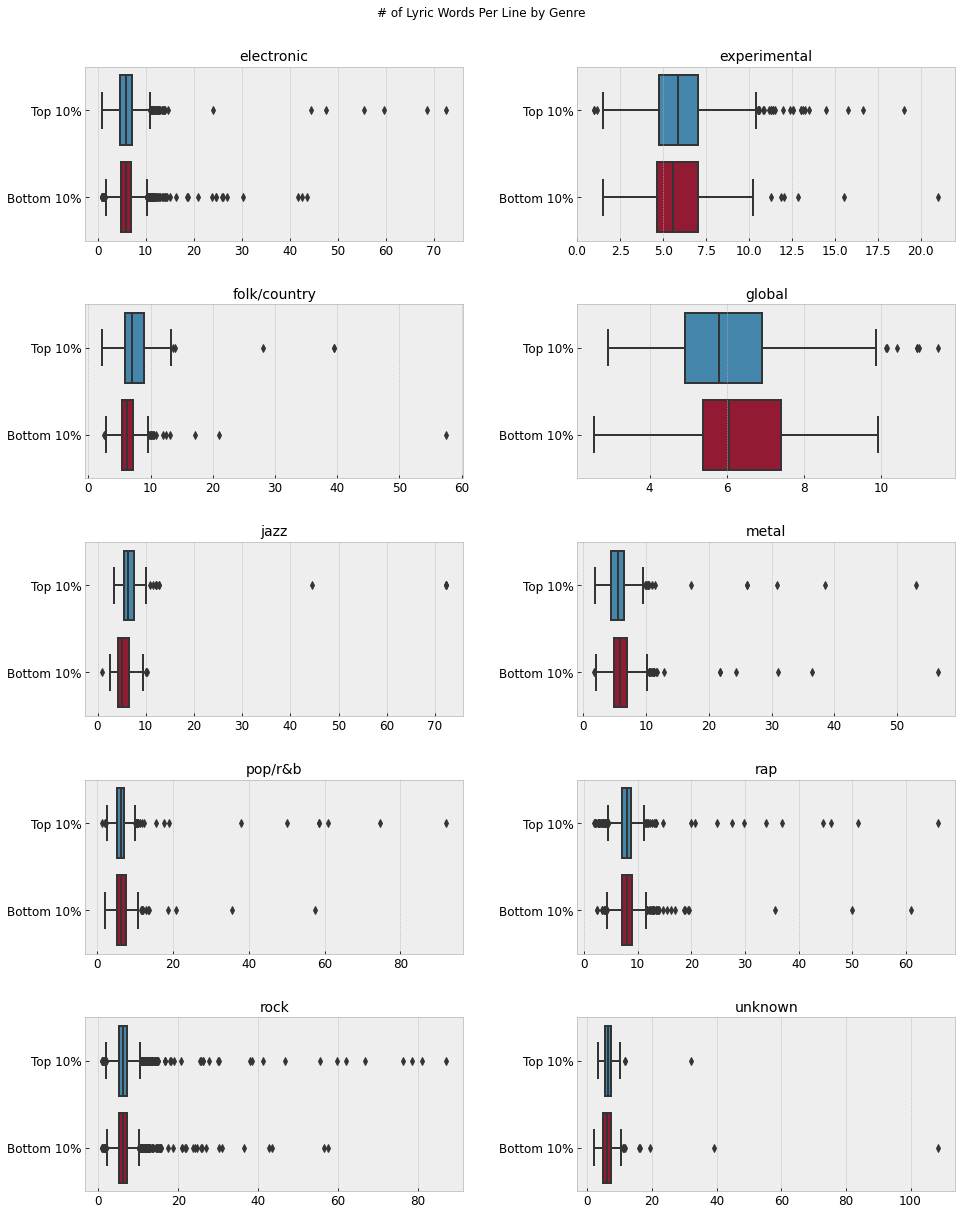

In [128]:
plot_numeric_grid('words_per_line', top_lyrics[top_lyrics['lyric_lines'] > 1], 
                  bottom_lyrics[bottom_lyrics['lyric_lines'] > 1], '# of Lyric Words Per Line by Genre')

In [129]:
words_per_line_df = genre_comparison('words_per_line', top_lyrics, bottom_lyrics, 
                                      caption_text='Song Words Per Line Statistical Analysis')
words_per_line_df

### Lyric Unique Words

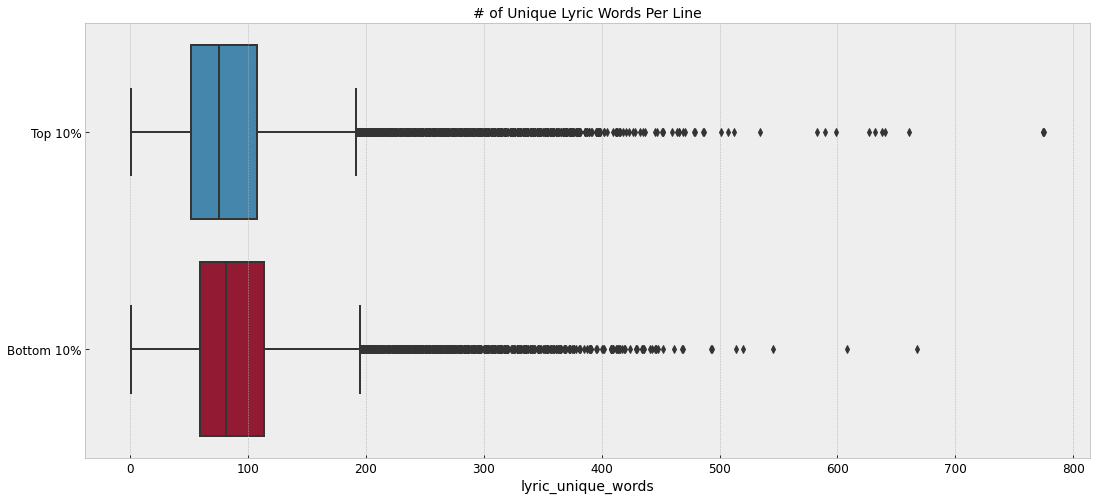

In [130]:
plot_numeric_col('lyric_unique_words', top_lyrics, bottom_lyrics, '# of Unique Lyric Words Per Line')

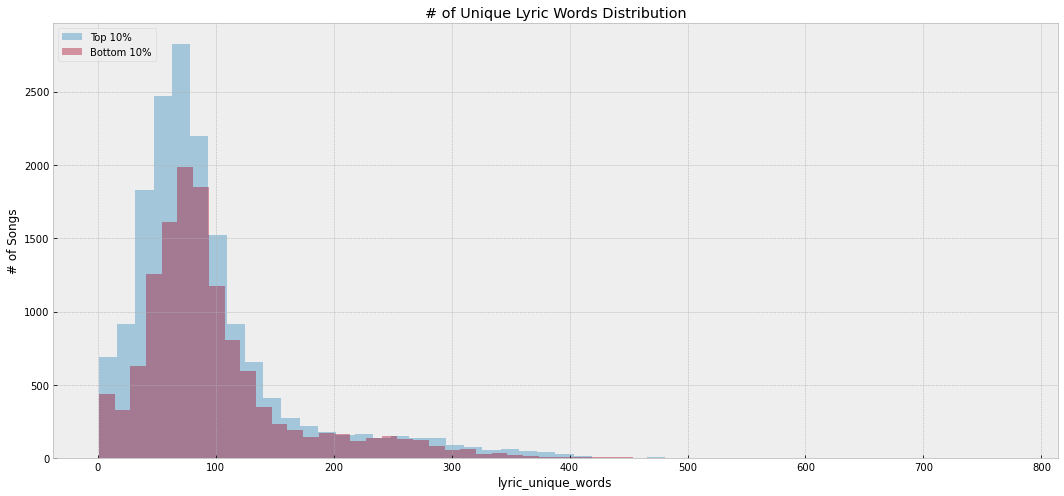

In [131]:
plot_histogram('lyric_unique_words', top_lyrics, bottom_lyrics, '# of Unique Lyric Words Distribution')

In [132]:
var_comparison('lyric_unique_words', top_album_songs, bottom_album_songs)

N1 (Top 10%): 25270
N2 (Bottom 10%): 20495
U-value:  254546709.5
p-value:  0.001
Significant:  True
Common Language Effect Size:  0.491
Top 10% Median:  50.0
Bottom 10% Median:  55.0
Number of Outliers (Top 10%):  604
Number of Outliers (Bottom 10%):  389


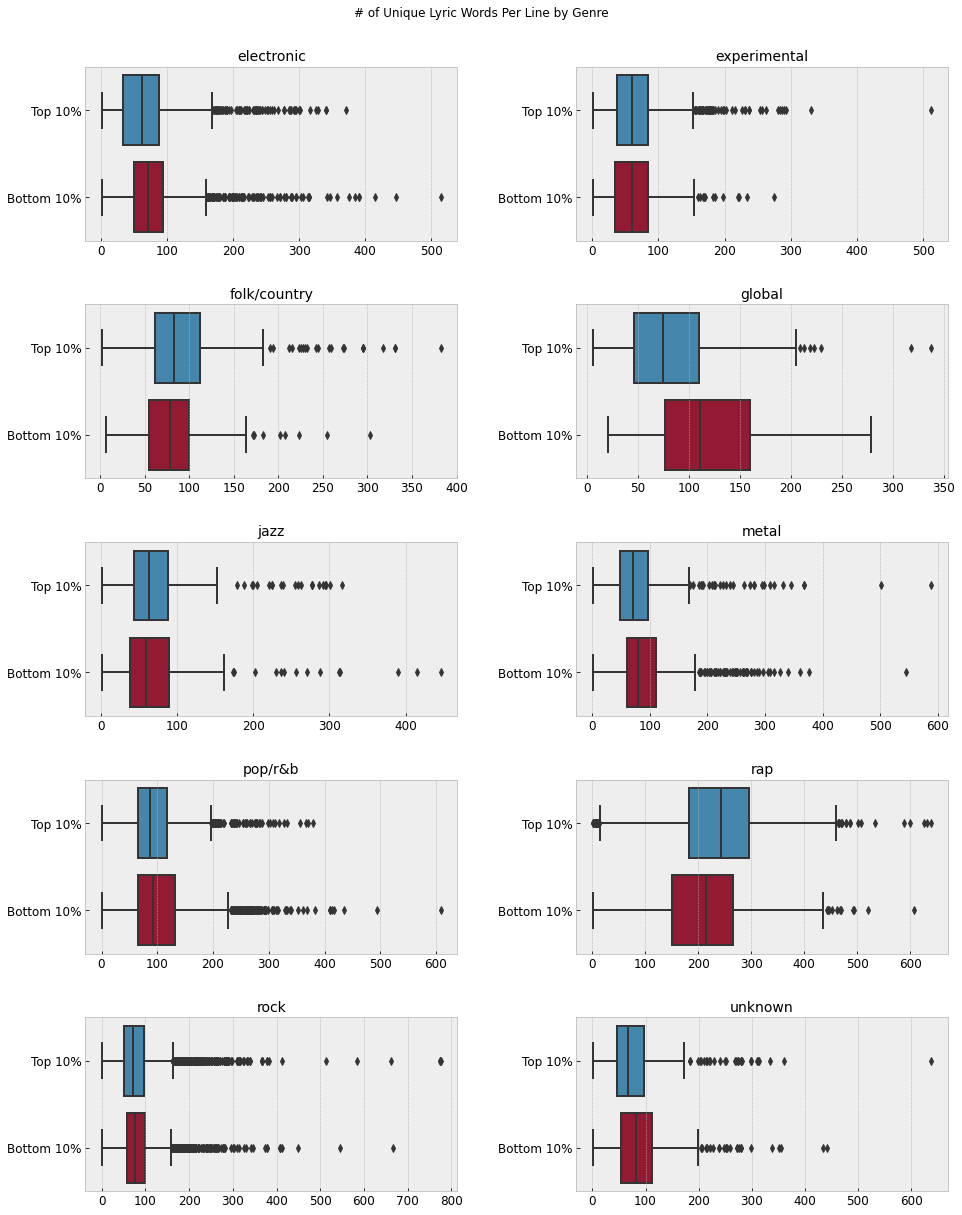

In [133]:
plot_numeric_grid('lyric_unique_words', top_lyrics, bottom_lyrics, '# of Unique Lyric Words Per Line by Genre')

In [134]:
lyric_unique_words_df = genre_comparison('lyric_unique_words', top_lyrics, bottom_lyrics,
                                          caption_text='Song Unique Words Statistical Analysis')
lyric_unique_words_df

### Most Frequent Unigrams

In [135]:
top_lyrics_combined = top_lyrics['song_lyrics'].apply(clean_text).values
bottom_lyrics_combined = bottom_lyrics['song_lyrics'].apply(clean_text).values

In [136]:
top_lyrics_string = ' '.join(top_lyrics_combined)
bottom_lyrics_string = ' '.join(bottom_lyrics_combined)

In [137]:
from collections import Counter
top_counter = Counter(top_lyrics_string.split())
bottom_counter = Counter(bottom_lyrics_string.split())

In [138]:
top_counter.most_common()[:7]

[('the', 152261),
 ('i', 110298),
 ('you', 105338),
 ('and', 85286),
 ('to', 77890),
 ('a', 75864),
 ('in', 50086)]

In [139]:
bottom_counter.most_common()[:7]

[('the', 126719),
 ('i', 100145),
 ('you', 96438),
 ('and', 69645),
 ('to', 66567),
 ('a', 62296),
 ('me', 44200)]

## Word Counts & Topic Modeling


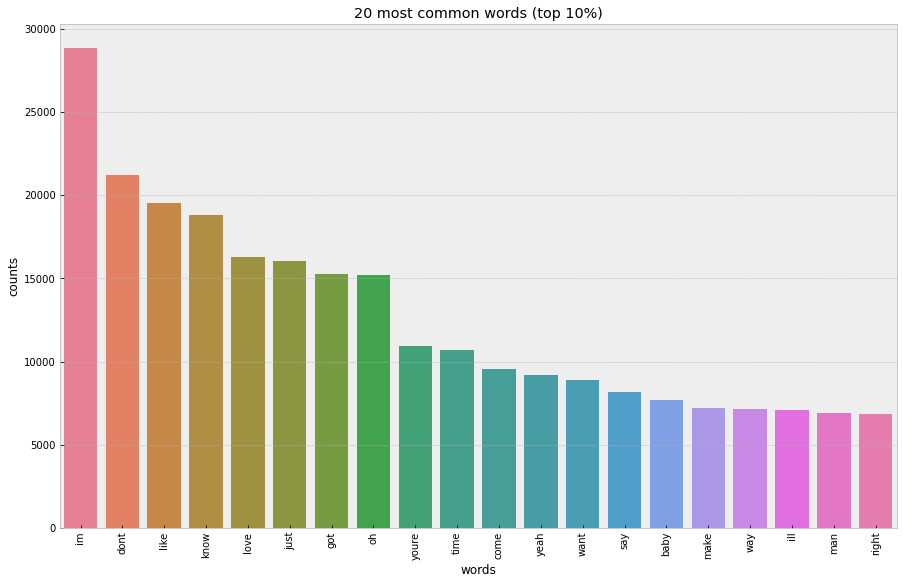

In [140]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_20_most_common_words(count_data, count_vectorizer, title):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title=title)
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

top_count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
top_count_data = top_count_vectorizer.fit_transform(top_lyrics['song_lyrics'].apply(clean_text))
# Visualise the 10 most common words
plot_20_most_common_words(top_count_data, top_count_vectorizer, '20 most common words (top 10%)')

In [141]:
# import warnings
# warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import LatentDirichletAllocation as LDA
 

def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
number_topics = 10
number_words = 20
# Create and fit the LDA model
top_lda = LDA(n_components=number_topics, n_jobs=-1)
top_lda.fit(top_count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(top_lda, top_count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
da shake man got new run aint like people lady happy time know said child house cool old just door

Topic #1:
love im youre night dont just like away come day life know eyes ill heart light ive sun let dream

Topic #2:
oh ah like eyes know dead end comes black cold soul wild born sea world low bye dark wind sound

Topic #3:
im sweet world just time eyes man like looking dont way turn make water mind walk ride ill little life

Topic #4:
na dance rock got boy music lets human day like oh just taking man beat lost let pop sing world

Topic #5:
dont know time just im say way feel away ooh youre make like theres ive want ill gone cause long

Topic #6:
la oh want dont right like im just let said know rock roll got home pa away feel theres run

Topic #7:
ma hey higher que di dem mi man se je le time et du les dee en johnny el sells

Topic #8:
got yeah baby im know dont oh love come hey want good gonna just girl youre aint right tell gotta

Topic #9:
im like go

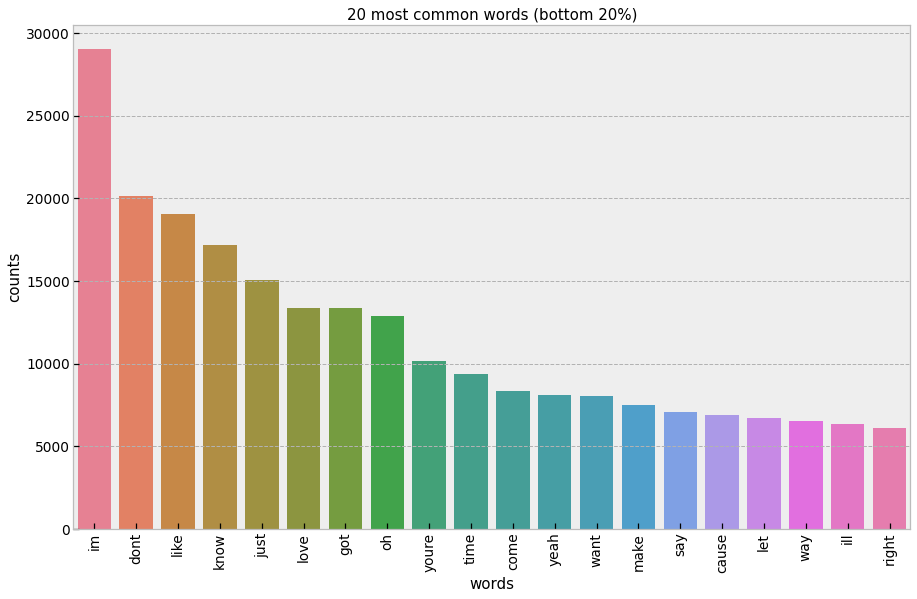

In [142]:
bottom_count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
bottom_count_data = bottom_count_vectorizer.fit_transform(bottom_lyrics['song_lyrics'].apply(clean_text))
# Visualise the 10 most common words
plot_20_most_common_words(bottom_count_data, bottom_count_vectorizer, '20 most common words (bottom 20%)')

In [143]:
bottom_lda = LDA(n_components=number_topics, n_jobs=-1)
bottom_lda.fit(bottom_count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(bottom_lda, bottom_count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
rock wanna know im like loop dont roll black make low youll man just meet human baby army got feel

Topic #1:
im like got aint shit nigga niggas fuck dont know em money bitch just yeah cause thats make ya man

Topic #2:
ooh new like red blue ahh york sea city oooh set away sky sweet girls sing come born play walk

Topic #3:
la da shes im life man like hes eyes ive open happy alive heart got world blood look live hands

Topic #4:
love im like away ah hold just dont want feel waiting night know ill light run life come heart theres

Topic #5:
oh im got yeah baby gonna na right know good like uh just ive dont say youre feeling feel way

Topic #6:
come want lets dance make baby dont alright free im save know like somebody turn jump home theyre time let

Topic #7:
dont know just let need im say hey want wanna like girl tell cause got youre love way world wont

Topic #8:
dont know right said im like time just got didnt care mean tell look man high ba say wake 

In [144]:
top_album_songs

reviewid artist_name          album_title  score  \
0         22061   brian eno  another green world   10.0   
1         22061   brian eno  another green world   10.0   
2         22061   brian eno  another green world   10.0   
3         22061   brian eno  another green world   10.0   
4         22061   brian eno  another green world   10.0   
...         ...         ...                  ...    ...   
25265     19466      mogwai    come on die young    8.3   
25266     19466      mogwai    come on die young    8.3   
25267     19466      mogwai    come on die young    8.3   
25268     19466      mogwai    come on die young    8.3   
25269     19466      mogwai    come on die young    8.3   

                                      song_name                 song_id  \
0               Sky Saw - 2004 Digital Remaster  1sr1NnVTSUZL2xGzlkiq1G   
1      Over Fire Island - 2004 Digital Remaster  5Sodk3mkwv4Gvp2sF3obaE   
2        St Elmo's Fire - 2004 Digital Remaster  0UROPTHqU5C7TI1N8wOkIF   
3         In Dark Trees - 2004 Digital Remaster  41RiTUEXw8uoCtLd8pcHVy   
4          The Big Ship - 2004 Digital Remaster  2d9KBVxb6bUfVCjjv1JAVe   
...                                         ...                     ...   
25265                 Oh! How the Dogs Stack Up  6zS8xEzwLRLCOm30jKkKEp   
25266                                 Ex-Cowboy  47nFpQVseKfAm8ZyHPTauC   
25267                                    Chocky  71MpeMpvkSsH7Zj2VNj0XZ   
25268                           Christmas Steps  7t10U1omkR84WXjQc4RKuh   
25269         Punk Rock/ Puff Daddy/ Antichrist  7fsGD2931vm16TnpiwrUmV   

       song_track_number  song_duration  song_explicit  \
0                      1         207666              0   
1                      2         111213              0   
2                      3         182413              0   
3                      4         151573              0   
4                      5         181933              0   
...                  ...            ...            ...   
25265                  8         123832              0   
25266                  9         549384              0   
25267                 10         563316              0   
25268                 11         639013              0   
25269                 12         134373              0   

                                   song_uri  acousticness  danceability  \
0      spotify:track:1sr1NnVTSUZL2xGzlkiq1G      0.546000         0.523   
1      spotify:track:5Sodk3mkwv4Gvp2sF3obaE      0.251000         0.796   
2      spotify:track:0UROPTHqU5C7TI1N8wOkIF      0.485000         0.446   
3      spotify:track:41RiTUEXw8uoCtLd8pcHVy      0.520000         0.651   
4      spotify:track:2d9KBVxb6bUfVCjjv1JAVe      0.132000         0.377   
...                                     ...           ...           ...   
25265  spotify:track:6zS8xEzwLRLCOm30jKkKEp      0.981000         0.490   
25266  spotify:track:47nFpQVseKfAm8ZyHPTauC      0.001230         0.240   
25267  spotify:track:71MpeMpvkSsH7Zj2VNj0XZ      0.000485         0.339   
25268  spotify:track:7t10U1omkR84WXjQc4RKuh      0.087600         0.450   
25269  spotify:track:7fsGD2931vm16TnpiwrUmV      0.863000         0.242   

       energy  key  mode  time_signature  instrumentalness  liveness  \
0      0.5670    2     1               4            0.5420    0.0926   
1      0.2110    1     1               4            0.8350    0.1190   
2      0.6630    0     1               4            0.3980    0.0804   
3      0.3790    6     0               4            0.7960    0.0759   
4      0.2610    0     1               3            0.8750    0.1160   
...       ...  ...   ...             ...               ...       ...   
25265  0.0991    9     1               4            0.0699    0.3630   
25266  0.2920    2     0               4            0.9040    0.1090   
25267  0.5060    7     1               3            0.8520    0.1090   
25268  0.0431    9     1               4            0.8080    0.1870   
25269  